In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

In [ ]:
data['neuron_info']

In [5]:
spikes_results = xr.open_dataset('Jaq_03_12_cv_classifier_sortedspikes_forward_reverse_nose_no_vel_results.nc')
clusterless_results = xr.open_dataset('Jaq_03_12_cv_classifier_clusterless_forward_reverse_nose_no_vel_results.nc')

In [6]:
ripple_number = 1

ripple = data['ripple_times'].loc[ripple_number]

start_time = ripple.start_time
end_time = ripple.end_time

spikes_results.sel(time=slice(start_time / np.timedelta64(1, 's'), end_time / np.timedelta64(1, 's')))

<xarray.Dataset>
Dimensions:            (position: 161, state: 6, time: 66)
Coordinates:
  * time               (time) float64 1.637e+04 1.637e+04 ... 1.637e+04
  * position           (position) float64 1.249 3.747 6.246 ... 419.9 422.4
  * state              (state) object 'Inbound-Forward' ... 'Outbound-Fragmen...
Data variables:
    likelihood         (time, state, position) float64 ...
    causal_posterior   (time, state, position) float64 ...
    acausal_posterior  (time, state, position) float64 ...

In [7]:
data['spikes'].loc[start_time:end_time].shape

(66, 121)

In [8]:
from replay_trajectory_classification import SortedSpikesClassifier

cv_classifier = SortedSpikesClassifier.load_model(f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_sortedspikes_forward_reverse_nose_no_vel_model.pkl")

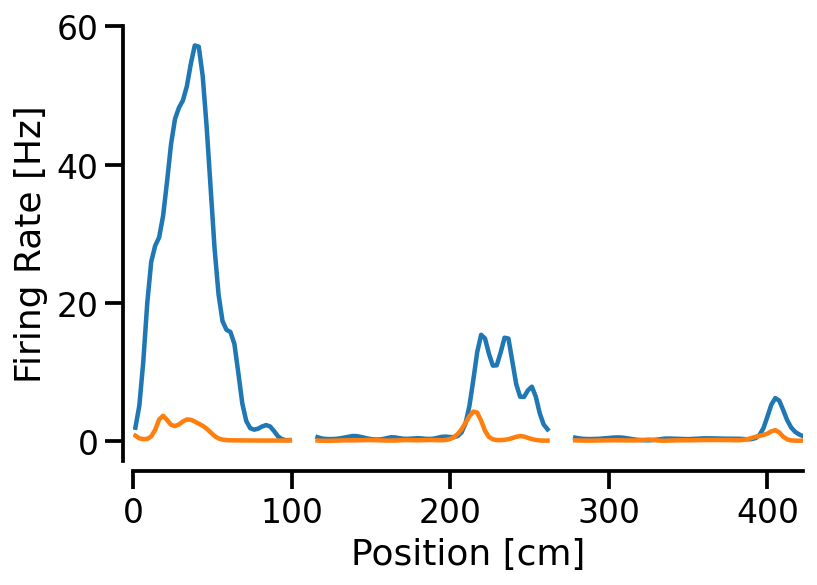

In [9]:
from src.parameters import SAMPLING_FREQUENCY

neuron_ind = 24

(cv_classifier.place_fields_.isel(neuron=neuron_ind).where(cv_classifier.is_track_interior_) * SAMPLING_FREQUENCY).plot(
    x='position', hue='encoding_group', add_legend=False)
plt.xlabel('Position [cm]')
plt.ylabel('Firing Rate [Hz]')
plt.xlim((0, cv_classifier.place_fields_.position[-1]))
sns.despine(offset=5)

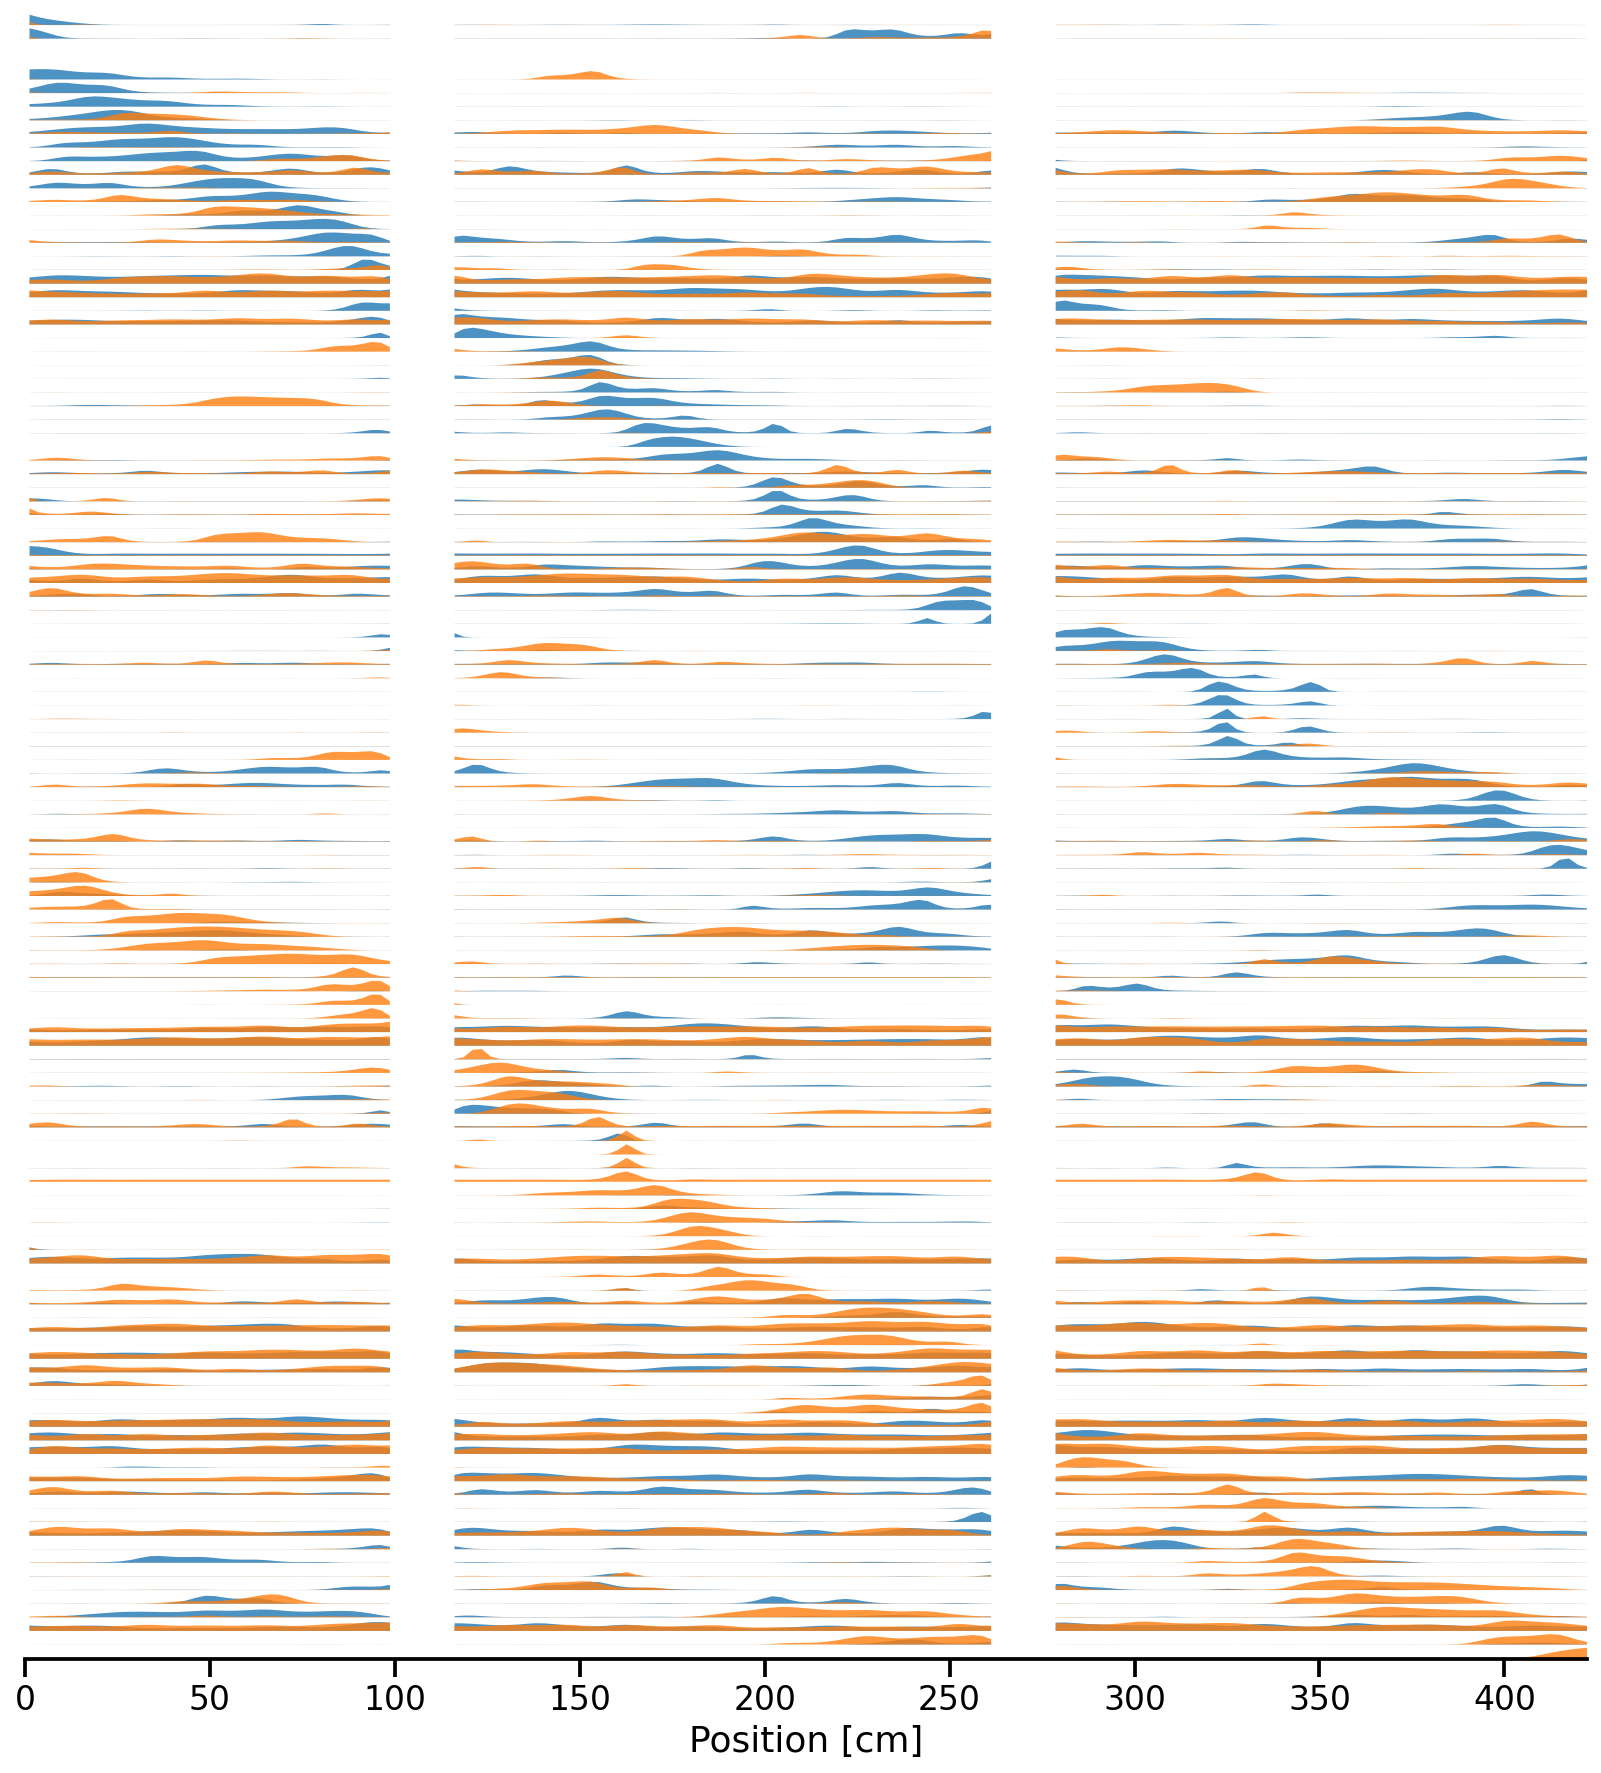

In [10]:
n_neurons = len(cv_classifier.place_fields_.neuron)

idx = cv_classifier.place_fields_.argmax(dim=['encoding_group', 'position'])
idx = np.stack((idx['encoding_group'].values, idx['position'].values, np.arange(n_neurons)), axis=1)
idx = idx[np.argsort(idx[:, 1])]
idx = np.concatenate((idx[idx[:, 0] == 0],
                      idx[idx[:, 0] == 1]))
sorted_neuron_idx = idx[:, 2]


fig, axes = plt.subplots(n_neurons, 1, sharex=True, figsize=(14, n_neurons / 8))

for neuron_ind, ax in zip(sorted_neuron_idx, axes.flat):
    place_field = (cv_classifier
     .place_fields_
     .isel(neuron=neuron_ind)
     .where(cv_classifier.is_track_interior_) * SAMPLING_FREQUENCY
    )
    ax.fill_between(place_field.position, place_field.sel(encoding_group='Inbound'), alpha=0.8)
    ax.fill_between(place_field.position, place_field.sel(encoding_group='Outbound'), alpha=0.8)
    ax.set_xlim((0, cv_classifier.place_fields_.position[-1]))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])

sns.despine()
axes[-1].set_xlabel('Position [cm]')

for ax in axes[:-1].flat:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
axes[-1].get_yaxis().set_visible(False)
axes[-1].spines["left"].set_visible(False)

In [11]:
import pandas as pd


def get_probability_of_state(results, posterior_type='acausal_posterior'):
    fragmented = (results[posterior_type]
                  .sel(state=['Inbound-Fragmented', 'Outbound-Fragmented'])
                  .sum(['state', 'position'])
                  .assign_coords({'state': 'Fragmented'}))
    probability = (results[posterior_type]
                   .sum('position')
                   .drop_sel(state=['Inbound-Fragmented', 'Outbound-Fragmented']))
    return xr.concat((probability, fragmented), dim='state')

def classify_states(probability, probability_threshold=0.8):
    is_classified = (probability > probability_threshold).sum('state').astype(bool)
    max_state = probability.idxmax('state')
    classified_states_by_time = max_state.isel(time=is_classified)

    indexes = np.unique(classified_states_by_time.values, return_index=True)[1]
    classified_states = classified_states_by_time.values[sorted(indexes)]
    is_state = (probability > probability_threshold).sum('time') > 0
    return classified_states_by_time, classified_states, is_state.values


classified_states = []
is_state = []

for ripple_number in data['ripple_times'].index:
    ripple = data['ripple_times'].loc[ripple_number]

    start_time = ripple.start_time
    end_time = ripple.end_time

    probability = get_probability_of_state(
                    spikes_results.sel(time=slice(start_time / np.timedelta64(1, 's'),
                                                  end_time / np.timedelta64(1, 's'))))
    _, classified_states_temp, is_state_temp = classify_states(probability)
    classified_states.append(classified_states_temp)
    is_state.append(is_state_temp)
    
is_state = np.stack(is_state)
is_state = pd.DataFrame(is_state, columns=probability.state, index=data['ripple_times'].index)

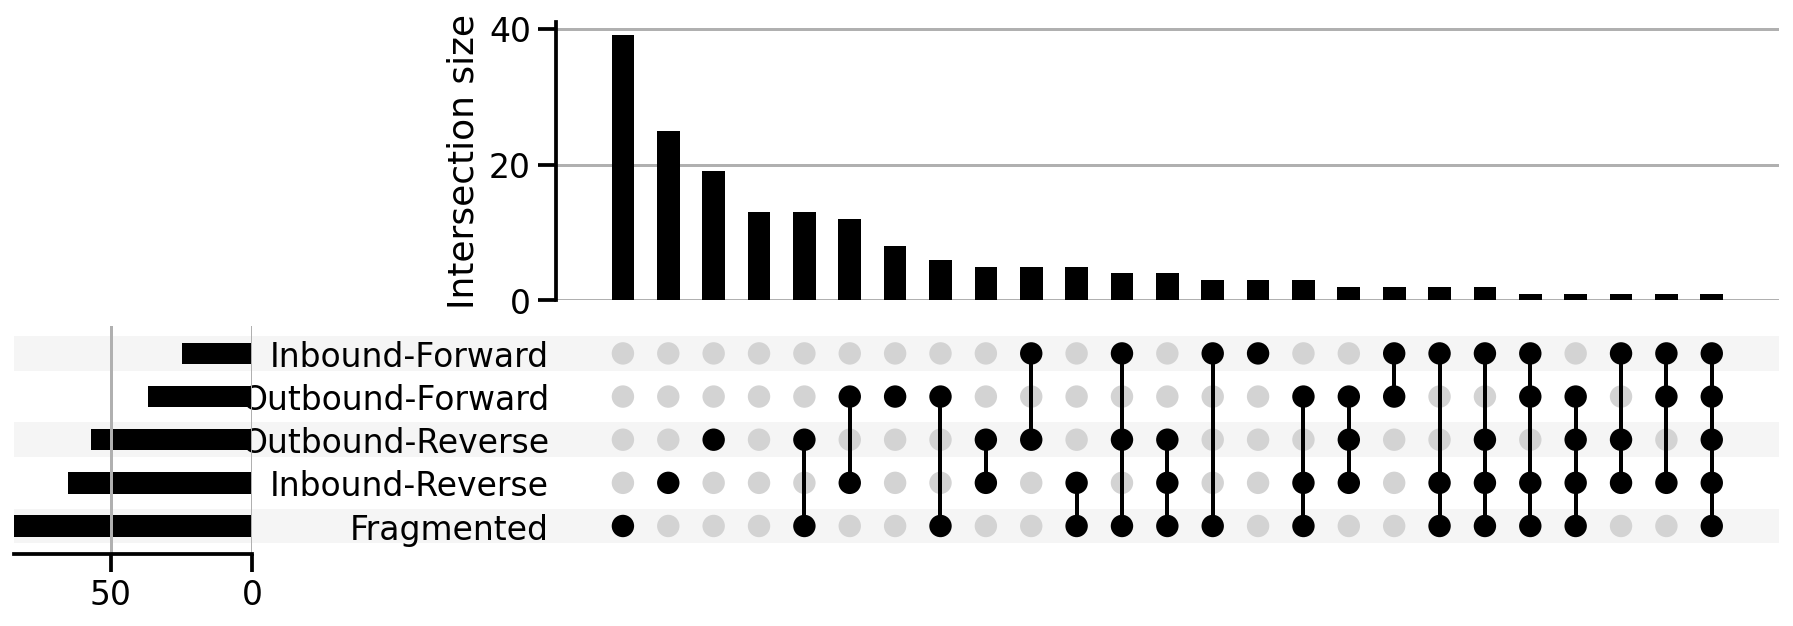

In [12]:
from upsetplot import UpSet

UpSet(is_state.reset_index(drop=True).set_index(probability.state.values.tolist()),
      sort_by='cardinality',
      show_percentages=False,
      totals_plot_elements=5
     )

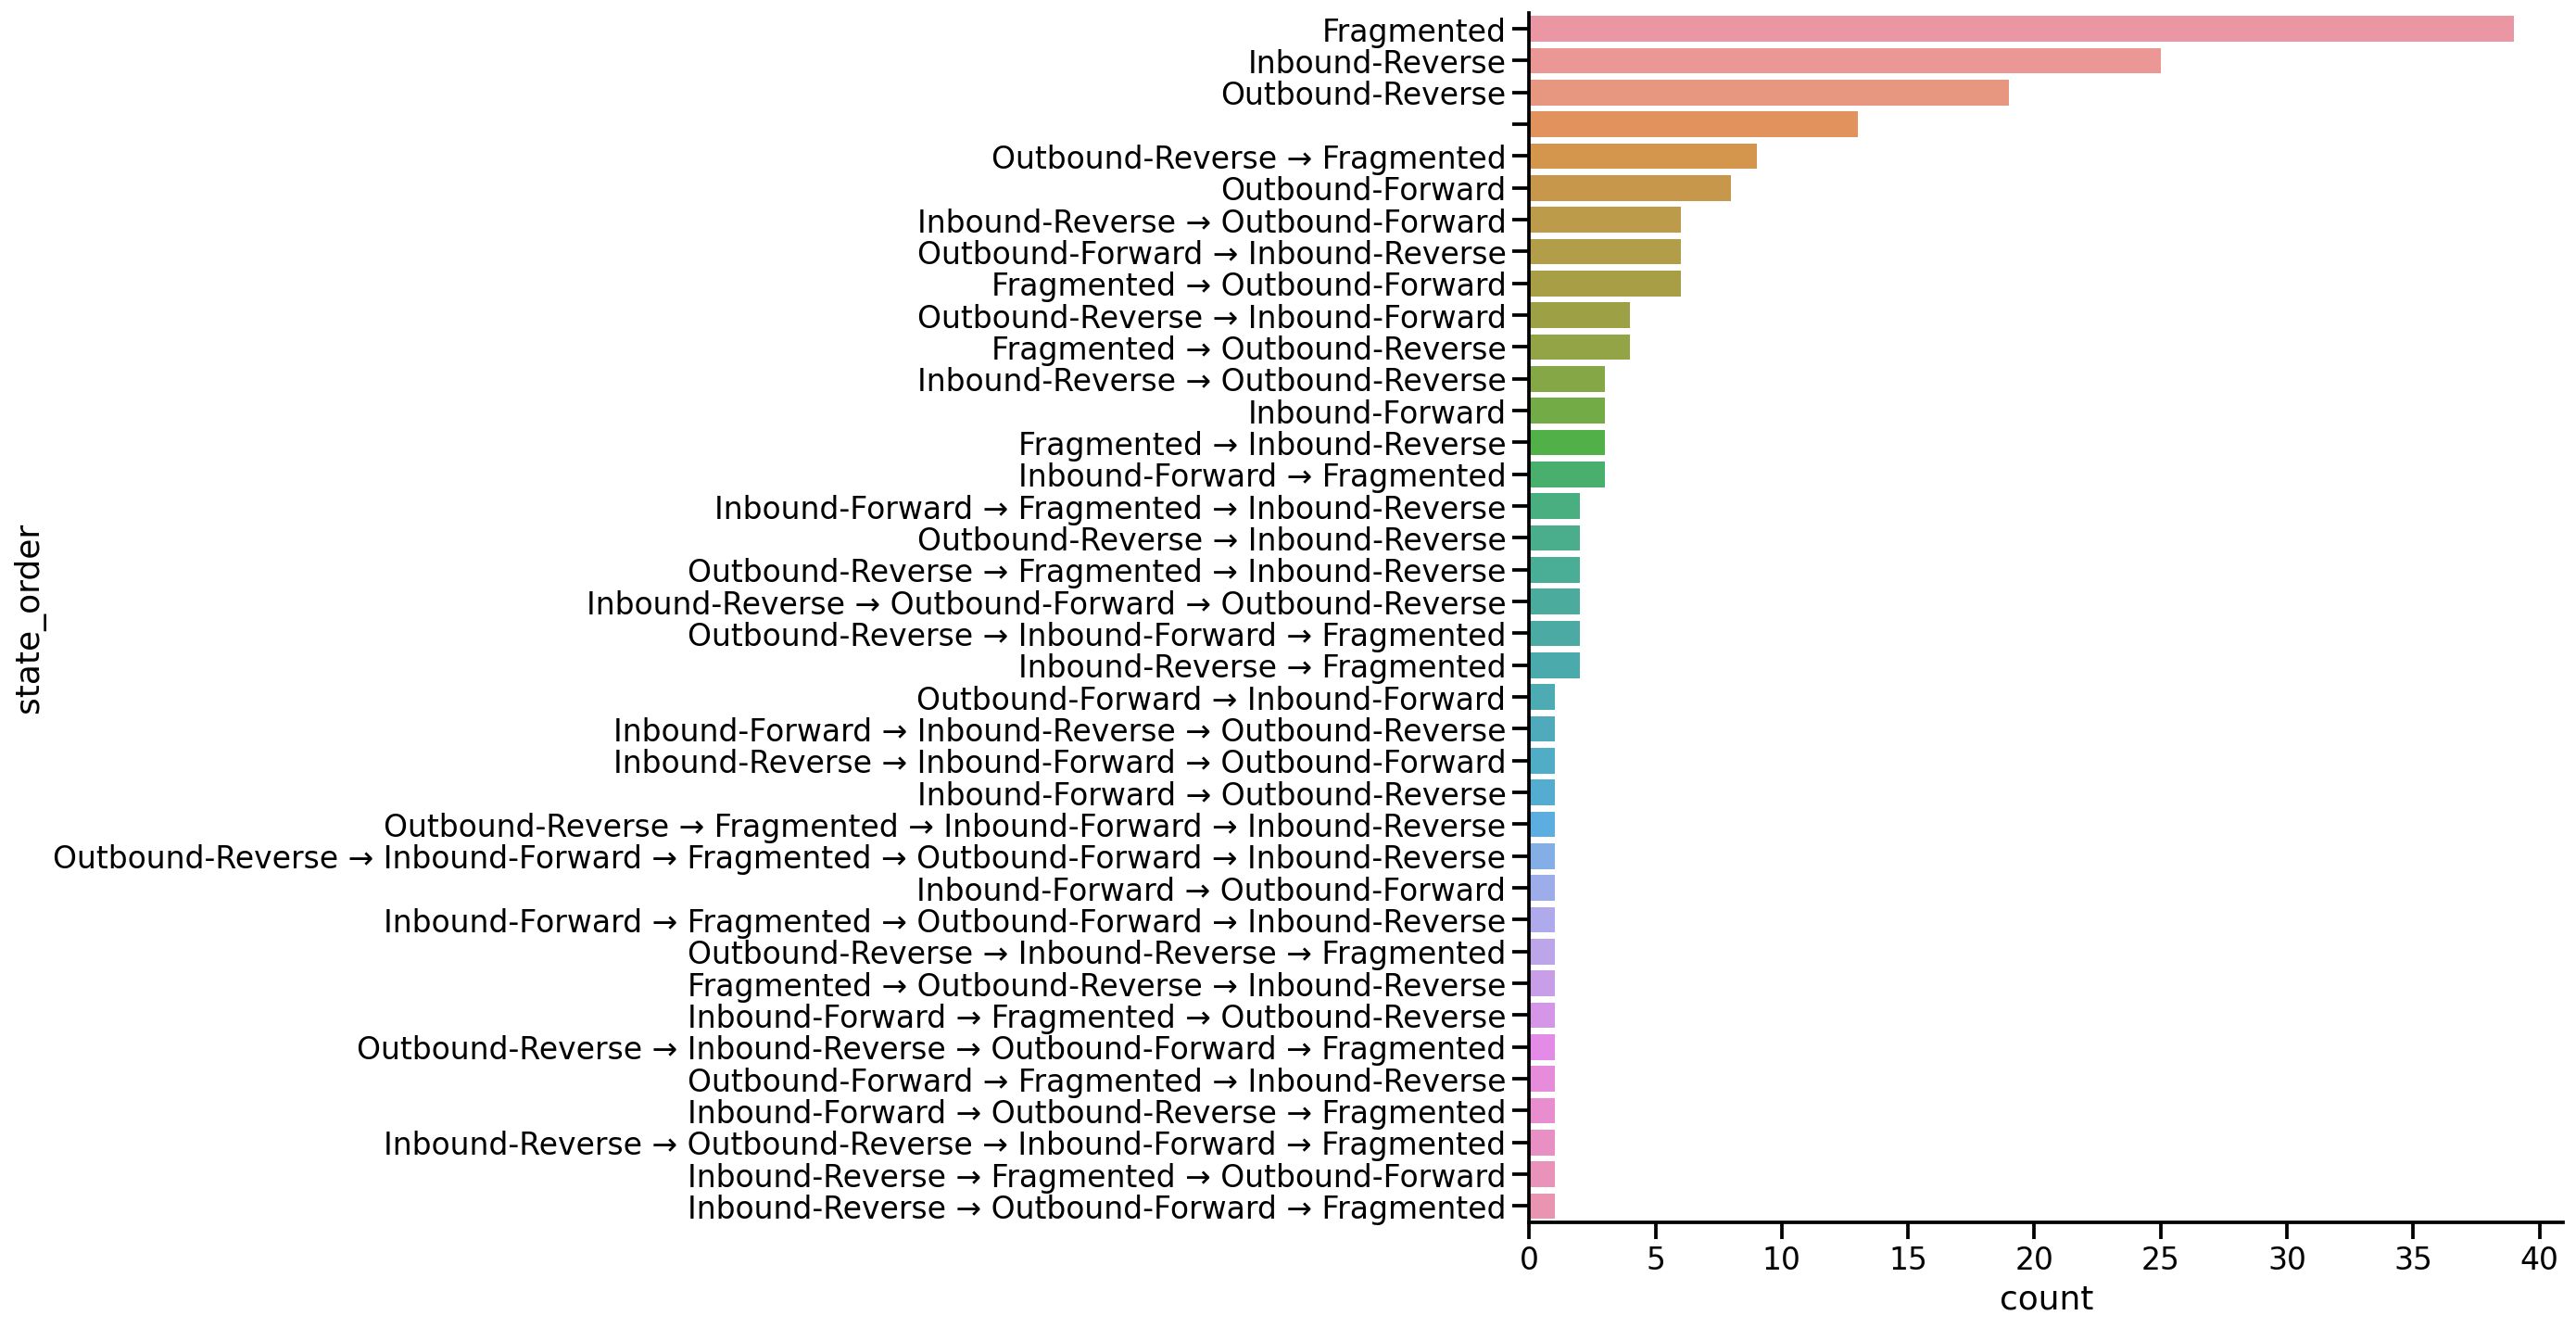

In [28]:
fig, ax = plt.subplots(figsize=(10, 12))
state_order = pd.DataFrame([' → '.join(states) for states in classified_states],
                           columns=['state_order'],
                           index=data['ripple_times'].index)
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()

In [29]:
state_order.iloc[(state_order == 'Outbound-Reverse').values]

state_order
replay_number                  
9              Outbound-Reverse
31             Outbound-Reverse
32             Outbound-Reverse
45             Outbound-Reverse
50             Outbound-Reverse
58             Outbound-Reverse
76             Outbound-Reverse
77             Outbound-Reverse
83             Outbound-Reverse
86             Outbound-Reverse
132            Outbound-Reverse
134            Outbound-Reverse
138            Outbound-Reverse
152            Outbound-Reverse
159            Outbound-Reverse
164            Outbound-Reverse
173            Outbound-Reverse
175            Outbound-Reverse
177            Outbound-Reverse

In [154]:
import copy

def get_neuron_order(classifier):
    n_neurons = len(classifier.place_fields_.neuron)
    idx = classifier.place_fields_.argmax(dim=['encoding_group', 'position'])
    idx = np.stack((idx['encoding_group'].values, idx['position'].values, np.arange(n_neurons)), axis=1)
    idx = idx[np.argsort(idx[:, 1])]
    idx = np.concatenate((idx[idx[:, 0] == 0],
                          idx[idx[:, 0] == 1]))
    
    return pd.DataFrame(idx, columns=['encoding_group', 'position_bin', 'neuron_ind'])


def plot_classifier_inbound_outbound_spikes(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
):

    t = data["position_info"].index / np.timedelta64(1, "s")
    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    fig, axes = plt.subplots(
        5,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1, 1]},
    )

    # ax 0
    (results[posterior_type]
     .sum('state')
     .where(classifier.is_track_interior_)
     .sel(time=time_slice)
     .plot(
         x="time",
         y="position",
         robust=True,
         ax=axes[0],
         cmap=cmap,
         vmin=0.0,
         add_colorbar=legend,
    ))

    axes[0].set_ylabel("Position [cm]")

    axes[0].scatter(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="magenta",
        alpha=0.8,
        s=10,
        zorder=100,
    )
    axes[0].set_xlabel("")

    # ax 1
    fragmented = (results[posterior_type]
                  .sel(state=['Inbound-Fragmented', 'Outbound-Fragmented'])
                  .sum(['state', 'position'])
                  .assign_coords({'state': 'Fragmented'}))
    probability = (results[posterior_type]
                   .sum('position')
                   .drop_sel(state=['Inbound-Fragmented', 'Outbound-Fragmented']))
    probability = xr.concat((probability, fragmented), dim='state')
    h = probability.sel(time=time_slice).plot(
        x="time", hue="state", ax=axes[1], add_legend=False, clip_on=False,
    )
    if legend:
        axes[1].legend(handles=h, labels=probability.state.values.tolist(),
                       bbox_to_anchor=(1.10, 0.8), loc='upper right', ncol=1, fontsize=12)
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")
    axes[1].set_ylim((0, 1))
    
    # ax 2
    neuron_order = get_neuron_order(cv_classifier)

    spikes = (
        data["spikes"]
        .reset_index(drop=True)
        .set_index(
            data["spikes"].index / np.timedelta64(1, "s"))
    )
    spikes = spikes.iloc[:, neuron_order.neuron_ind]

    spike_time_ind, neuron_ind = np.nonzero(np.asarray(spikes.loc[time_slice]))
    spike_times = np.asarray(spikes.loc[time_slice].index)[spike_time_ind]
    encoding_group = neuron_order.encoding_group.values[neuron_ind]
    
    for group in np.unique(encoding_group):
        axes[2].scatter(spike_times[encoding_group == group],
                        neuron_ind[encoding_group == group],
                        zorder=1,
                        marker='|',
                        s=20,
                        linewidth=2)
    n_neurons = spikes.shape[1]
    axes[2].set_yticks((0, n_neurons))
    axes[2].set_ylim((0, n_neurons))
    axes[2].set_ylabel('Cell ID')

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[3].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Firing Rate\n[spikes / s]")

    # ax 3
    axes[4].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        np.abs(data["position_info"]
               .reset_index()
               .set_index(t)
               .loc[time_slice]
               .tailBase_vel.values.squeeze()),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[4].set_ylabel("Speed \n[cm / s]")
    axes[4].set_xlabel("Time [s]")
    axes[4].ticklabel_format(style='plain', axis='x')
    
    sns.despine()

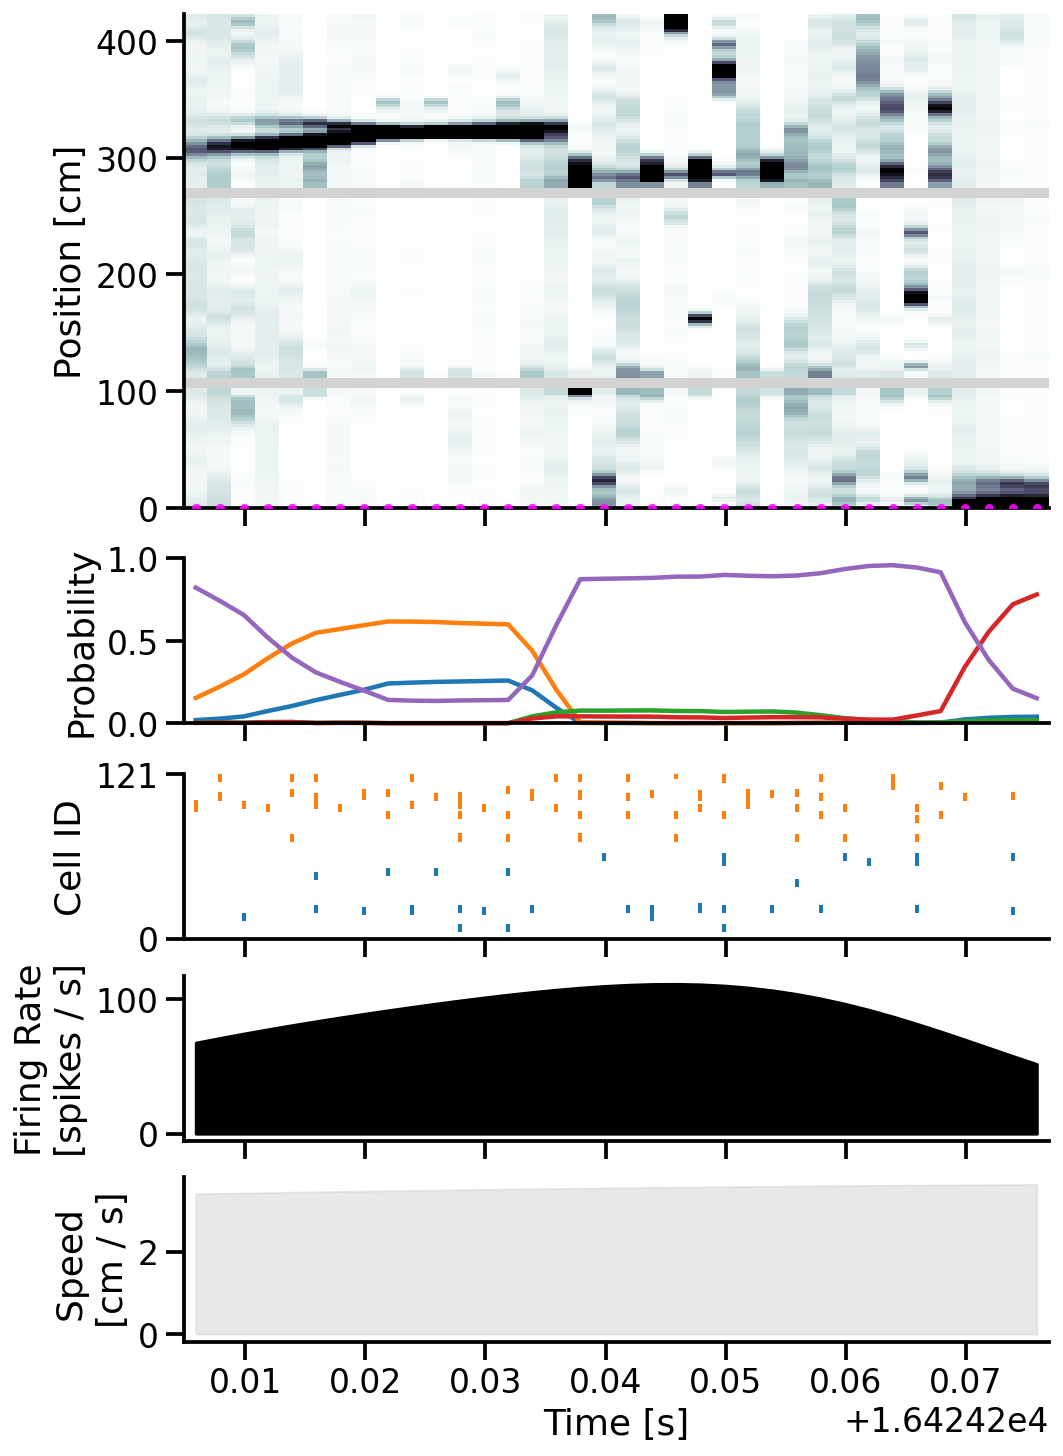

In [155]:
ripple_number = 14
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_spikes(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

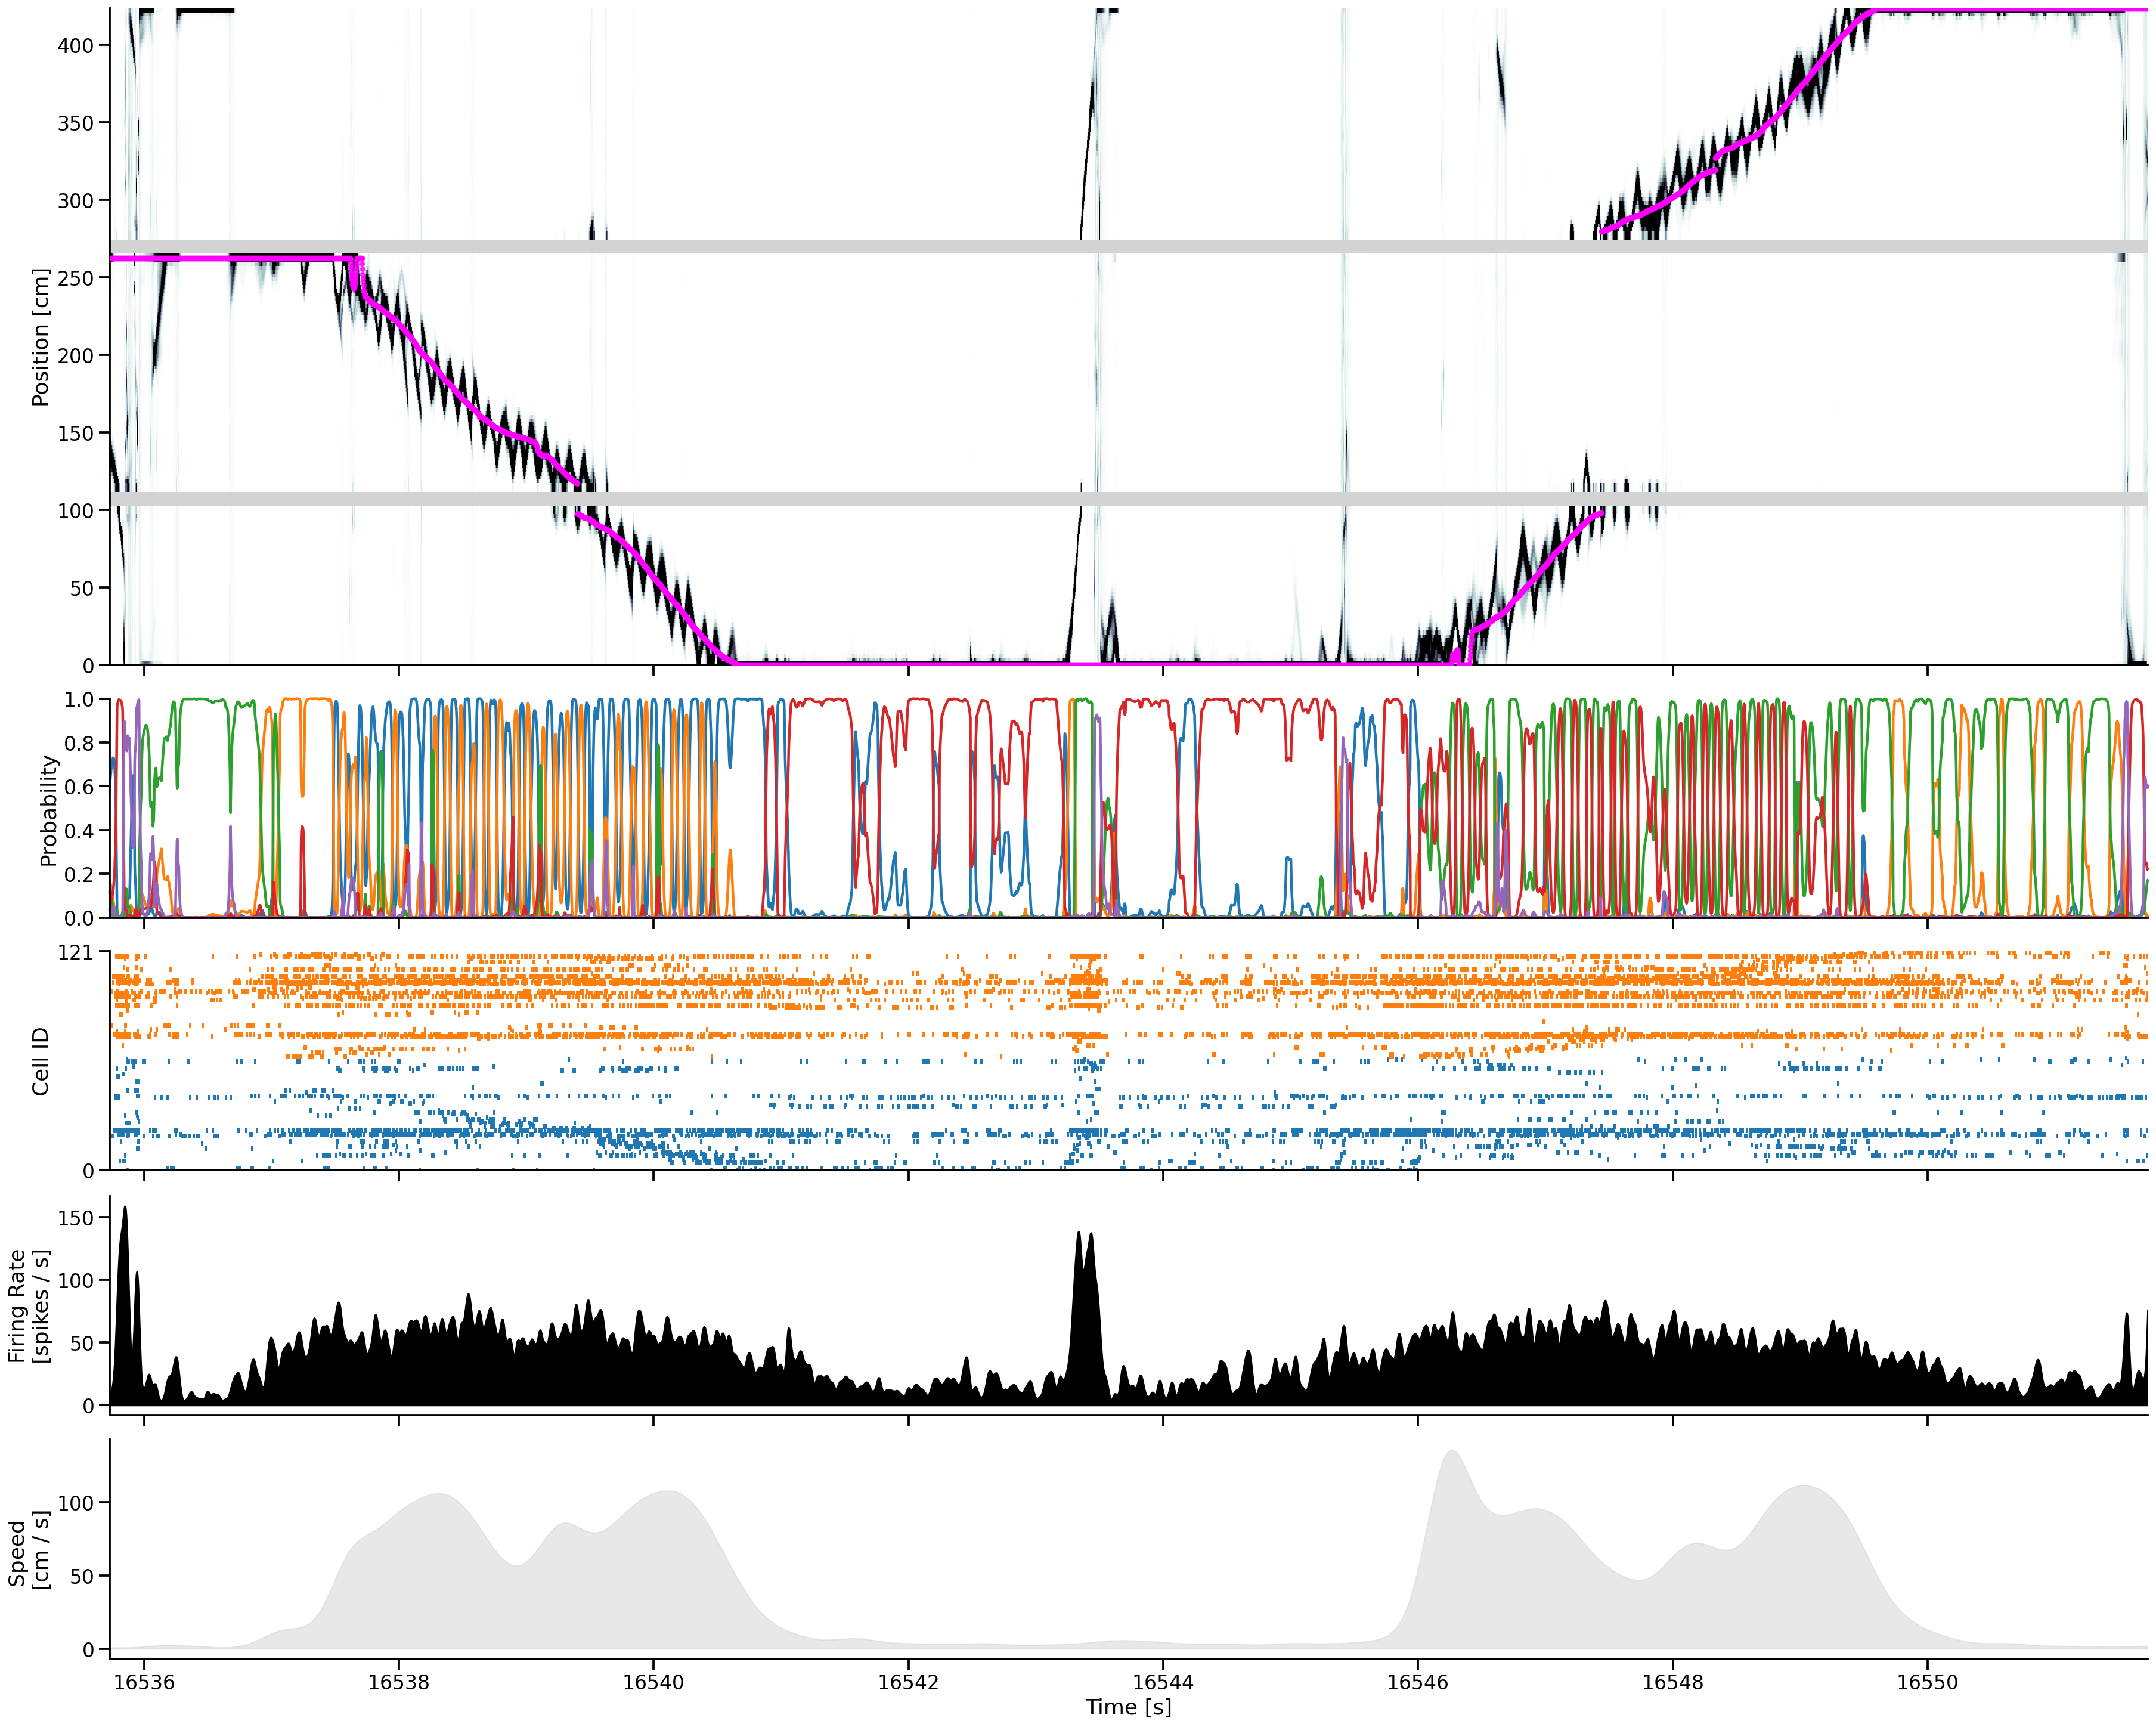

In [156]:
time_slice = spikes_results.time[slice(87_000, 95_000)]

plot_classifier_inbound_outbound_spikes(
    time_slice,
    cv_classifier,
    spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(25, 20),
    legend=False,
)

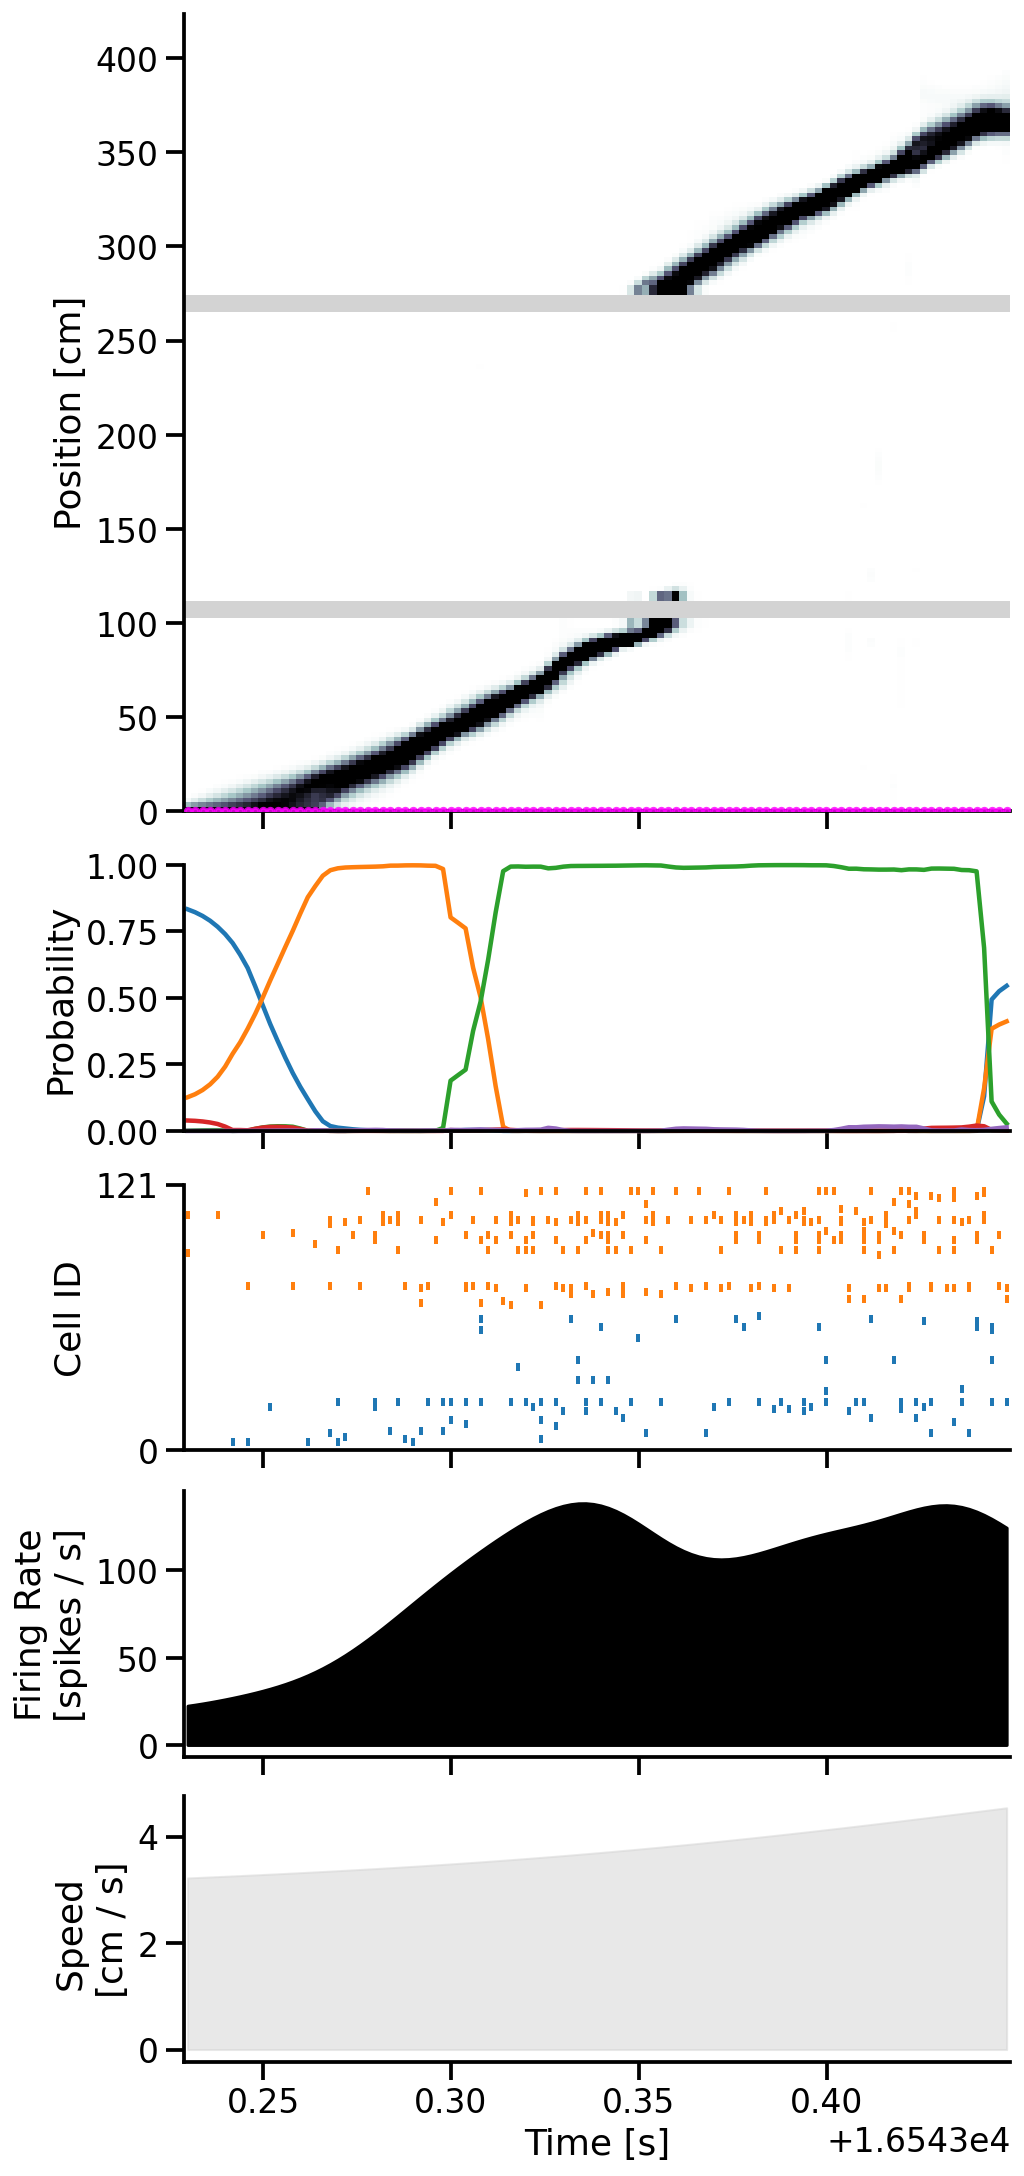

In [165]:
time_slice = spikes_results.time[slice(90_750, 90_860)]

plot_classifier_inbound_outbound_spikes(
    time_slice,
    cv_classifier,
    spikes_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(7, 15),
    legend=False,
)

# Clusterless

In [460]:
continuous_transition_types = [['random_walk_direction2', 'random_walk',            'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['random_walk',            'random_walk_direction1', 'uniform', 'random_walk',            'random_walk',            'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk_direction1', 'random_walk',            'uniform'],
                               ['random_walk',            'random_walk',            'uniform', 'random_walk',            'random_walk_direction2', 'uniform'],
                               ['uniform',                'uniform',                'uniform', 'uniform',                'uniform',                'uniform'],
                               ]
encoding_group_to_state = ['Inbound', 'Inbound', 'Inbound', 'Outbound', 'Outbound', 'Outbound']

# use identity instead of random walk at transition?
# exclude diagonal of random walk?


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

notnull = pd.notnull(data["position_info"].task)

from replay_trajectory_classification import ClusterlessClassifier

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

state_names = ['Inbound-Forward', 'Inbound-Reverse', 'Inbound-Fragmented',
               'Outbound-Forward', 'Outbound-Reverse', 'Outbound-Fragmented']
cv = KFold()

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    cv_classifier = ClusterlessClassifier(**classifier_parameters)
    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=notnull.iloc[train],
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
        encoding_group_labels=inbound_outbound_labels[train],
        encoding_group_to_state=encoding_group_to_state
    )

In [388]:
classified_states = []
is_state = []

for ripple_number in data['ripple_times'].index:
    ripple = data['ripple_times'].loc[ripple_number]

    start_time = ripple.start_time
    end_time = ripple.end_time

    probability = get_probability_of_state(
                    clusterless_results.sel(time=slice(start_time / np.timedelta64(1, 's'),
                                                  end_time / np.timedelta64(1, 's'))))
    _, classified_states_temp, is_state_temp = classify_states(probability)
    classified_states.append(classified_states_temp)
    is_state.append(is_state_temp)
    
is_state = np.stack(is_state)
is_state = pd.DataFrame(is_state, columns=probability.state, index=data['ripple_times'].index)

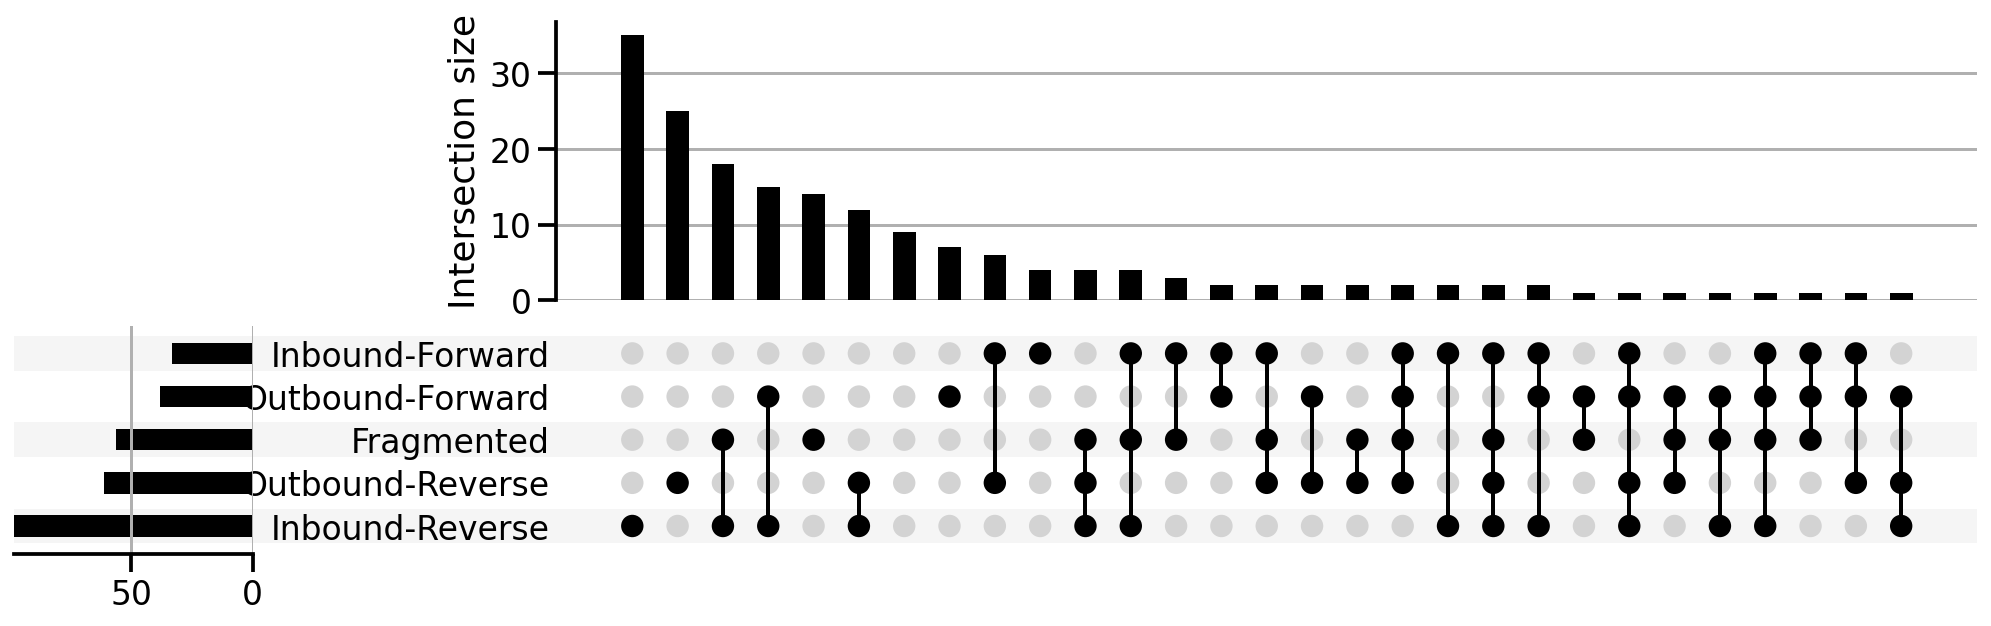

In [389]:
from upsetplot import UpSet

UpSet(is_state.reset_index(drop=True).set_index(probability.state.values.tolist()),
      sort_by='cardinality',
      show_percentages=False,
      totals_plot_elements=5
     )

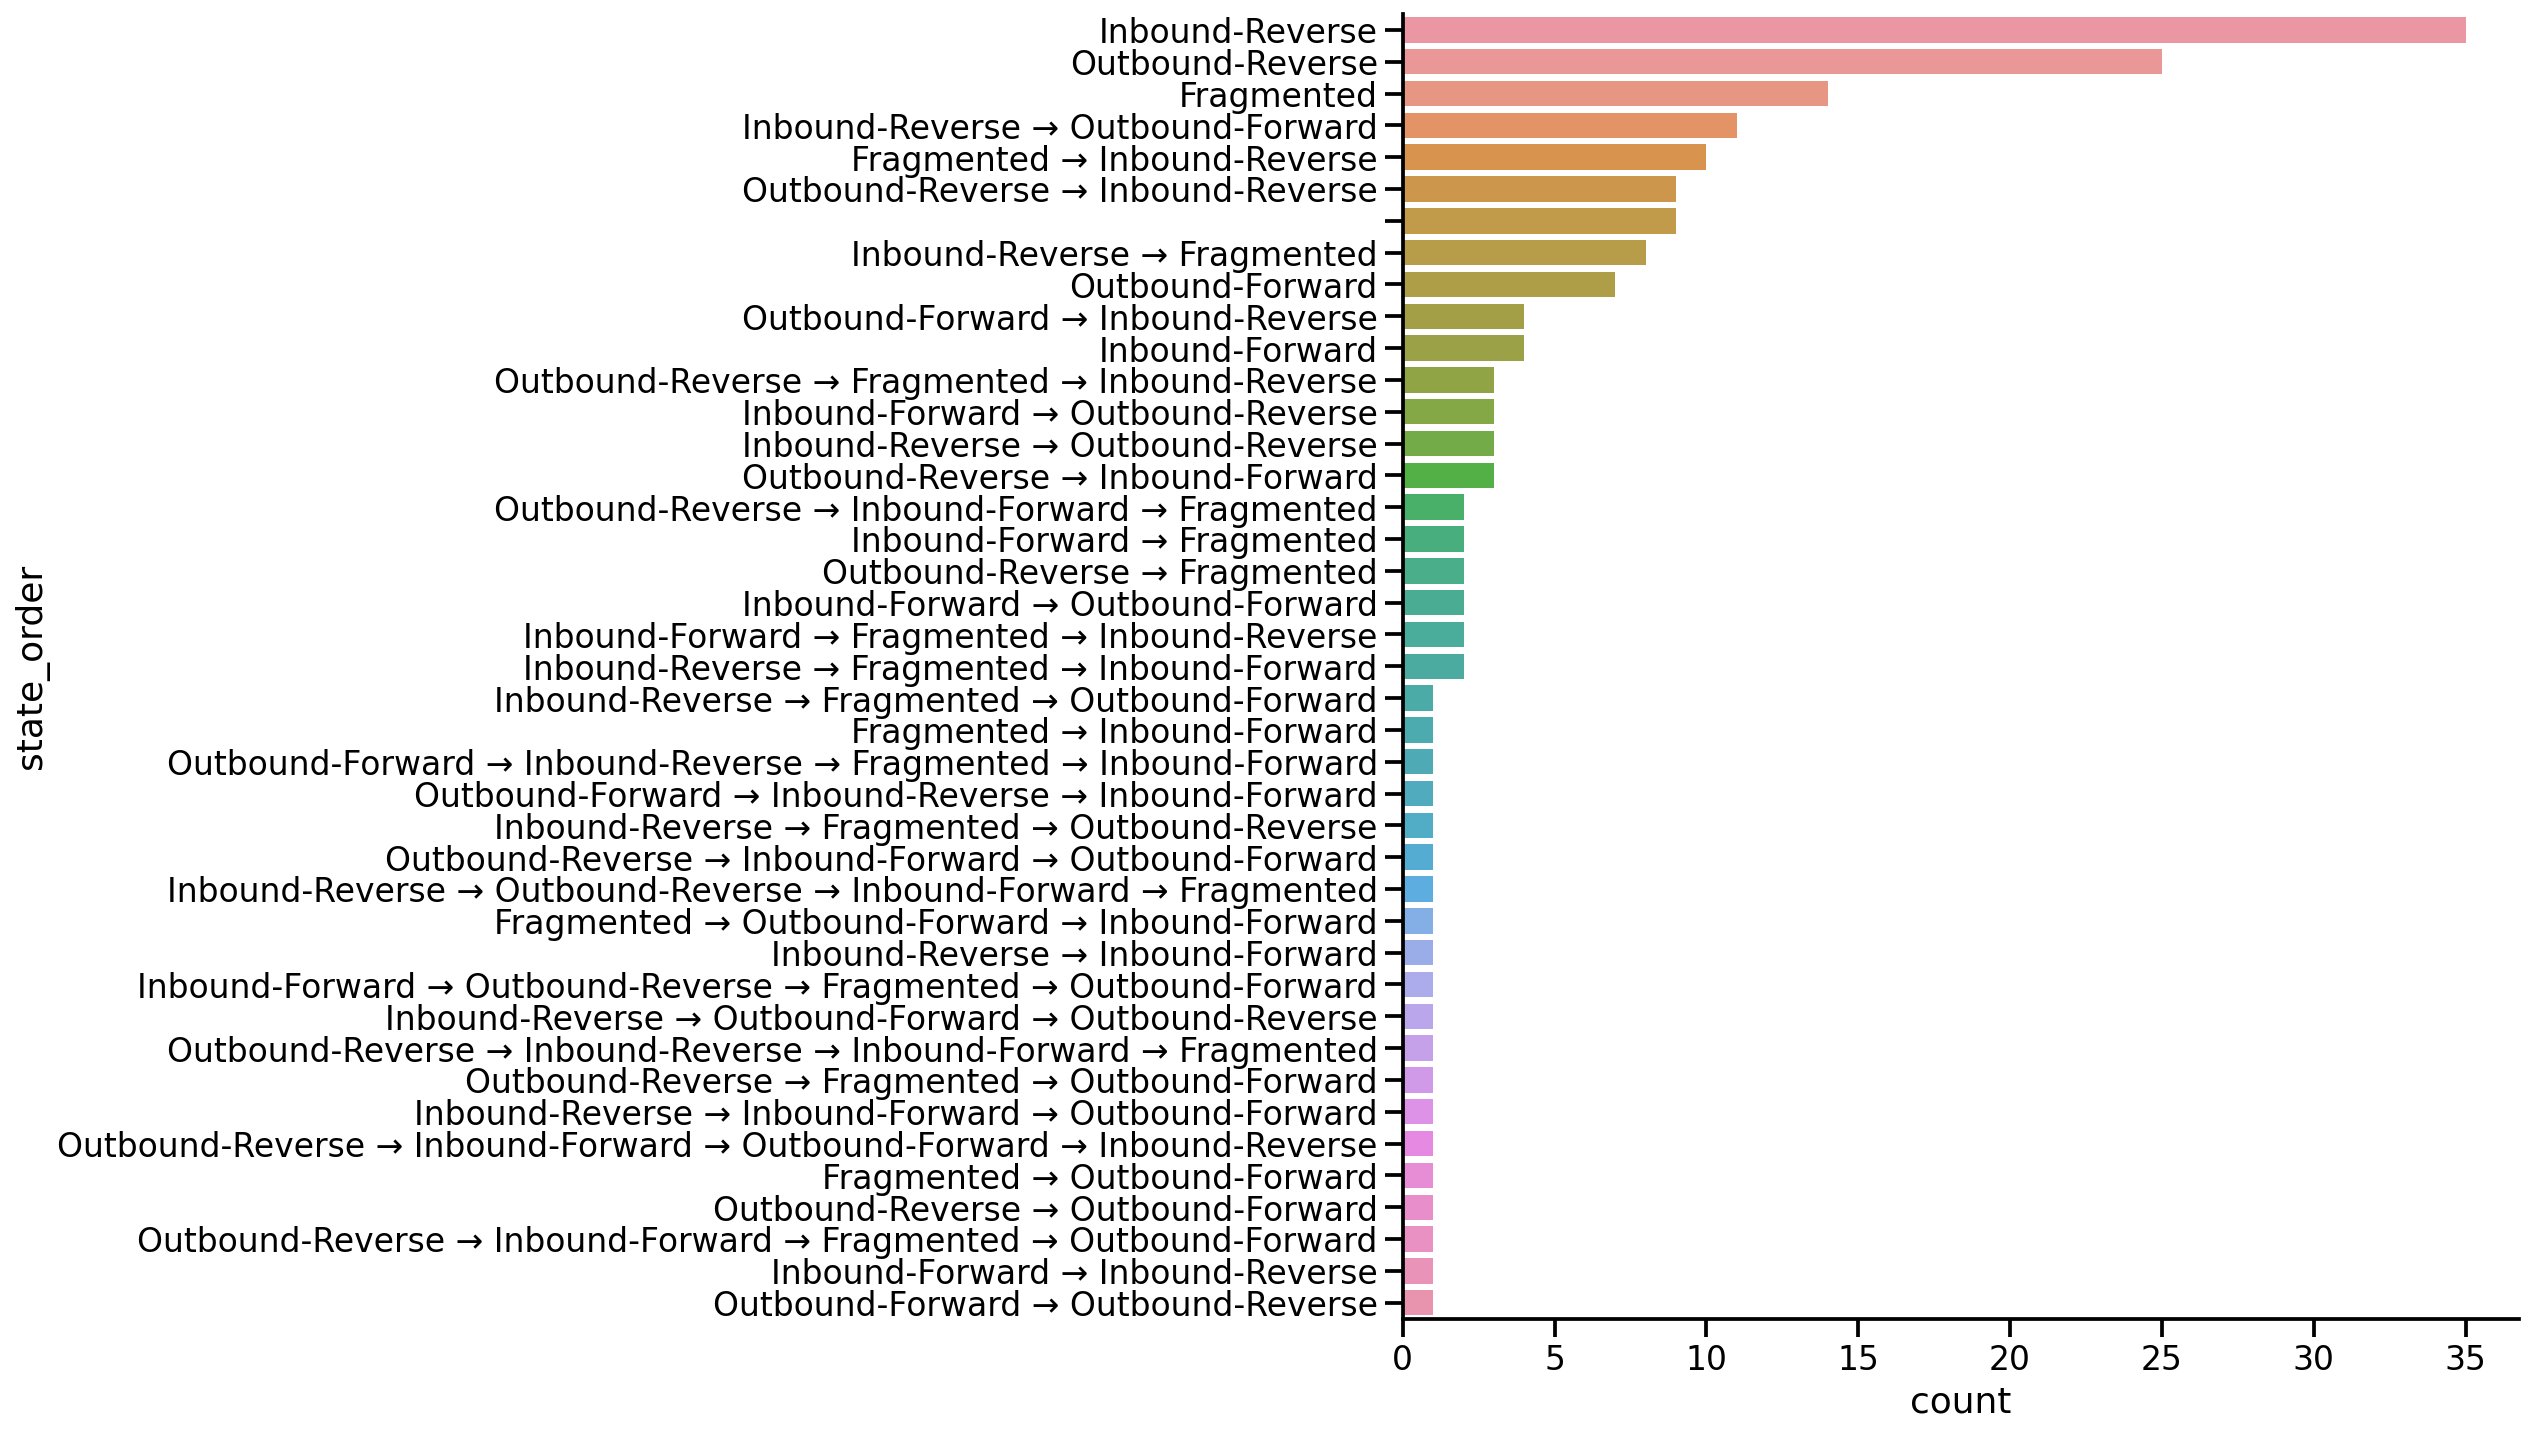

In [392]:
fig, ax = plt.subplots(figsize=(10, 12))
state_order = pd.DataFrame([' → '.join(states) for states in classified_states], columns=['state_order'])
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()

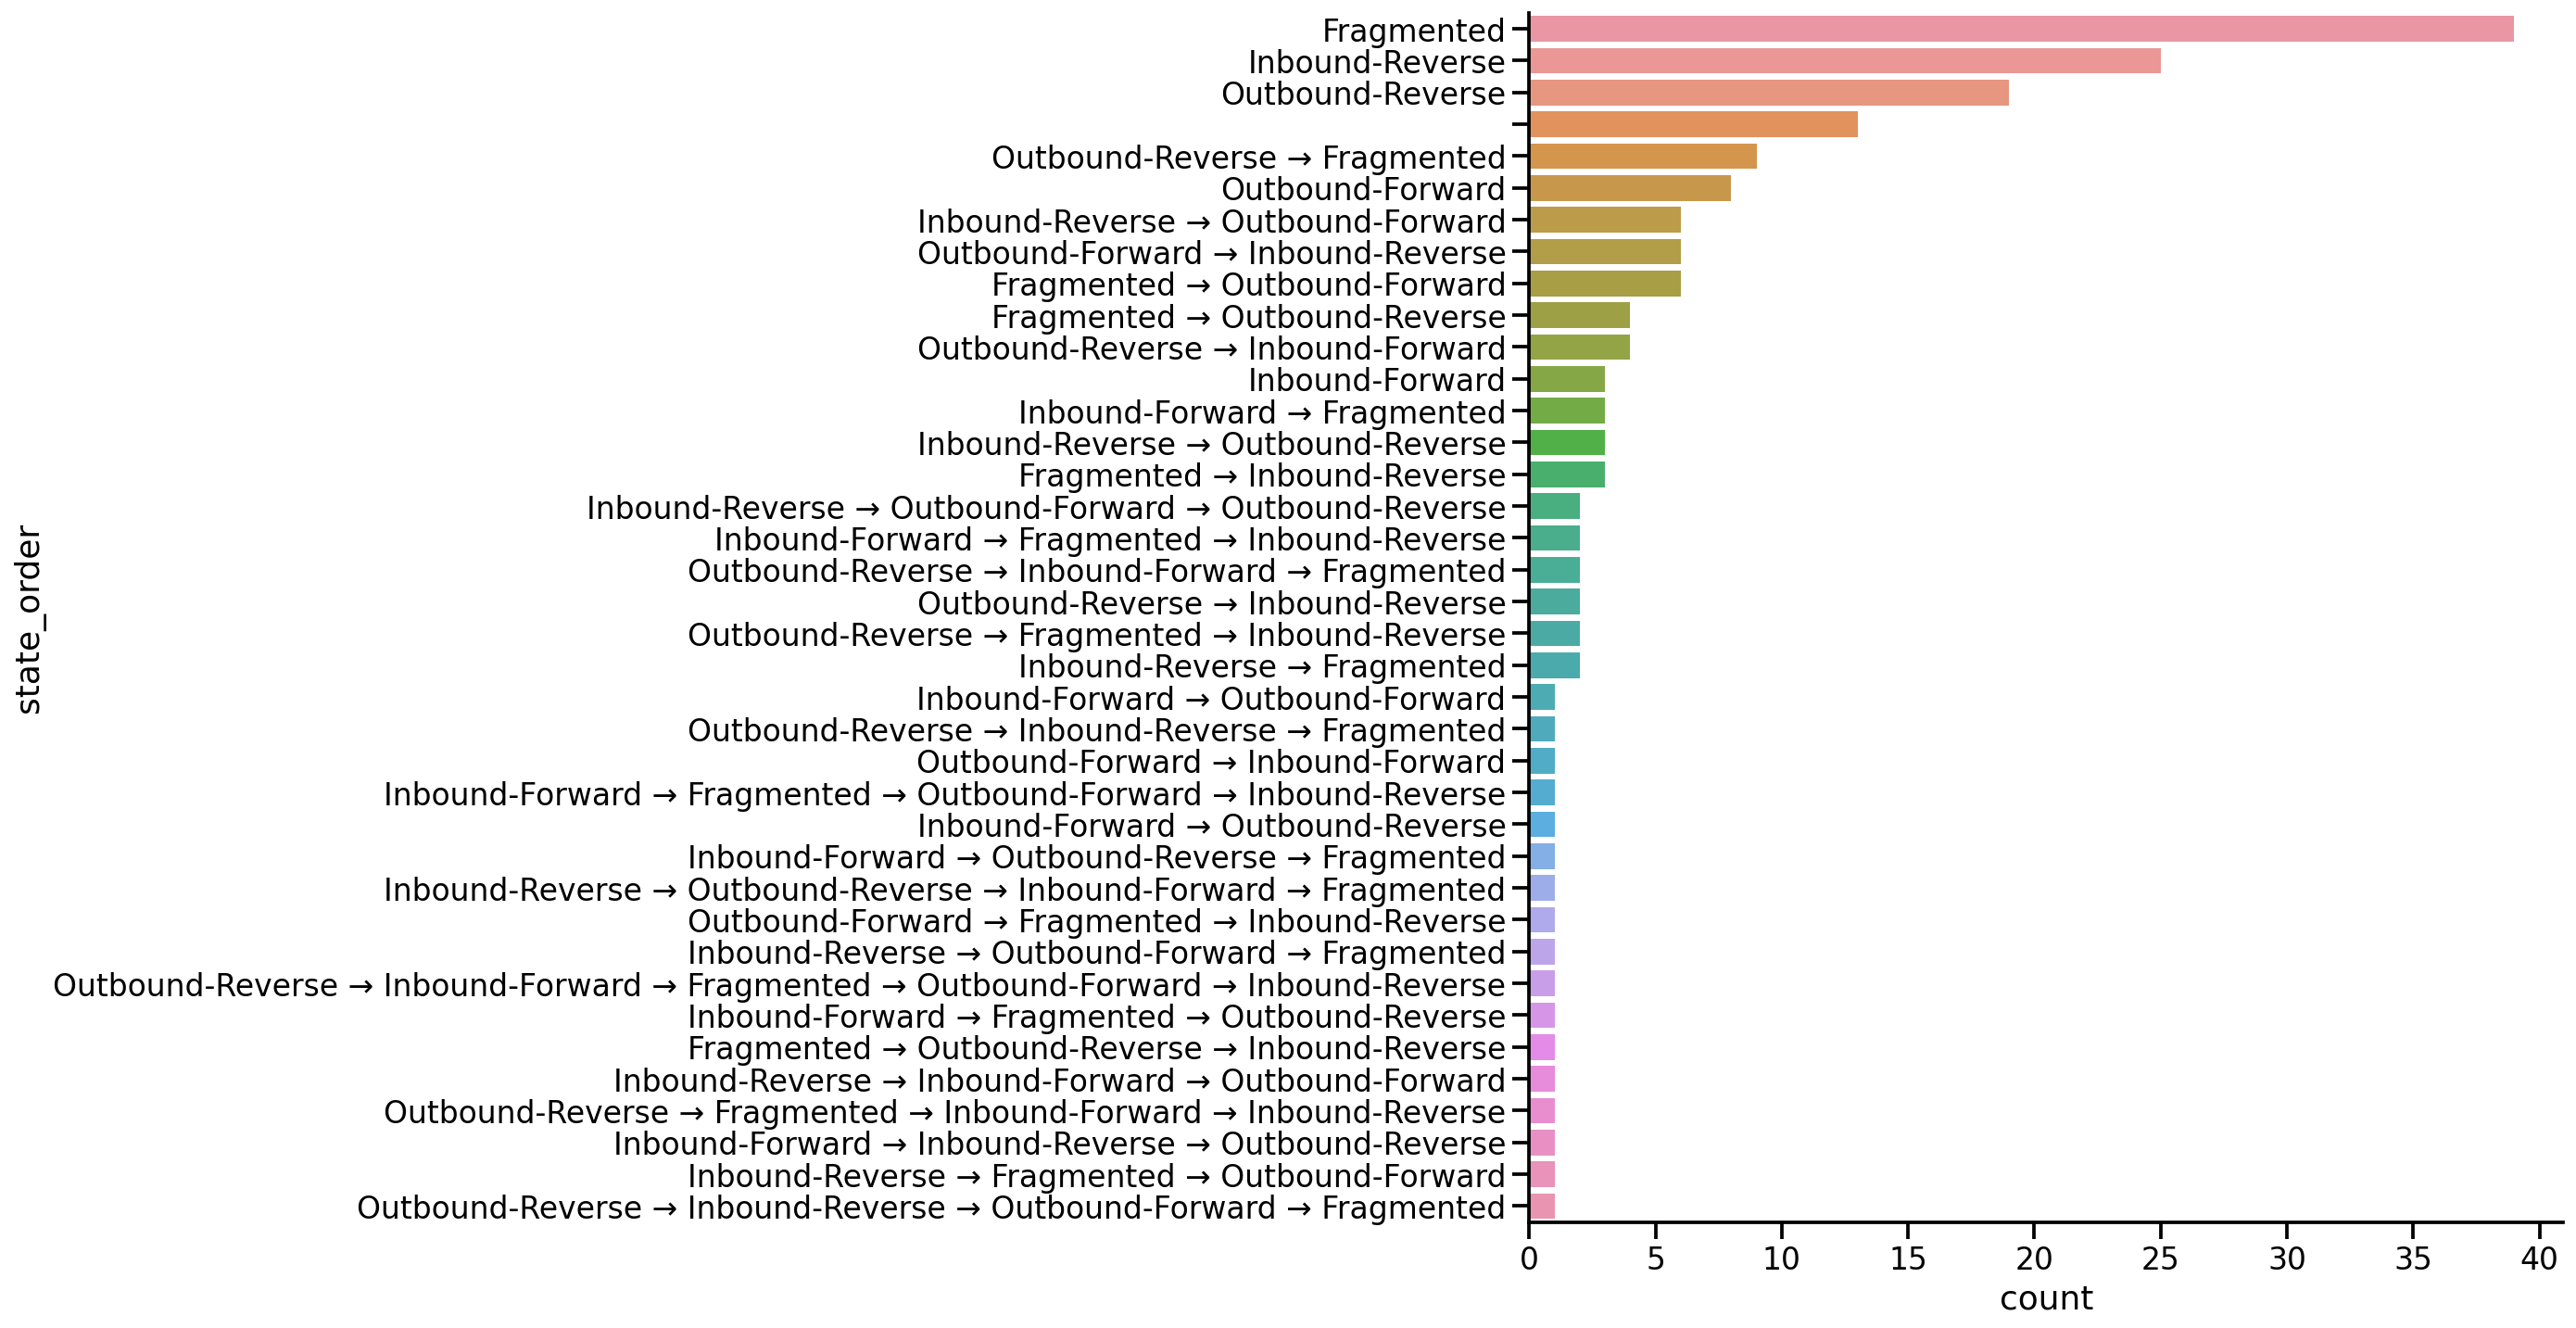

In [436]:
fig, ax = plt.subplots(figsize=(10, 12))
state_order = pd.DataFrame([' → '.join(states) for states in classified_states],
                           columns=['state_order'],
                           index=data['ripple_times'].index)
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()

In [448]:
state_order.head(10)

state_order
replay_number                                                   
1                                   Inbound-Reverse → Fragmented
2                                                Inbound-Reverse
3                Inbound-Forward → Fragmented → Outbound-Reverse
4                                                     Fragmented
5                                                Inbound-Reverse
6                                   Inbound-Reverse → Fragmented
7                                                Inbound-Reverse
8                             Inbound-Reverse → Outbound-Forward
9                                               Outbound-Reverse
10             Inbound-Reverse → Outbound-Reverse → Inbound-F...

In [443]:
state_order.iloc[(state_order == 'Inbound-Reverse').values]

state_order
replay_number                 
2              Inbound-Reverse
5              Inbound-Reverse
7              Inbound-Reverse
16             Inbound-Reverse
19             Inbound-Reverse
23             Inbound-Reverse
27             Inbound-Reverse
42             Inbound-Reverse
47             Inbound-Reverse
67             Inbound-Reverse
72             Inbound-Reverse
81             Inbound-Reverse
92             Inbound-Reverse
98             Inbound-Reverse
102            Inbound-Reverse
113            Inbound-Reverse
116            Inbound-Reverse
117            Inbound-Reverse
128            Inbound-Reverse
140            Inbound-Reverse
143            Inbound-Reverse
144            Inbound-Reverse
145            Inbound-Reverse
168            Inbound-Reverse
178            Inbound-Reverse

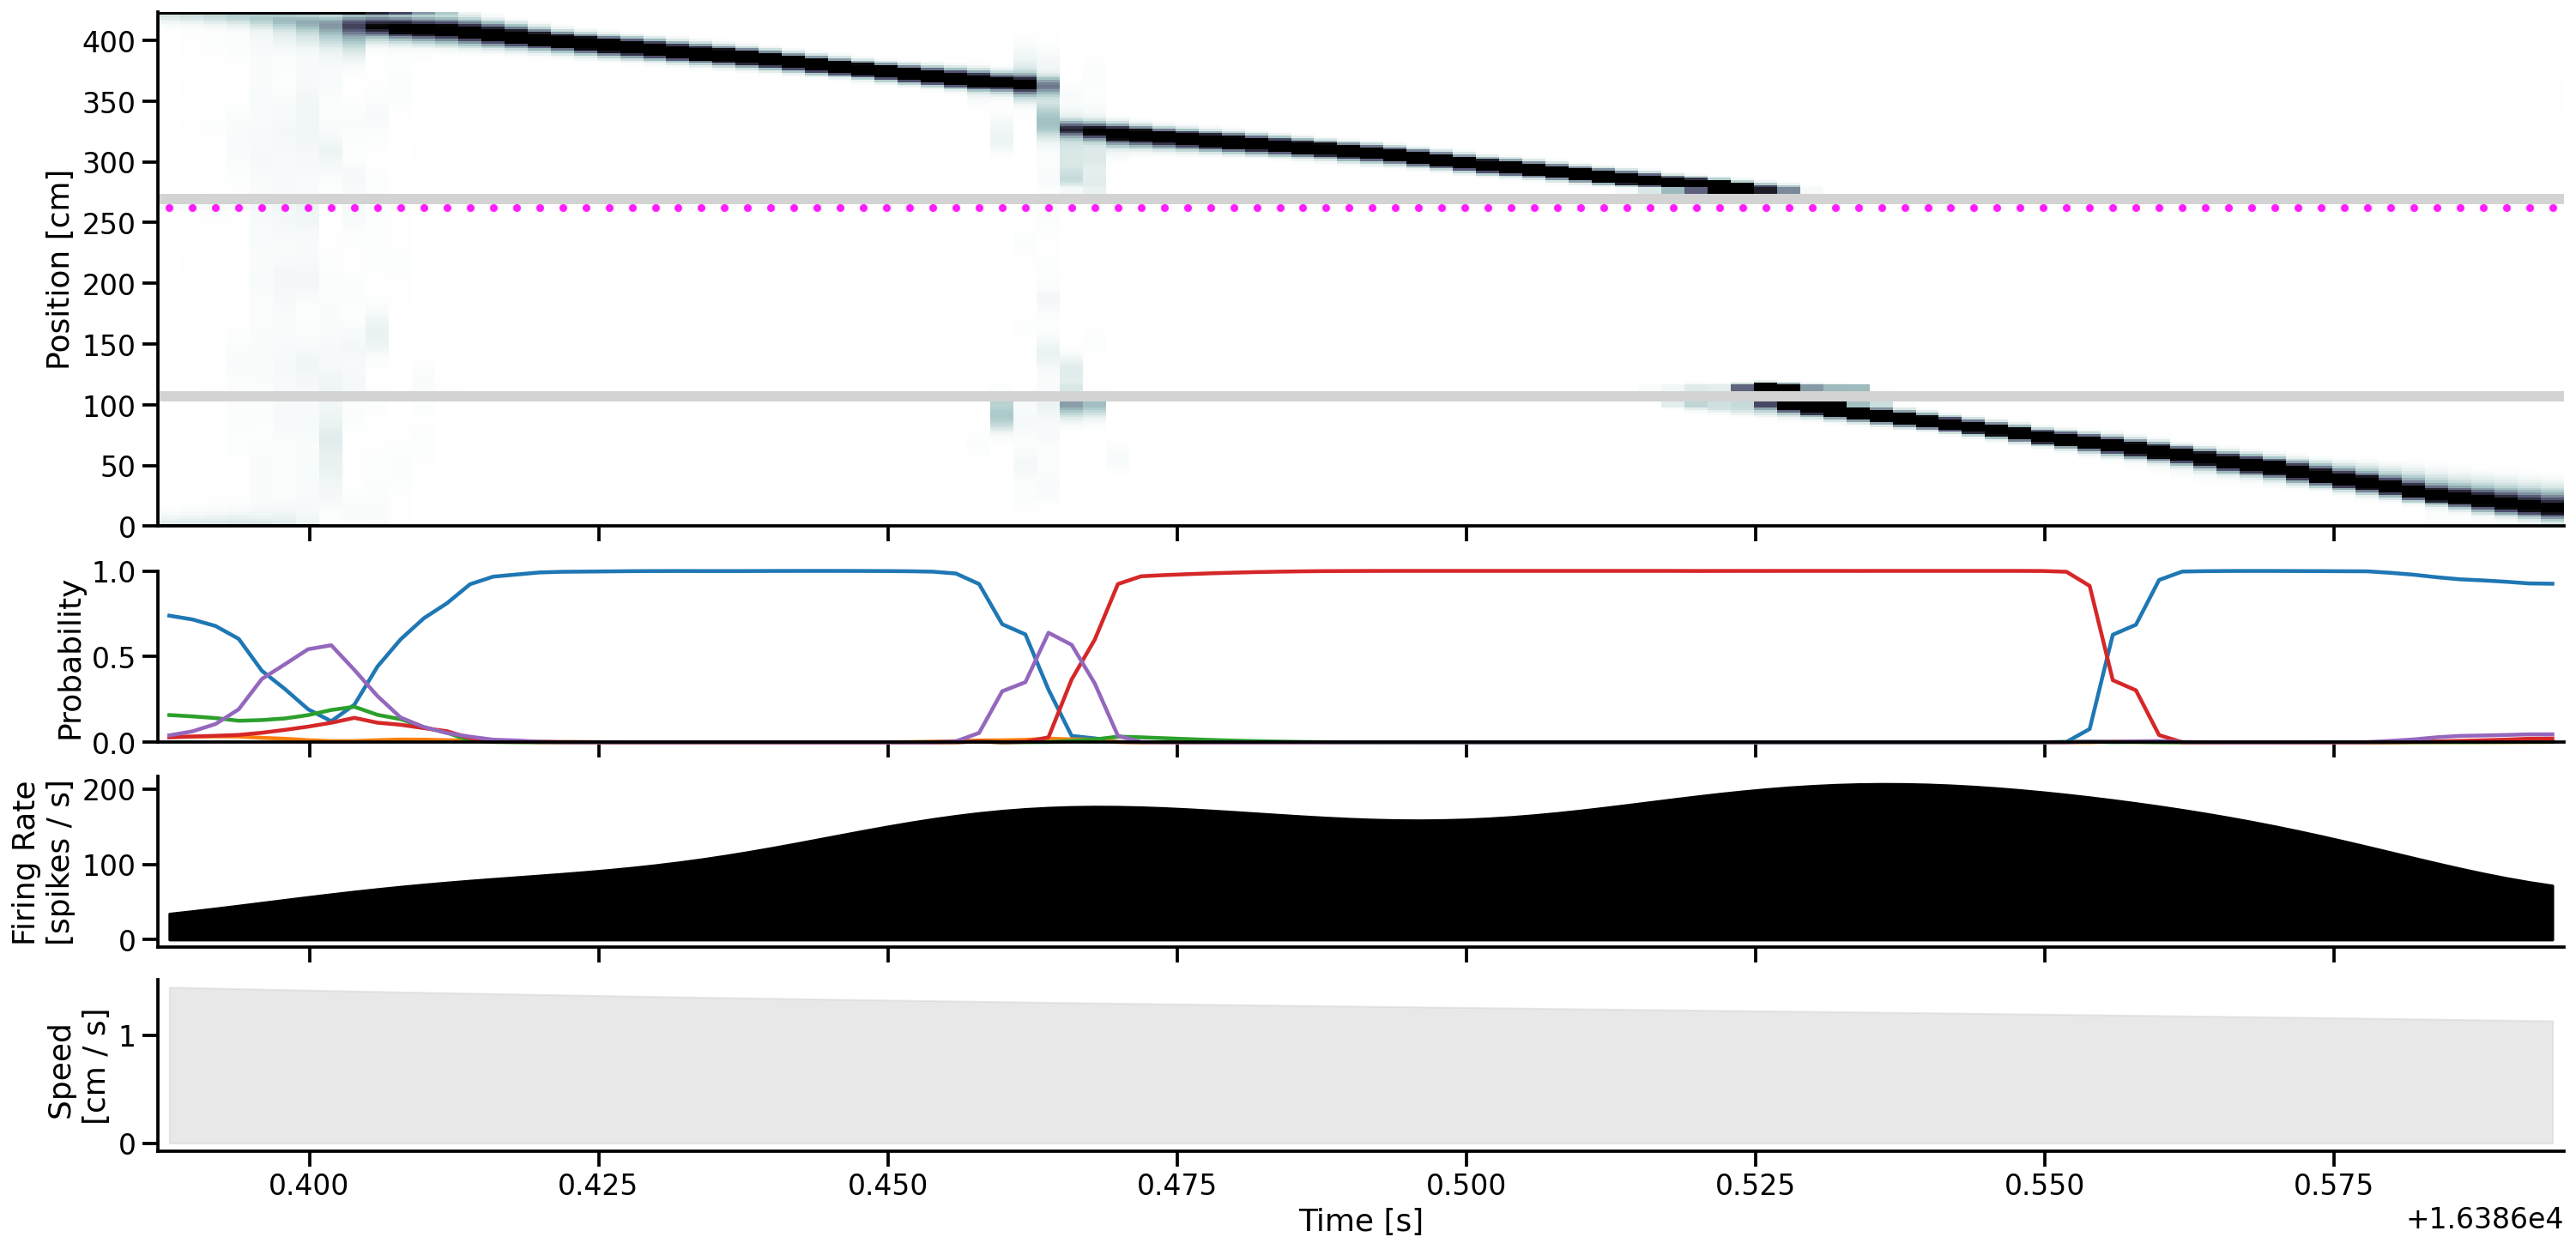

In [518]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 3
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

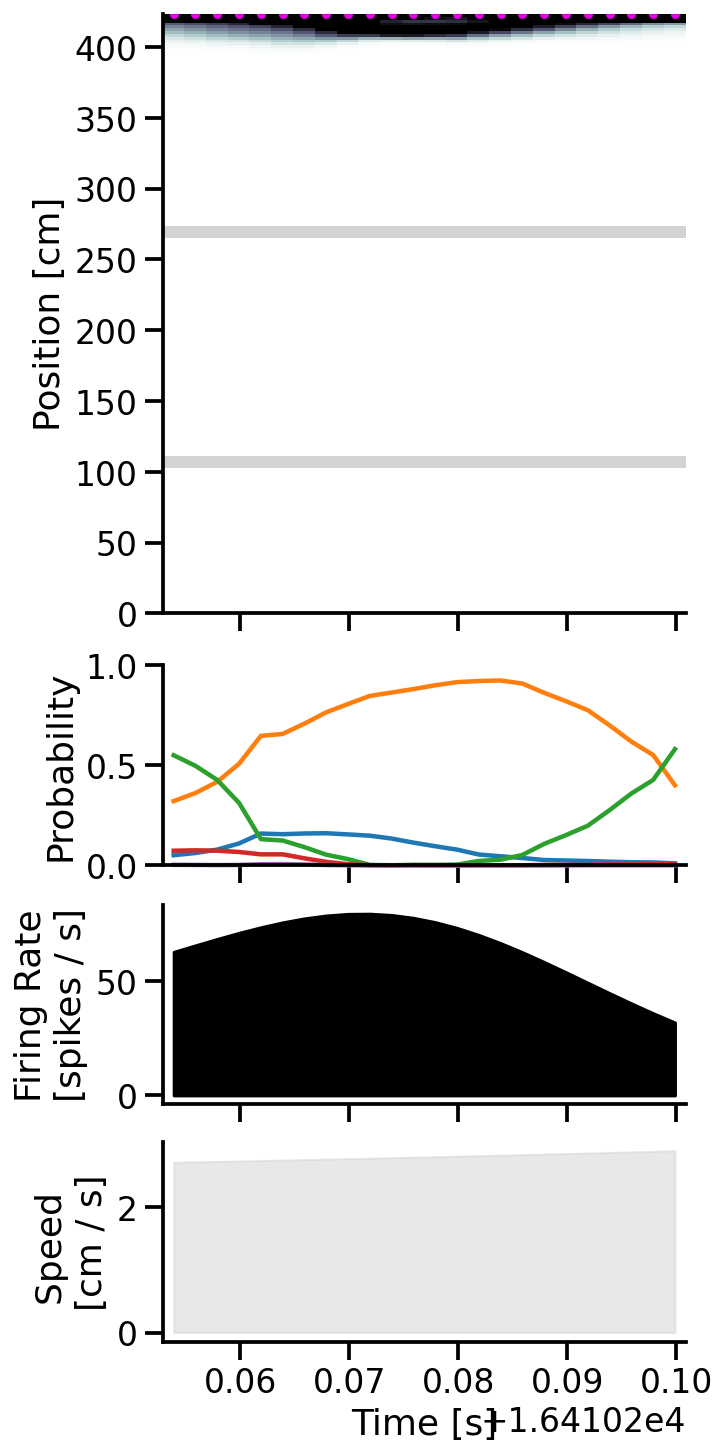

In [519]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 5
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

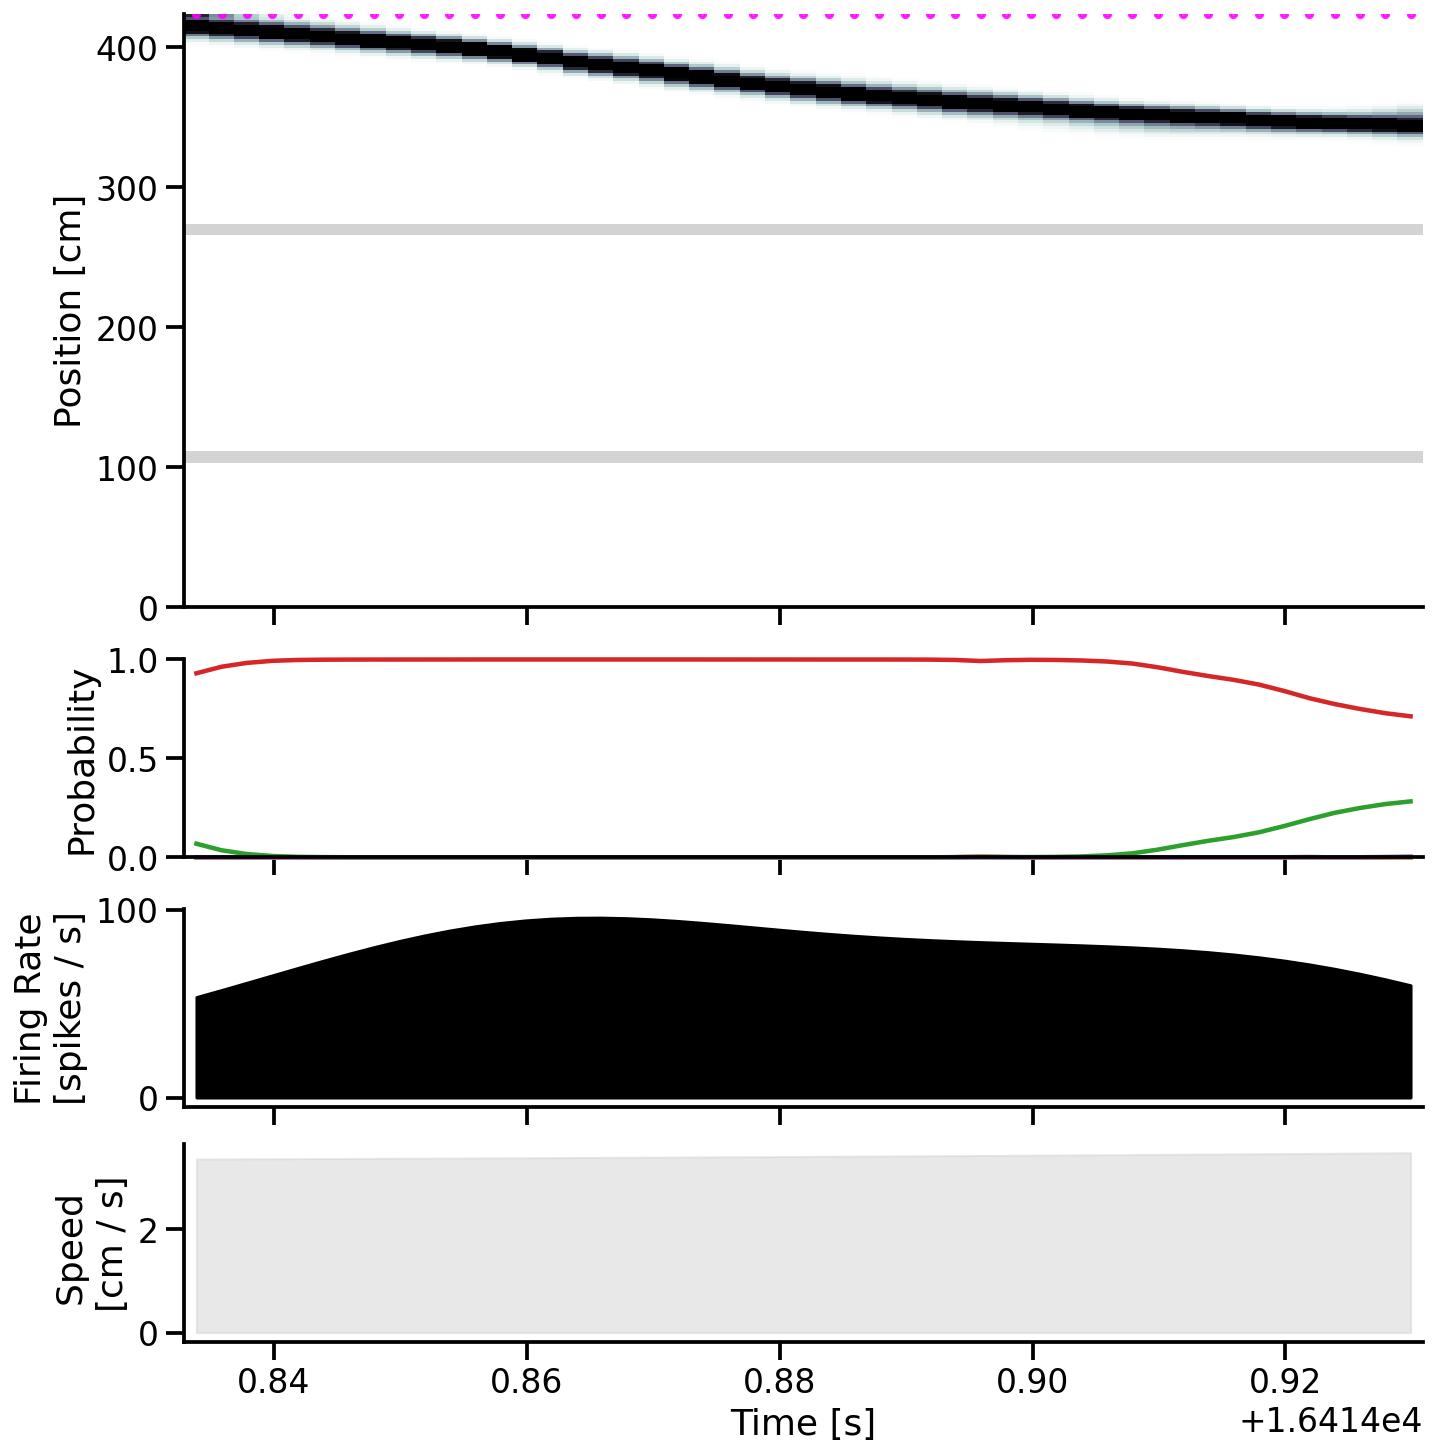

In [520]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 9
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

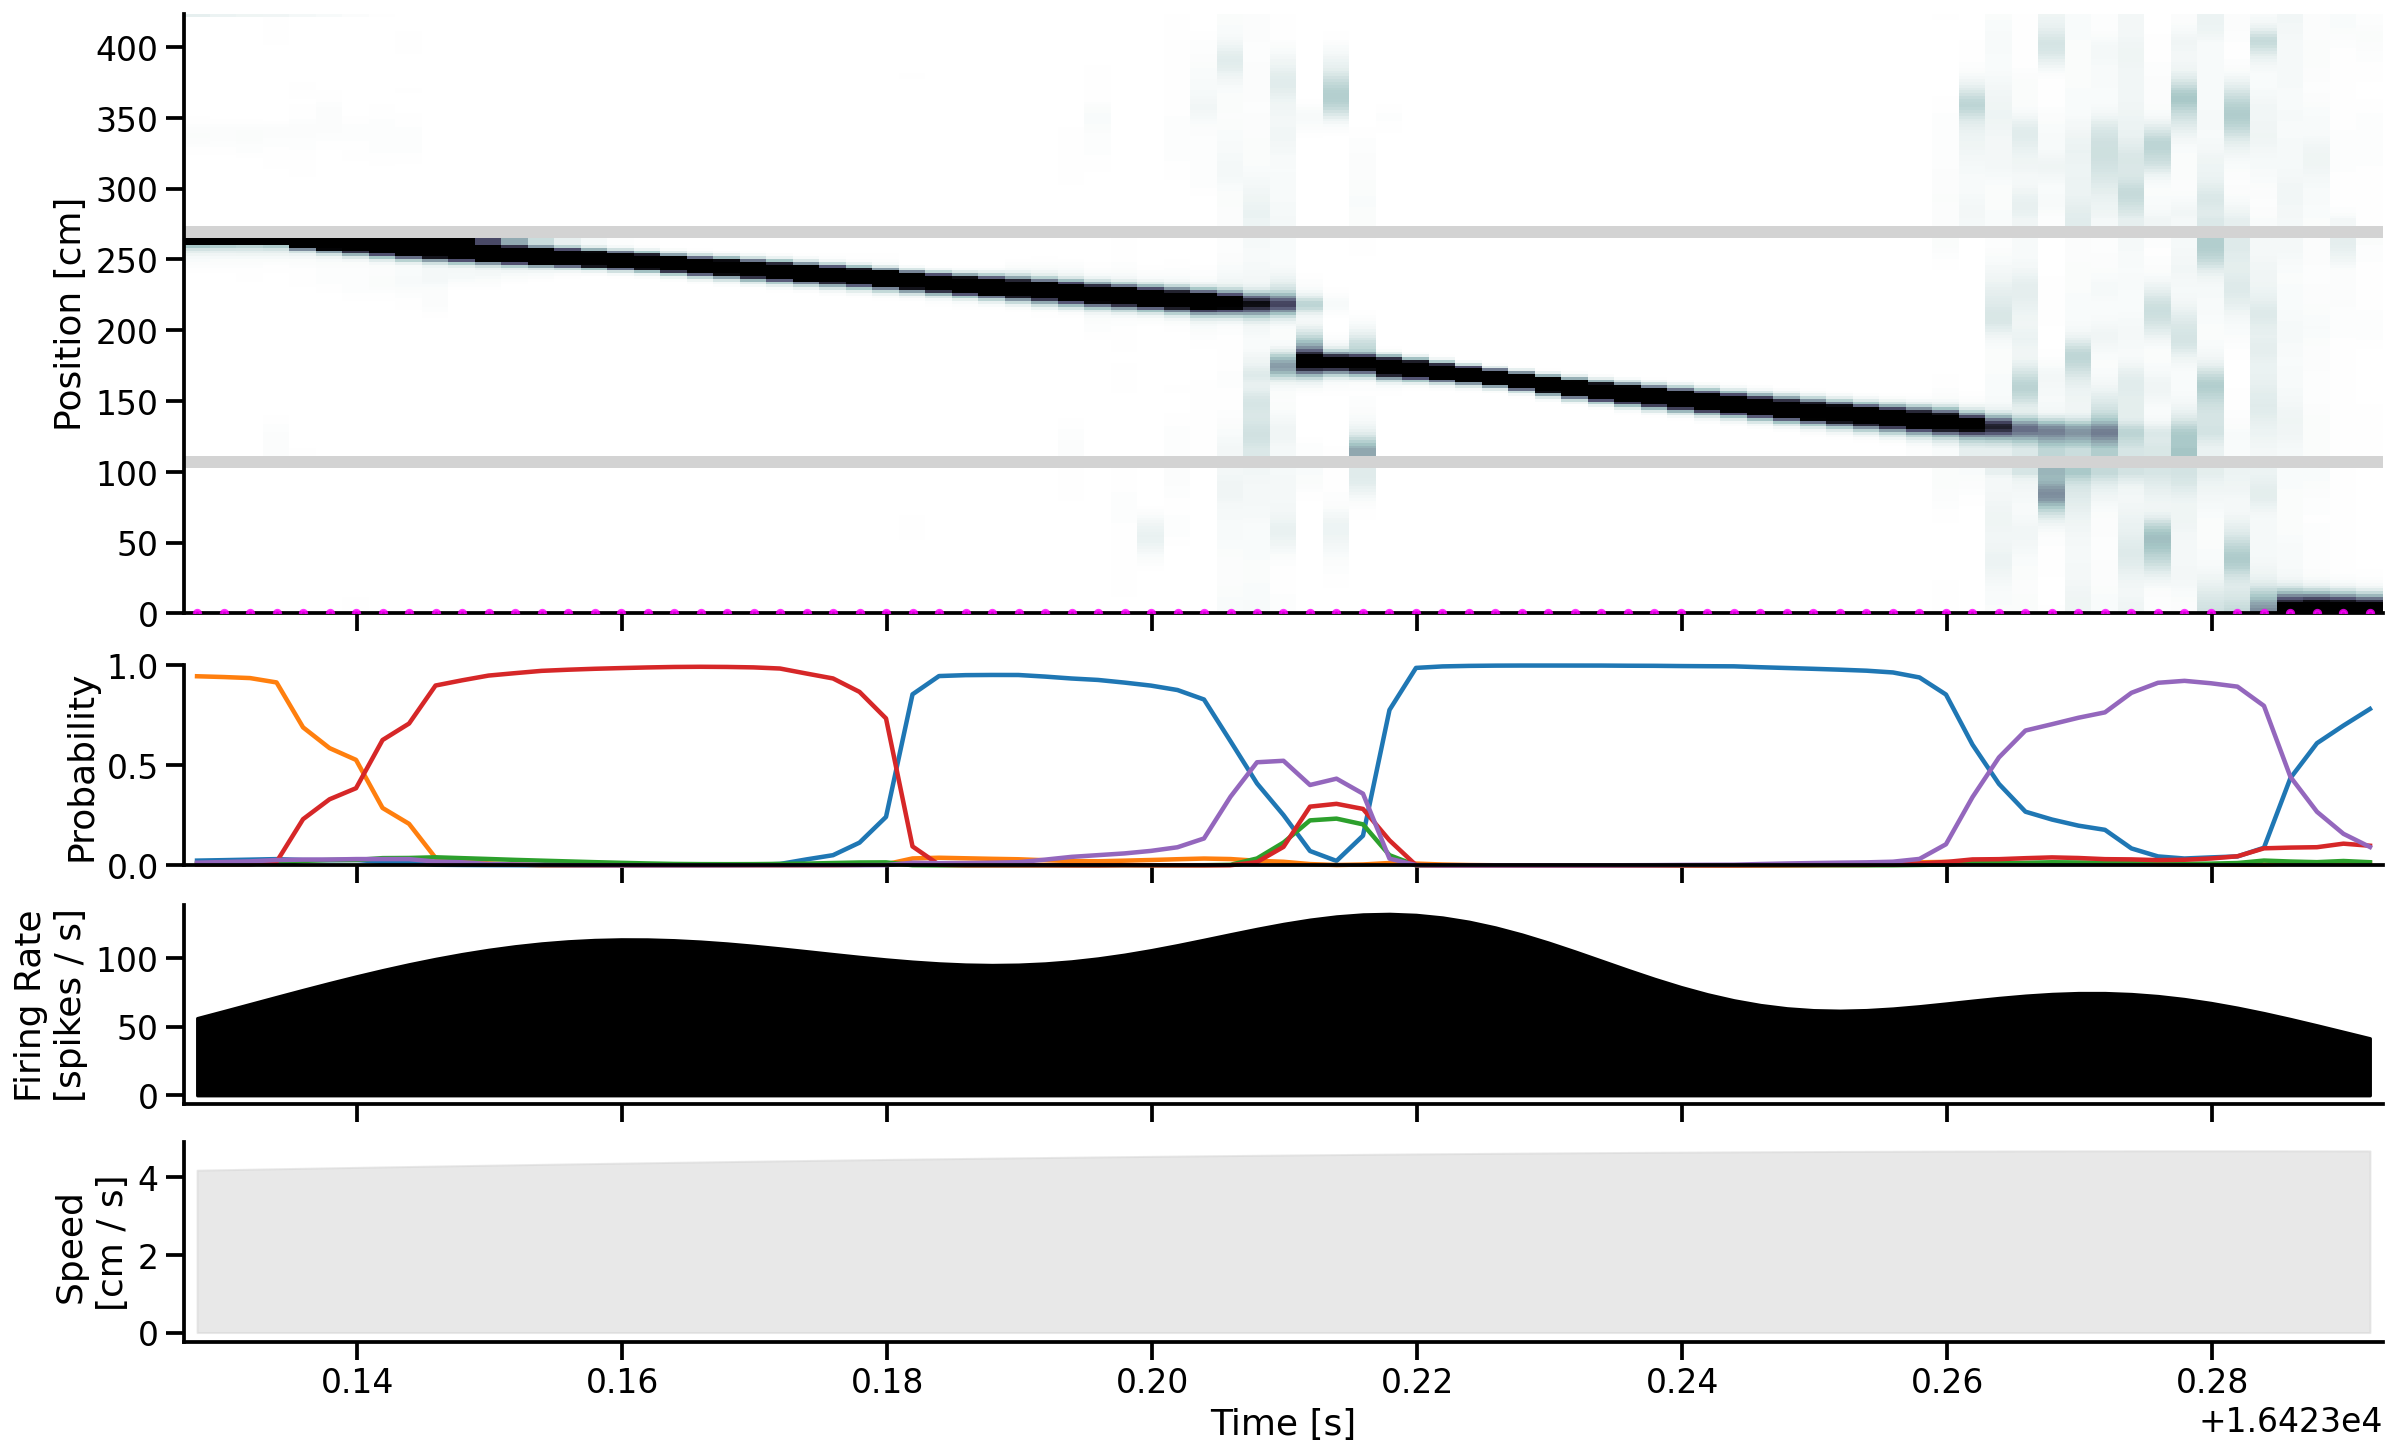

In [521]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 10
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

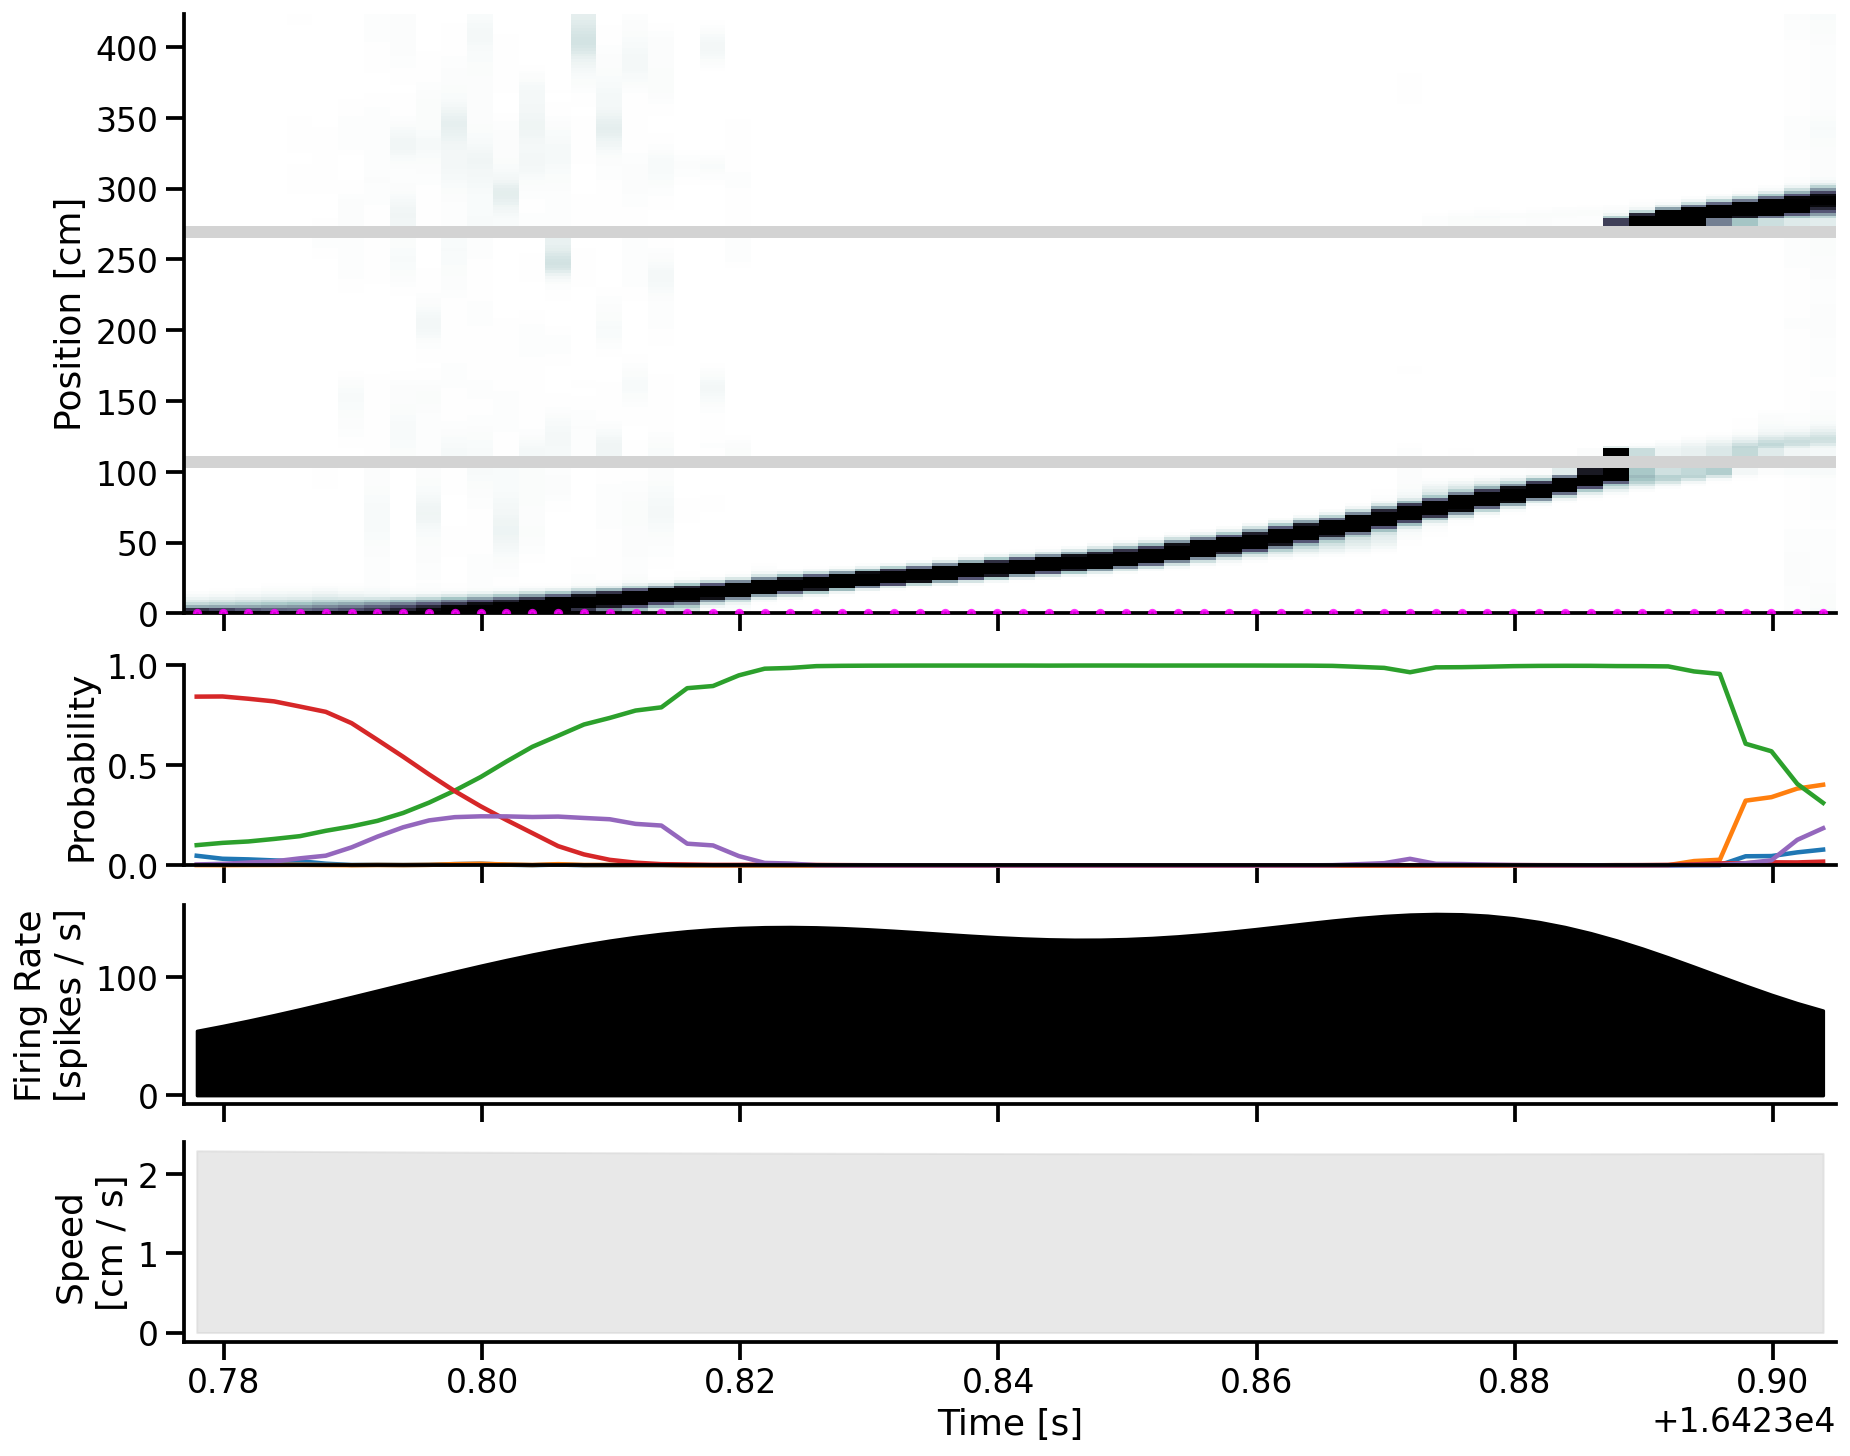

In [522]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 11
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

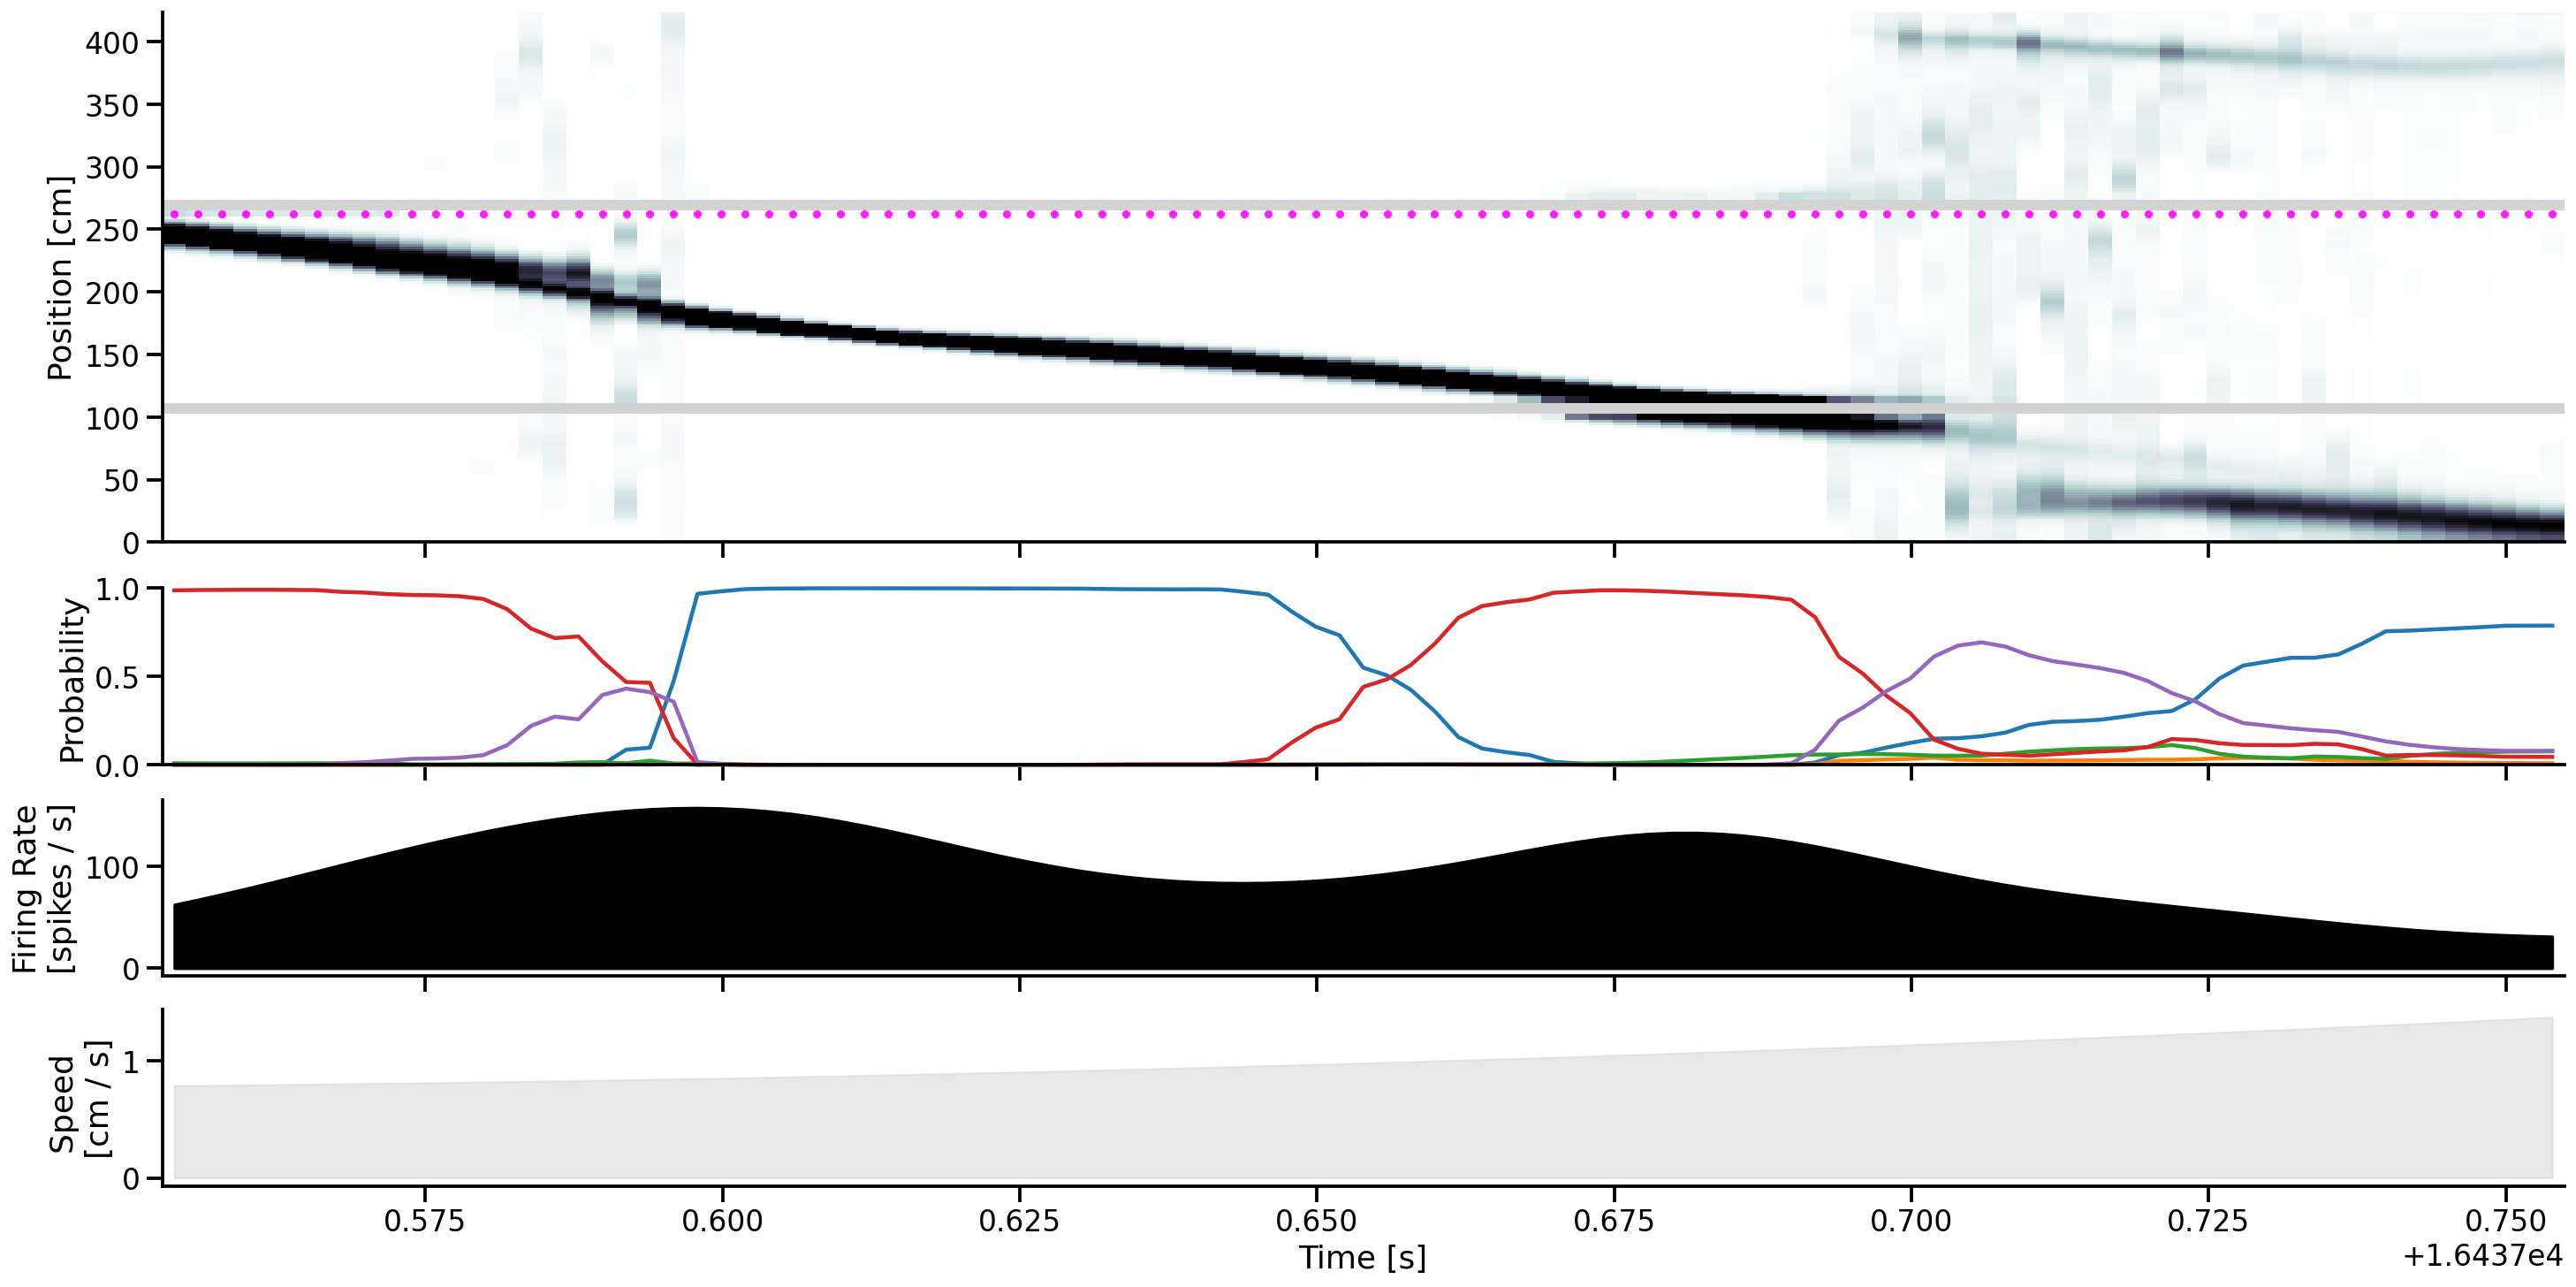

In [524]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 17
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

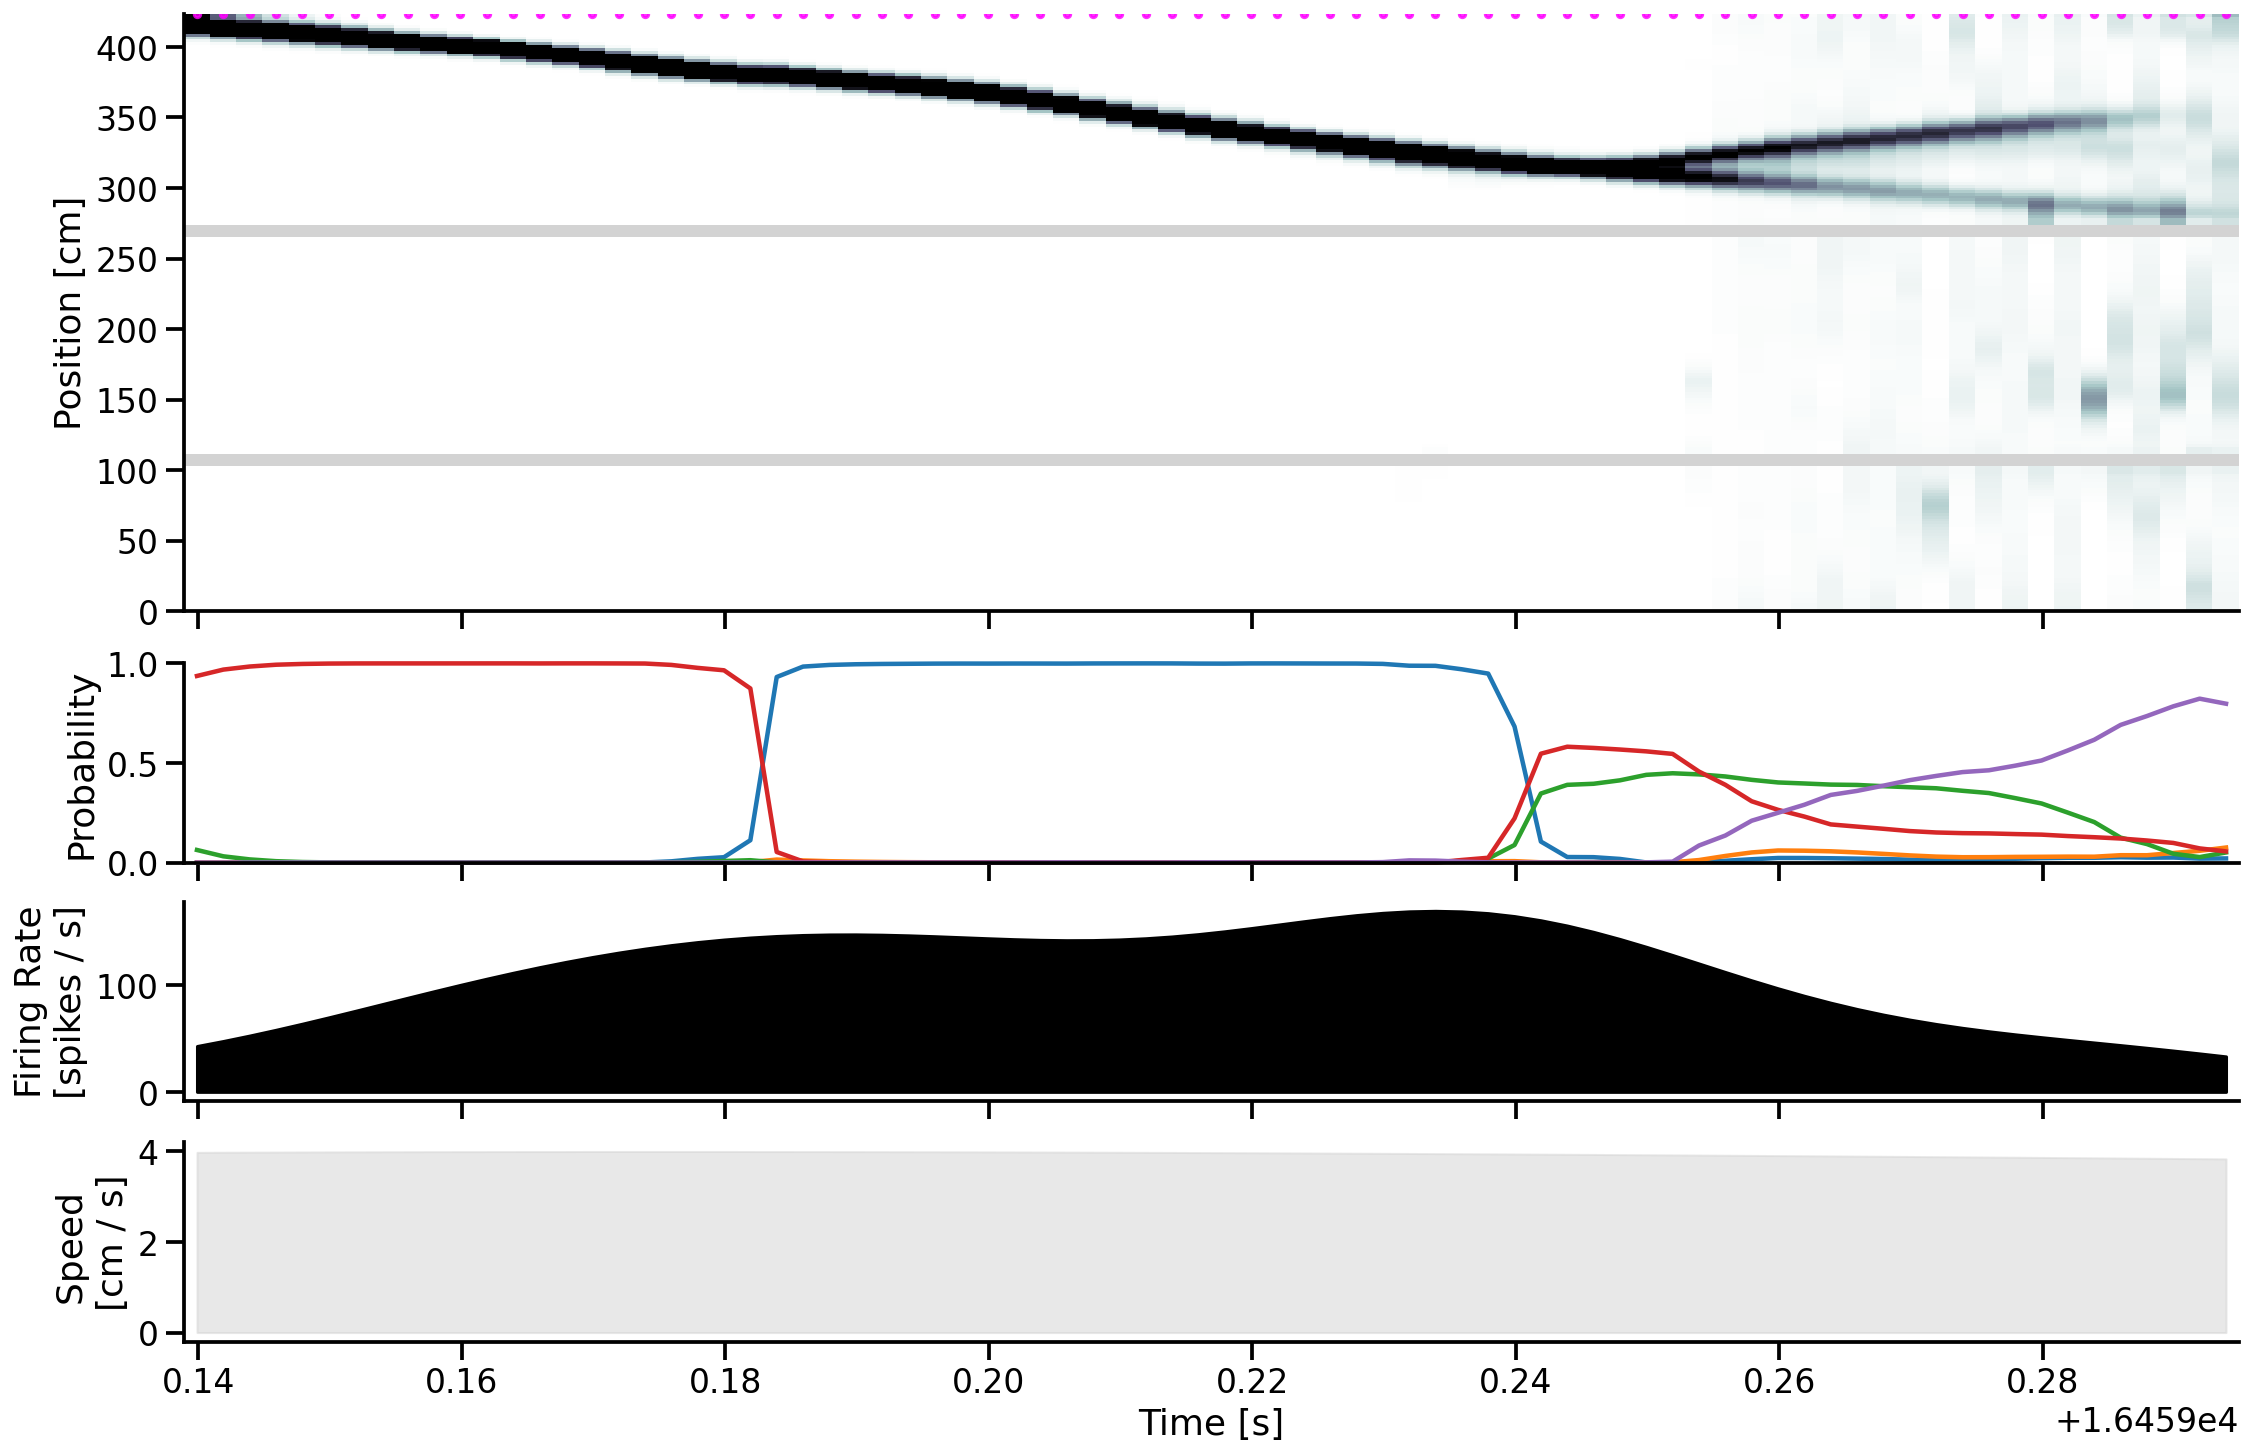

In [527]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 20
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

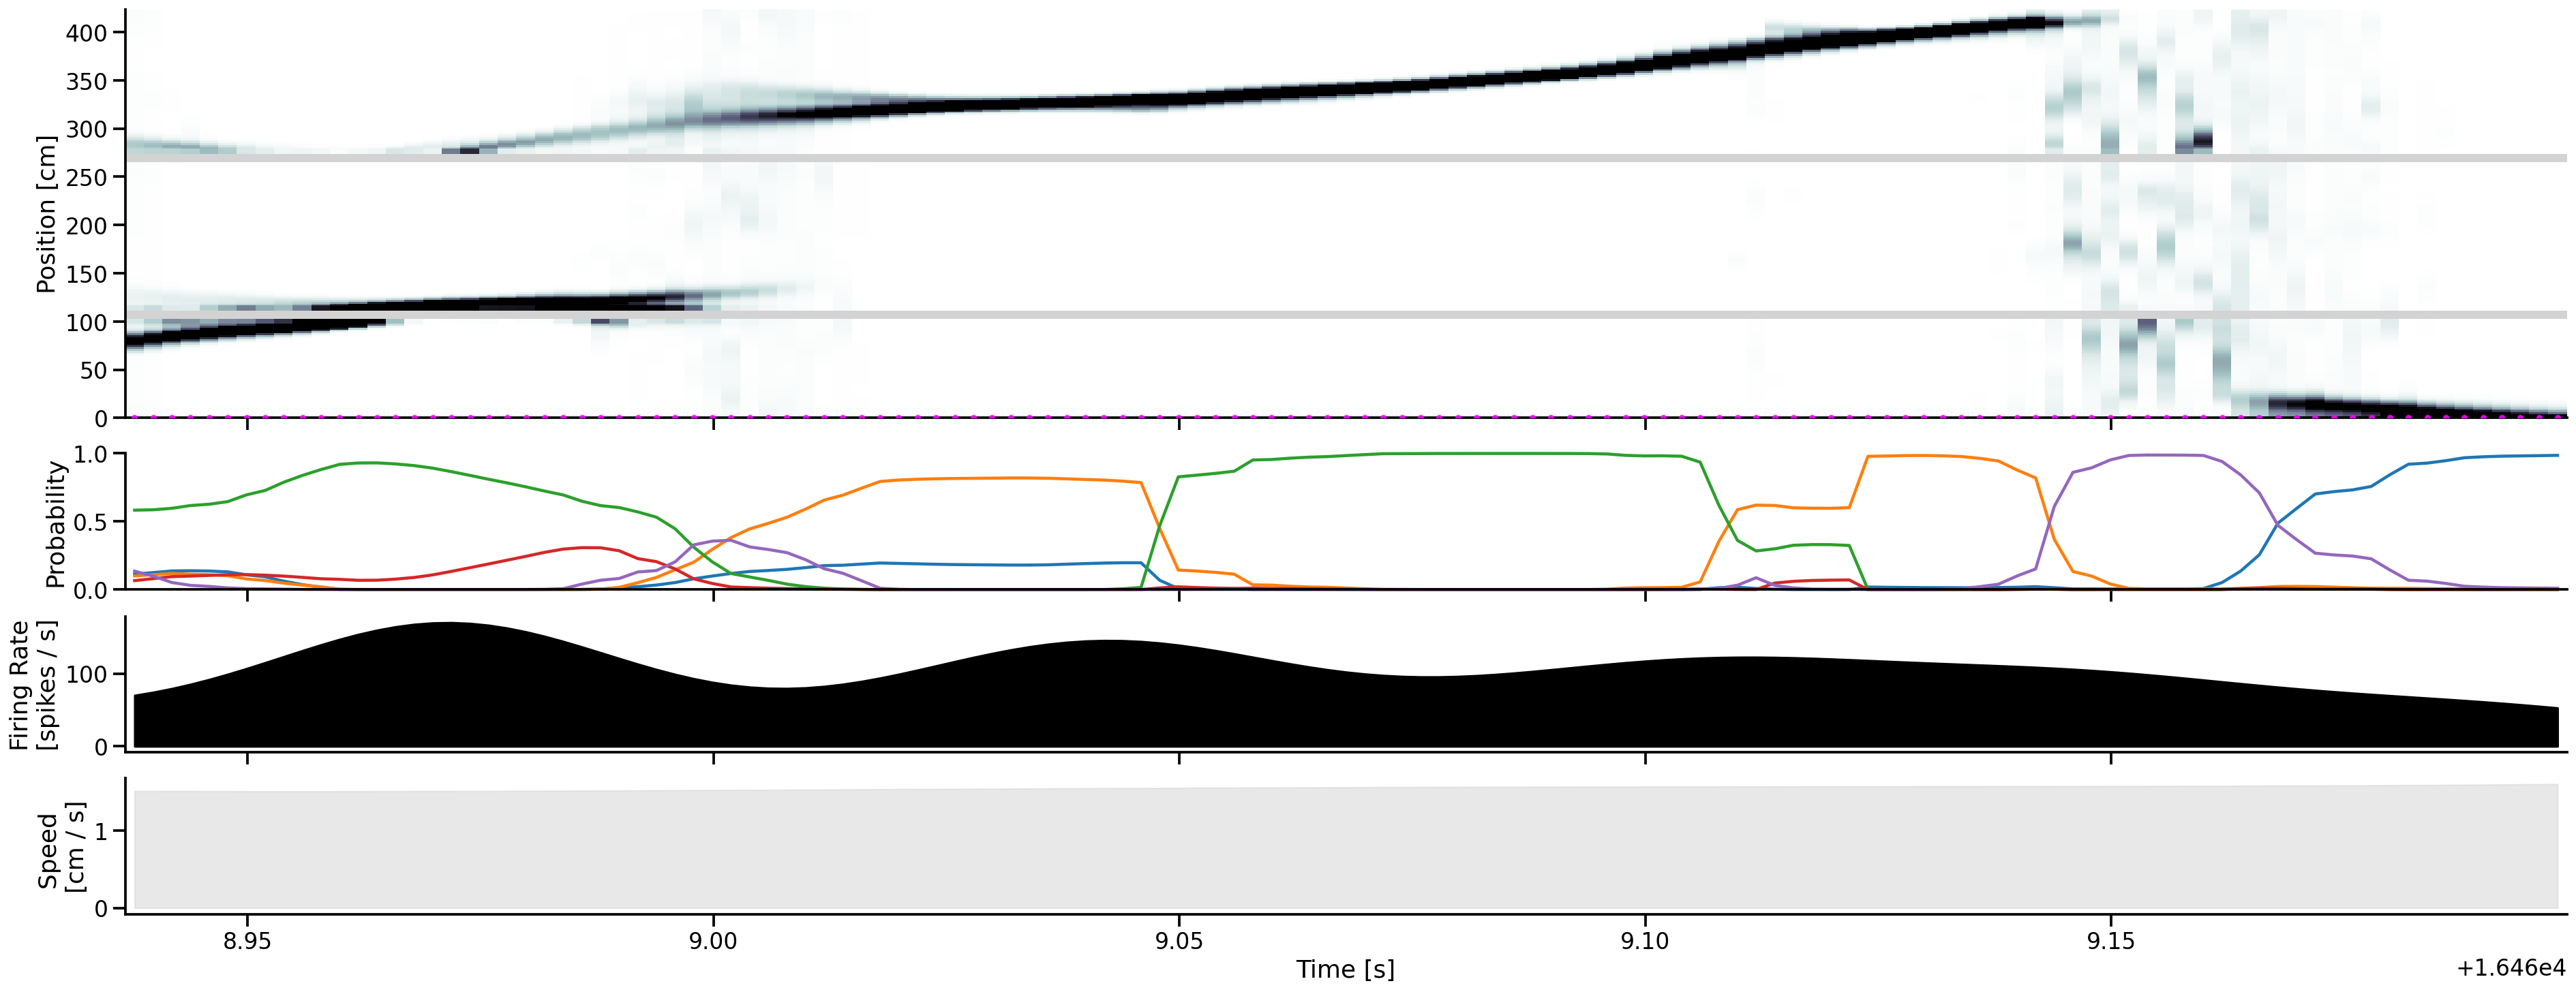

In [528]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 21
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

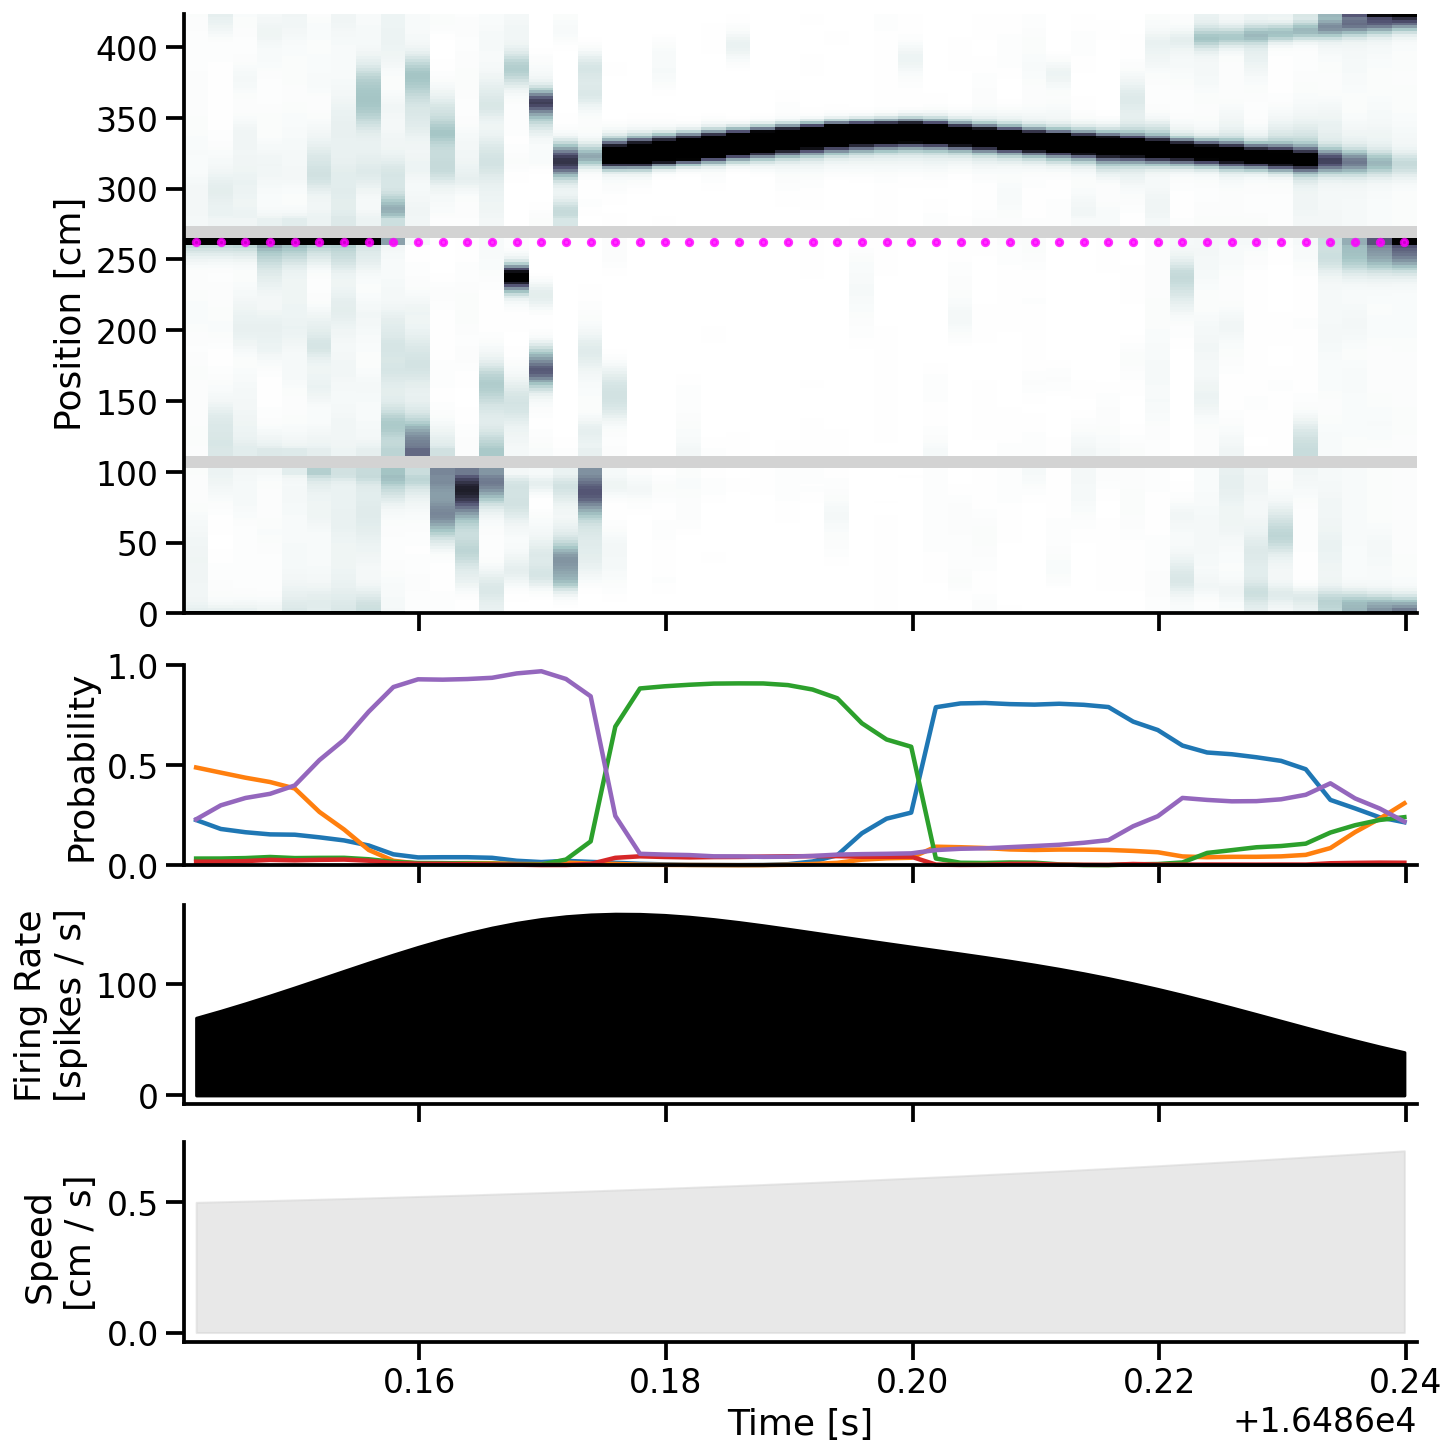

In [529]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 22
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

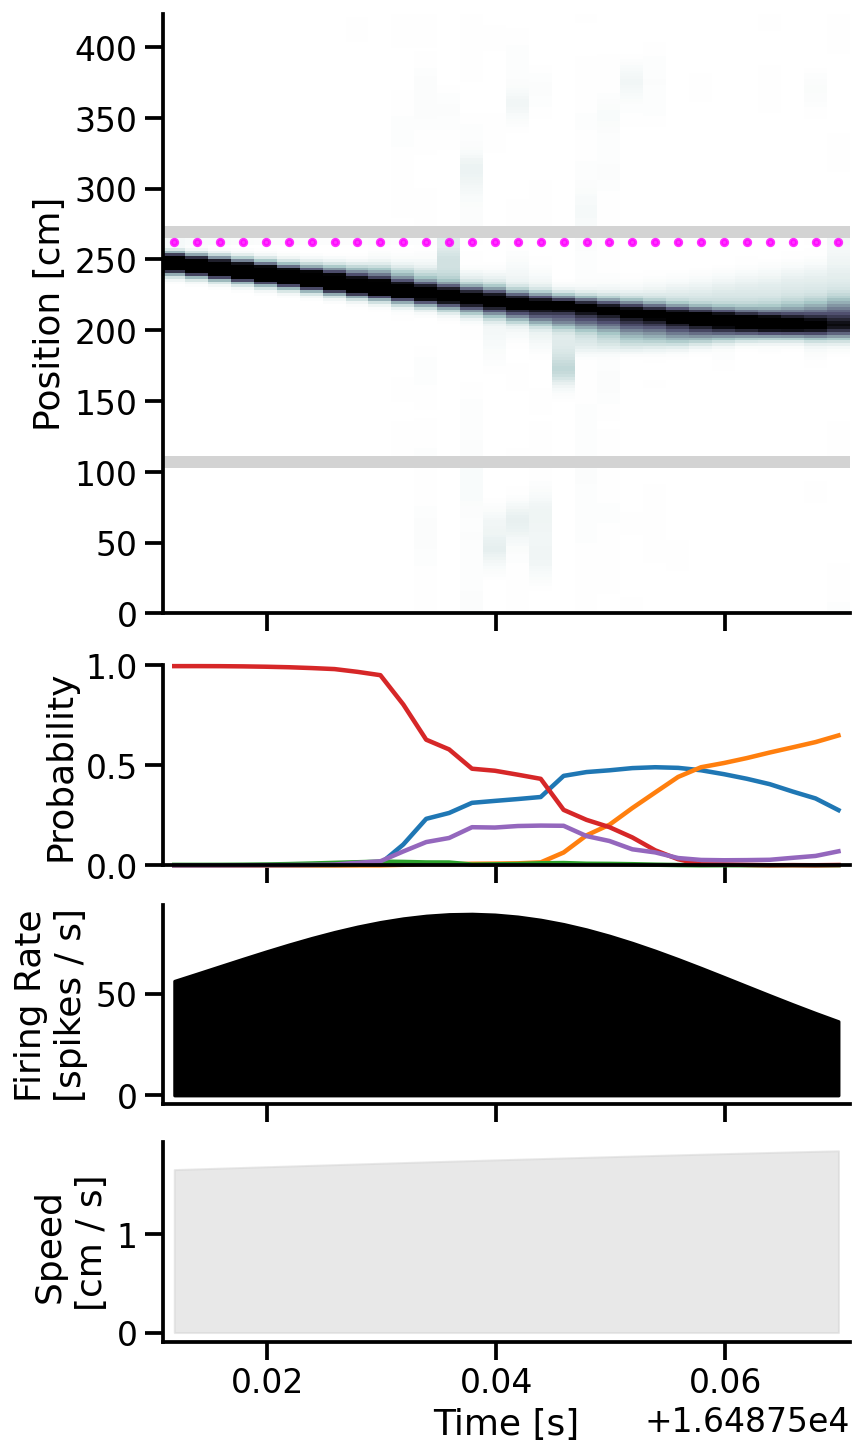

In [530]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 23
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

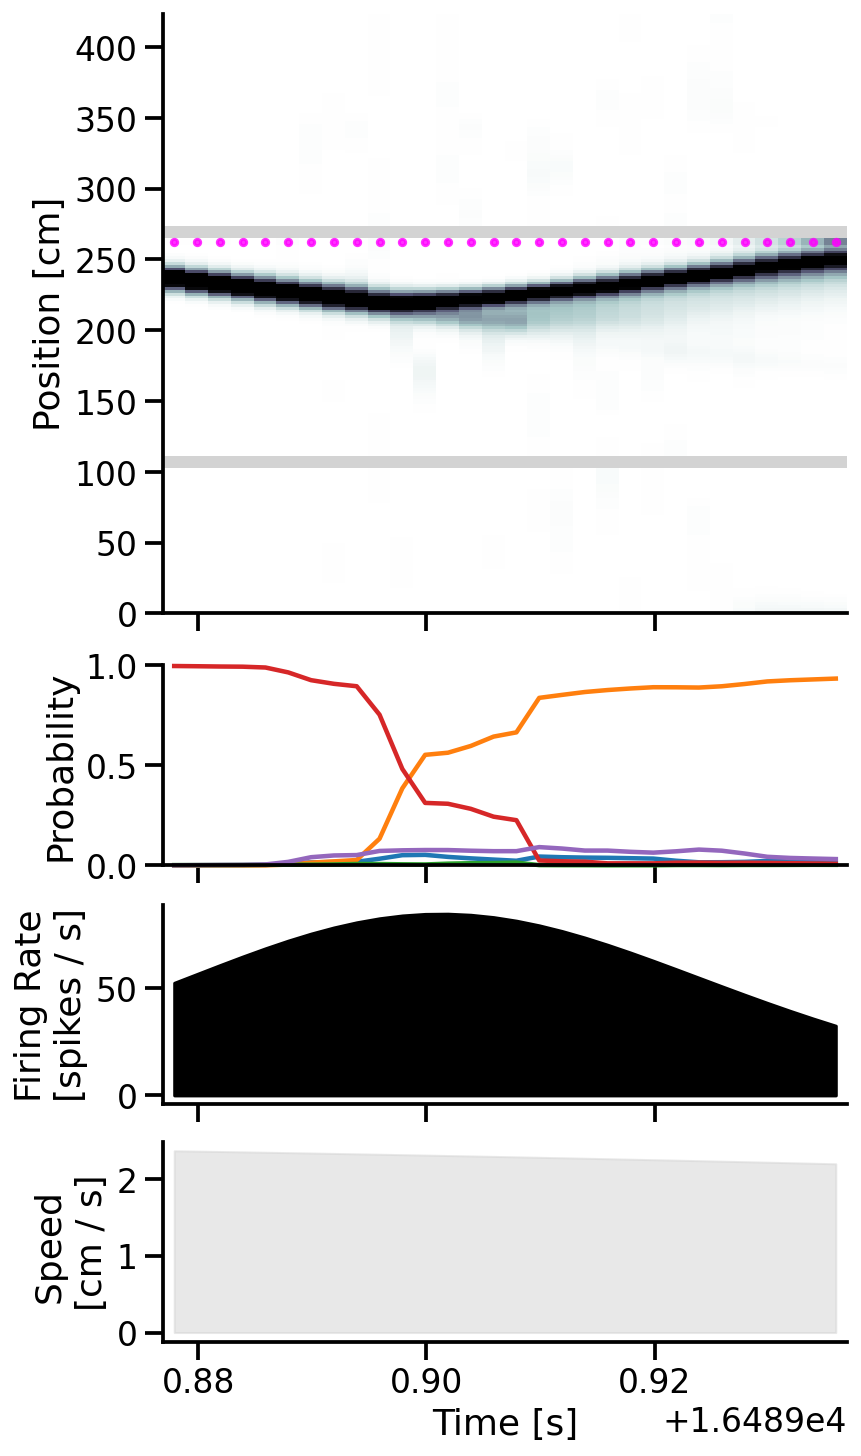

In [531]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 24
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

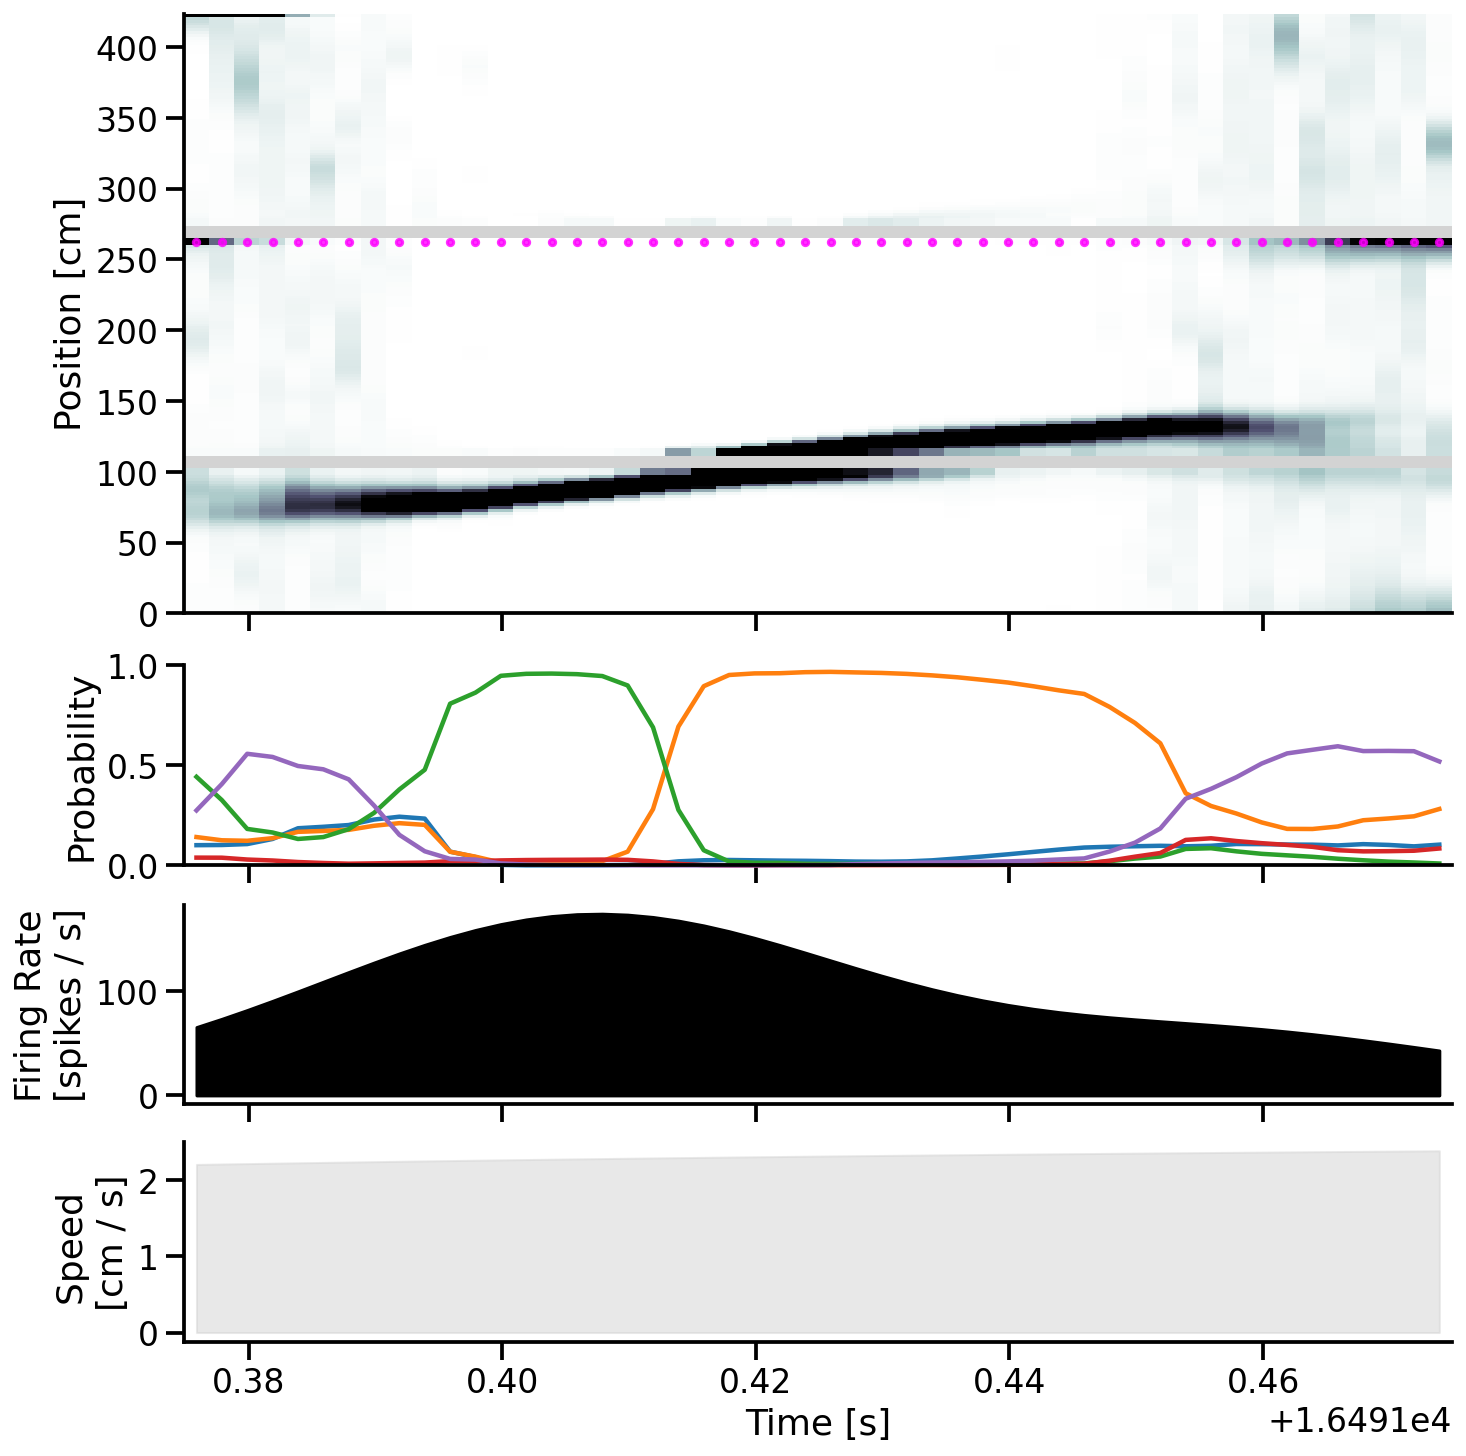

In [533]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 26
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

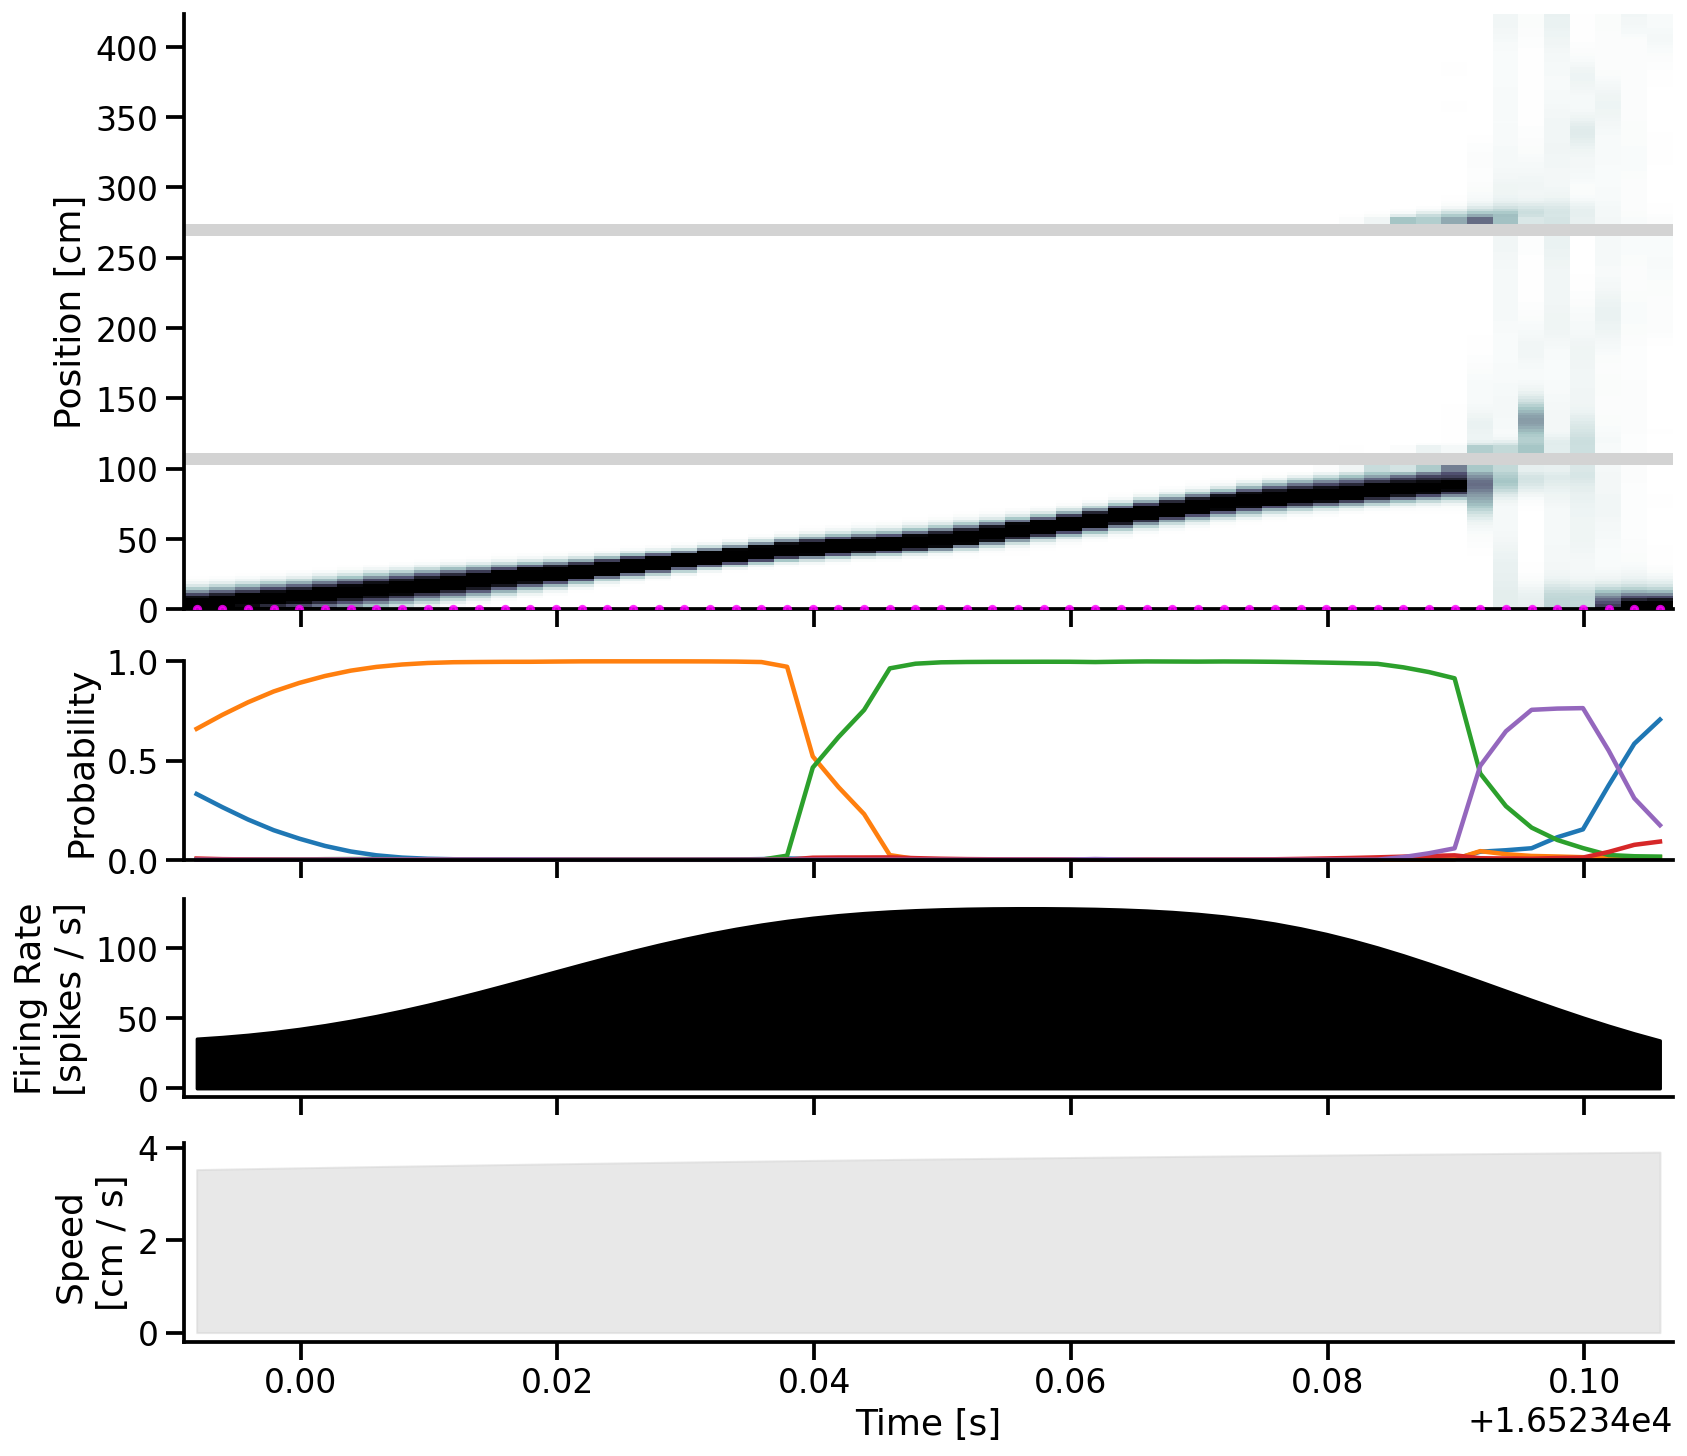

In [536]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 29
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

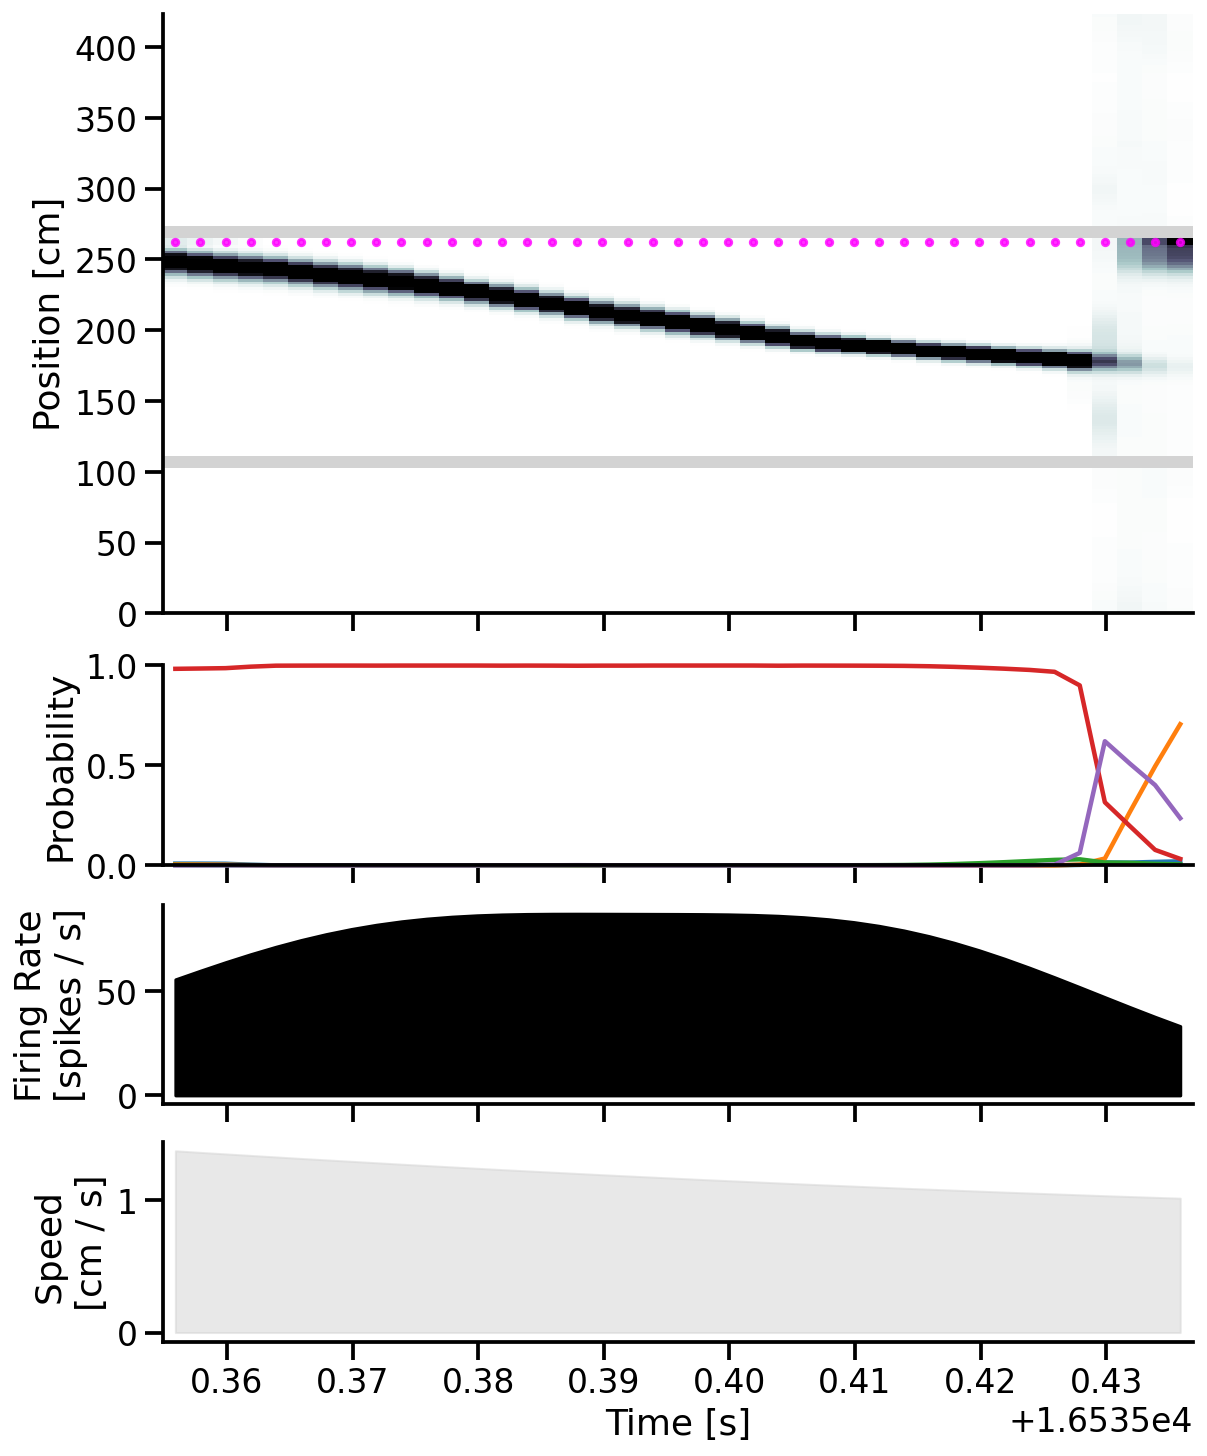

In [539]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 32
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

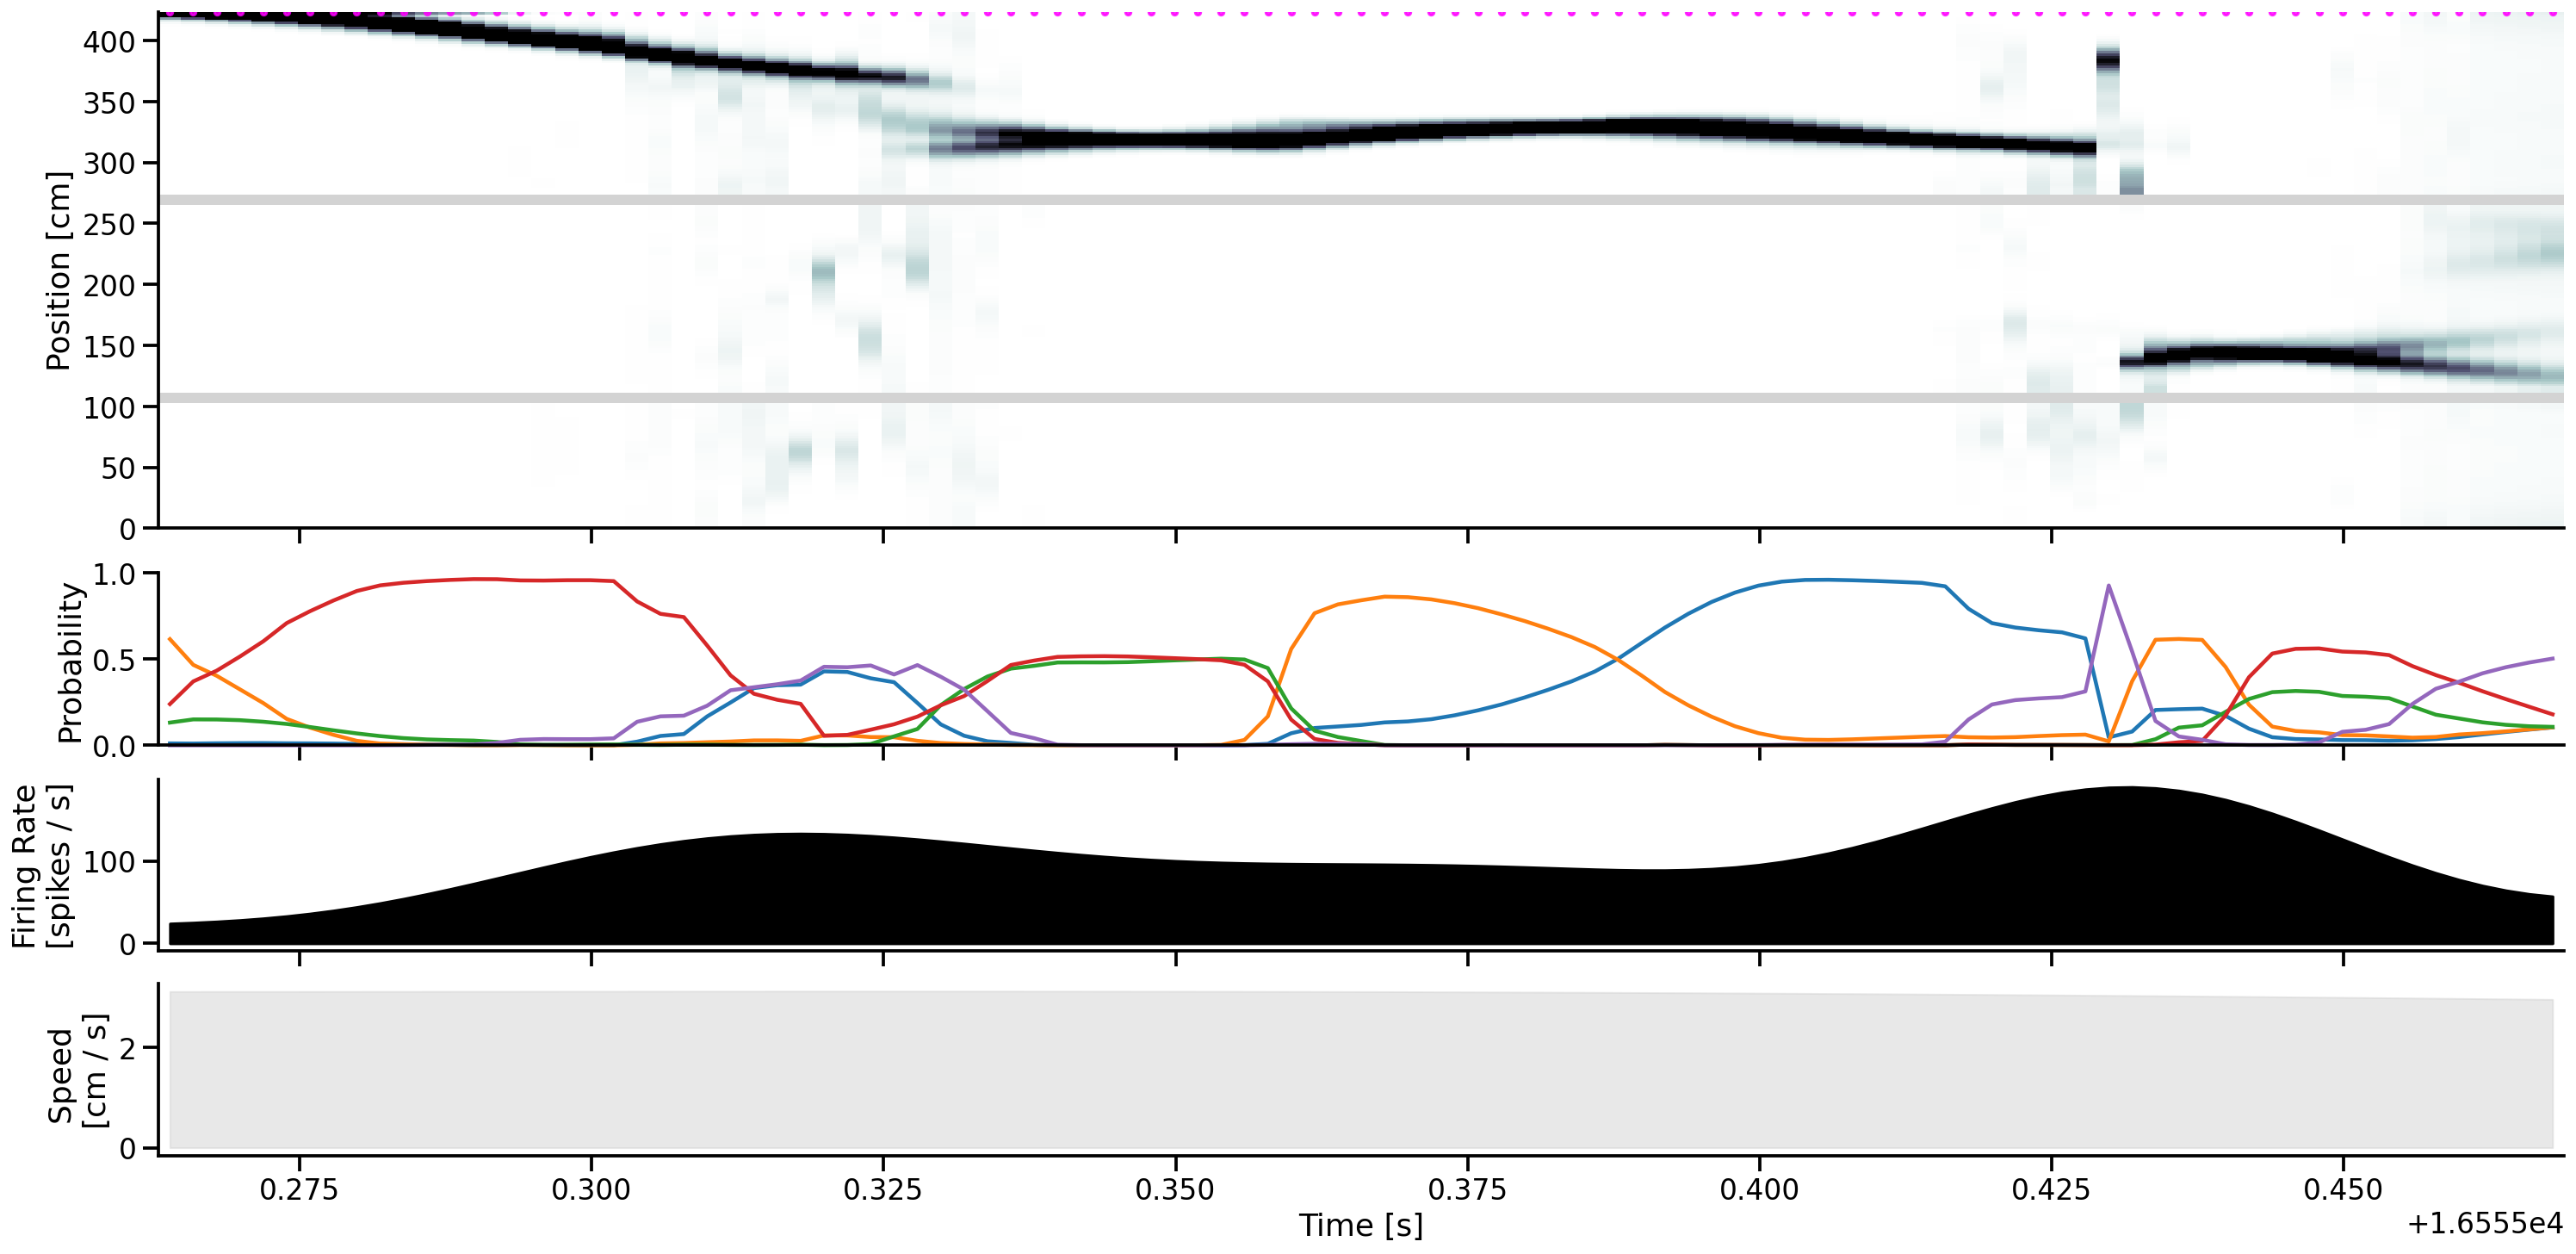

In [545]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 38
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

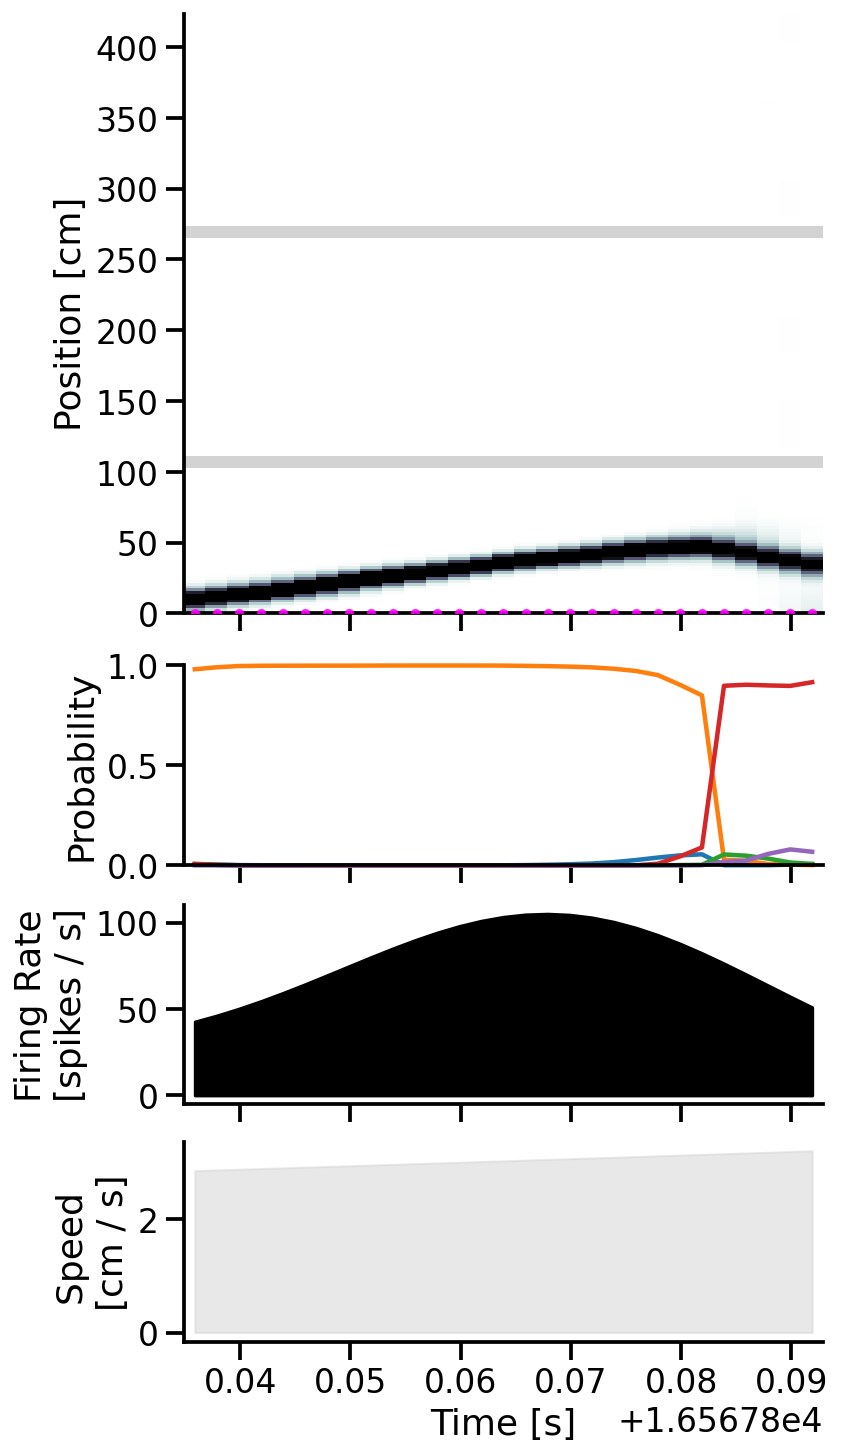

In [546]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 39
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

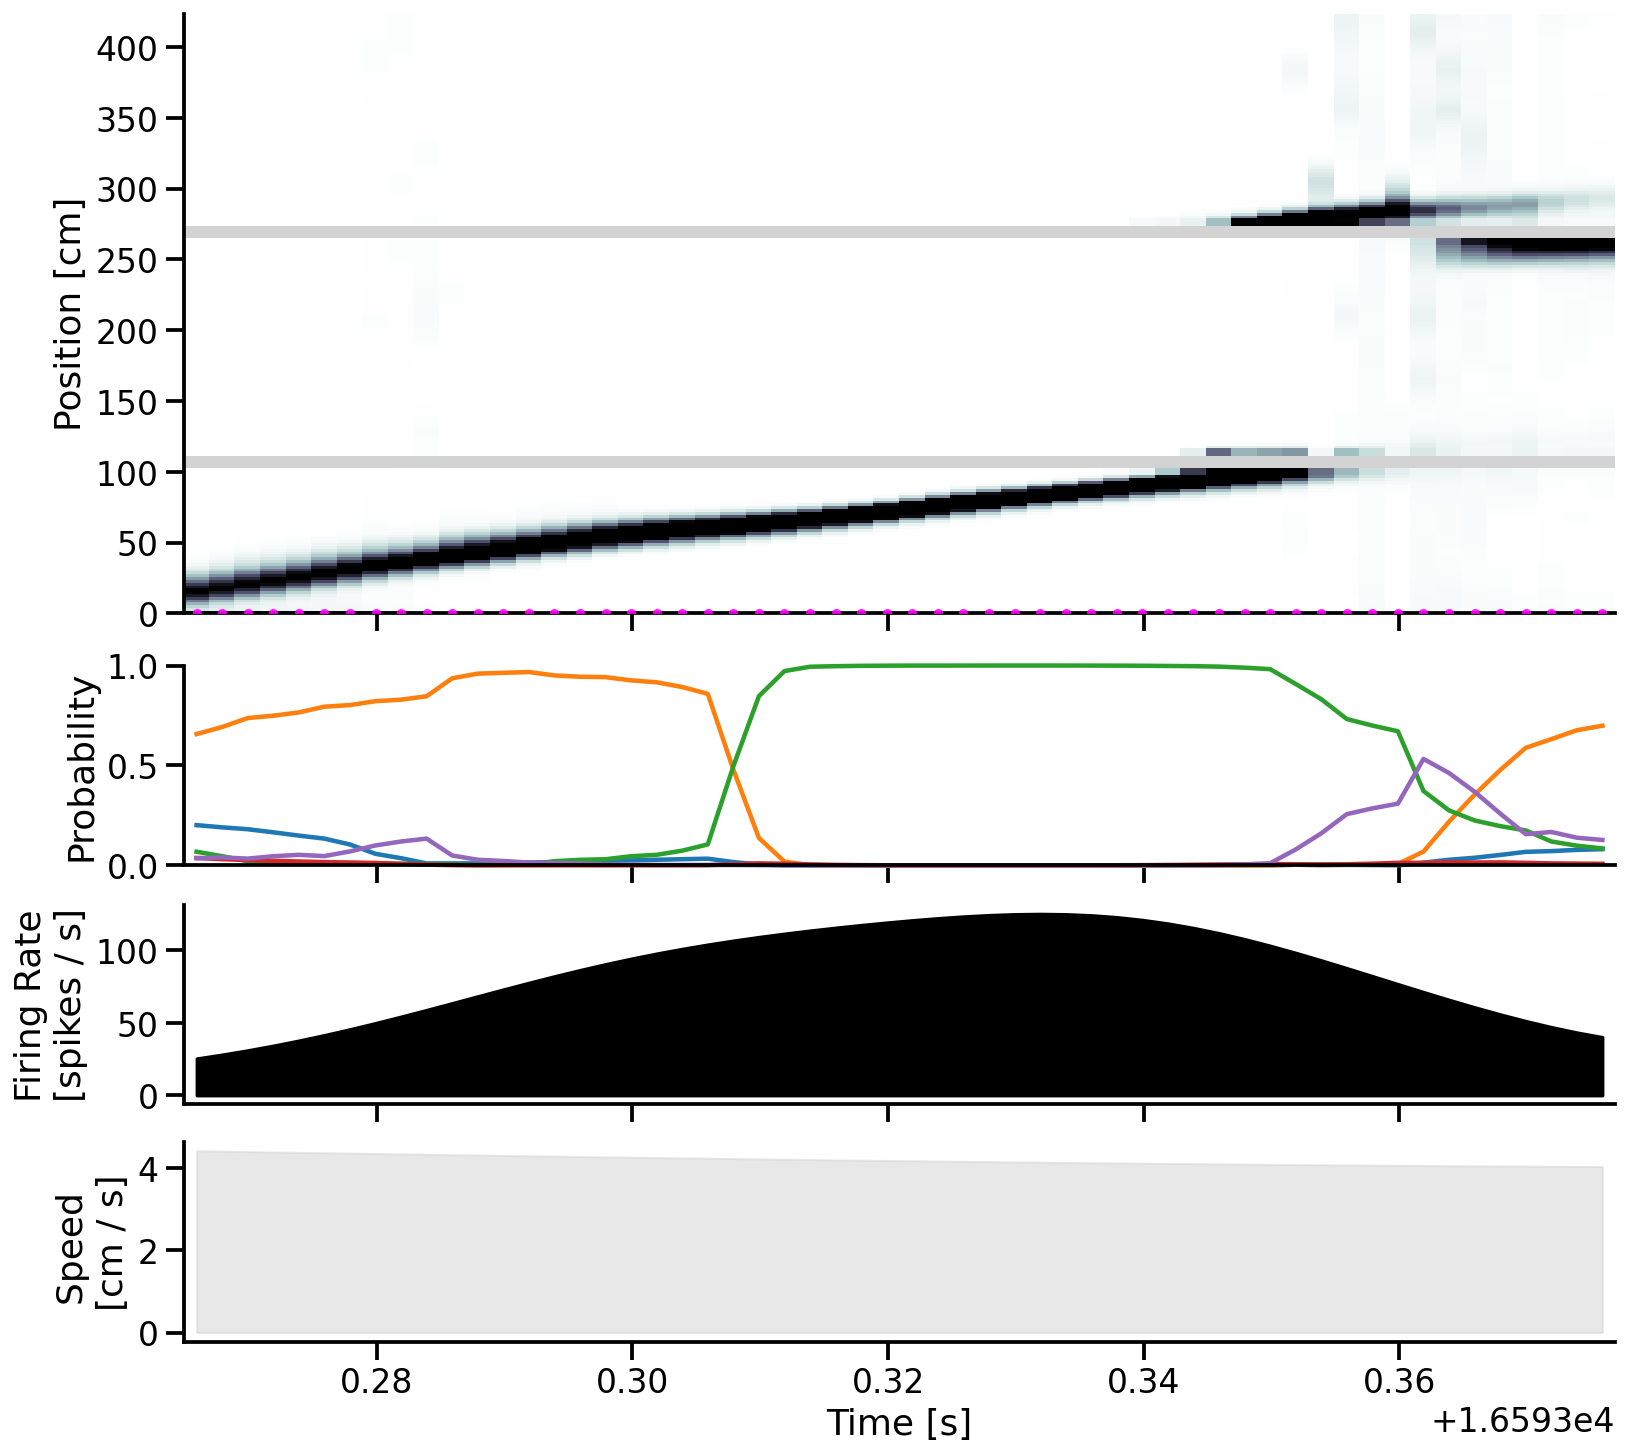

In [547]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 40
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

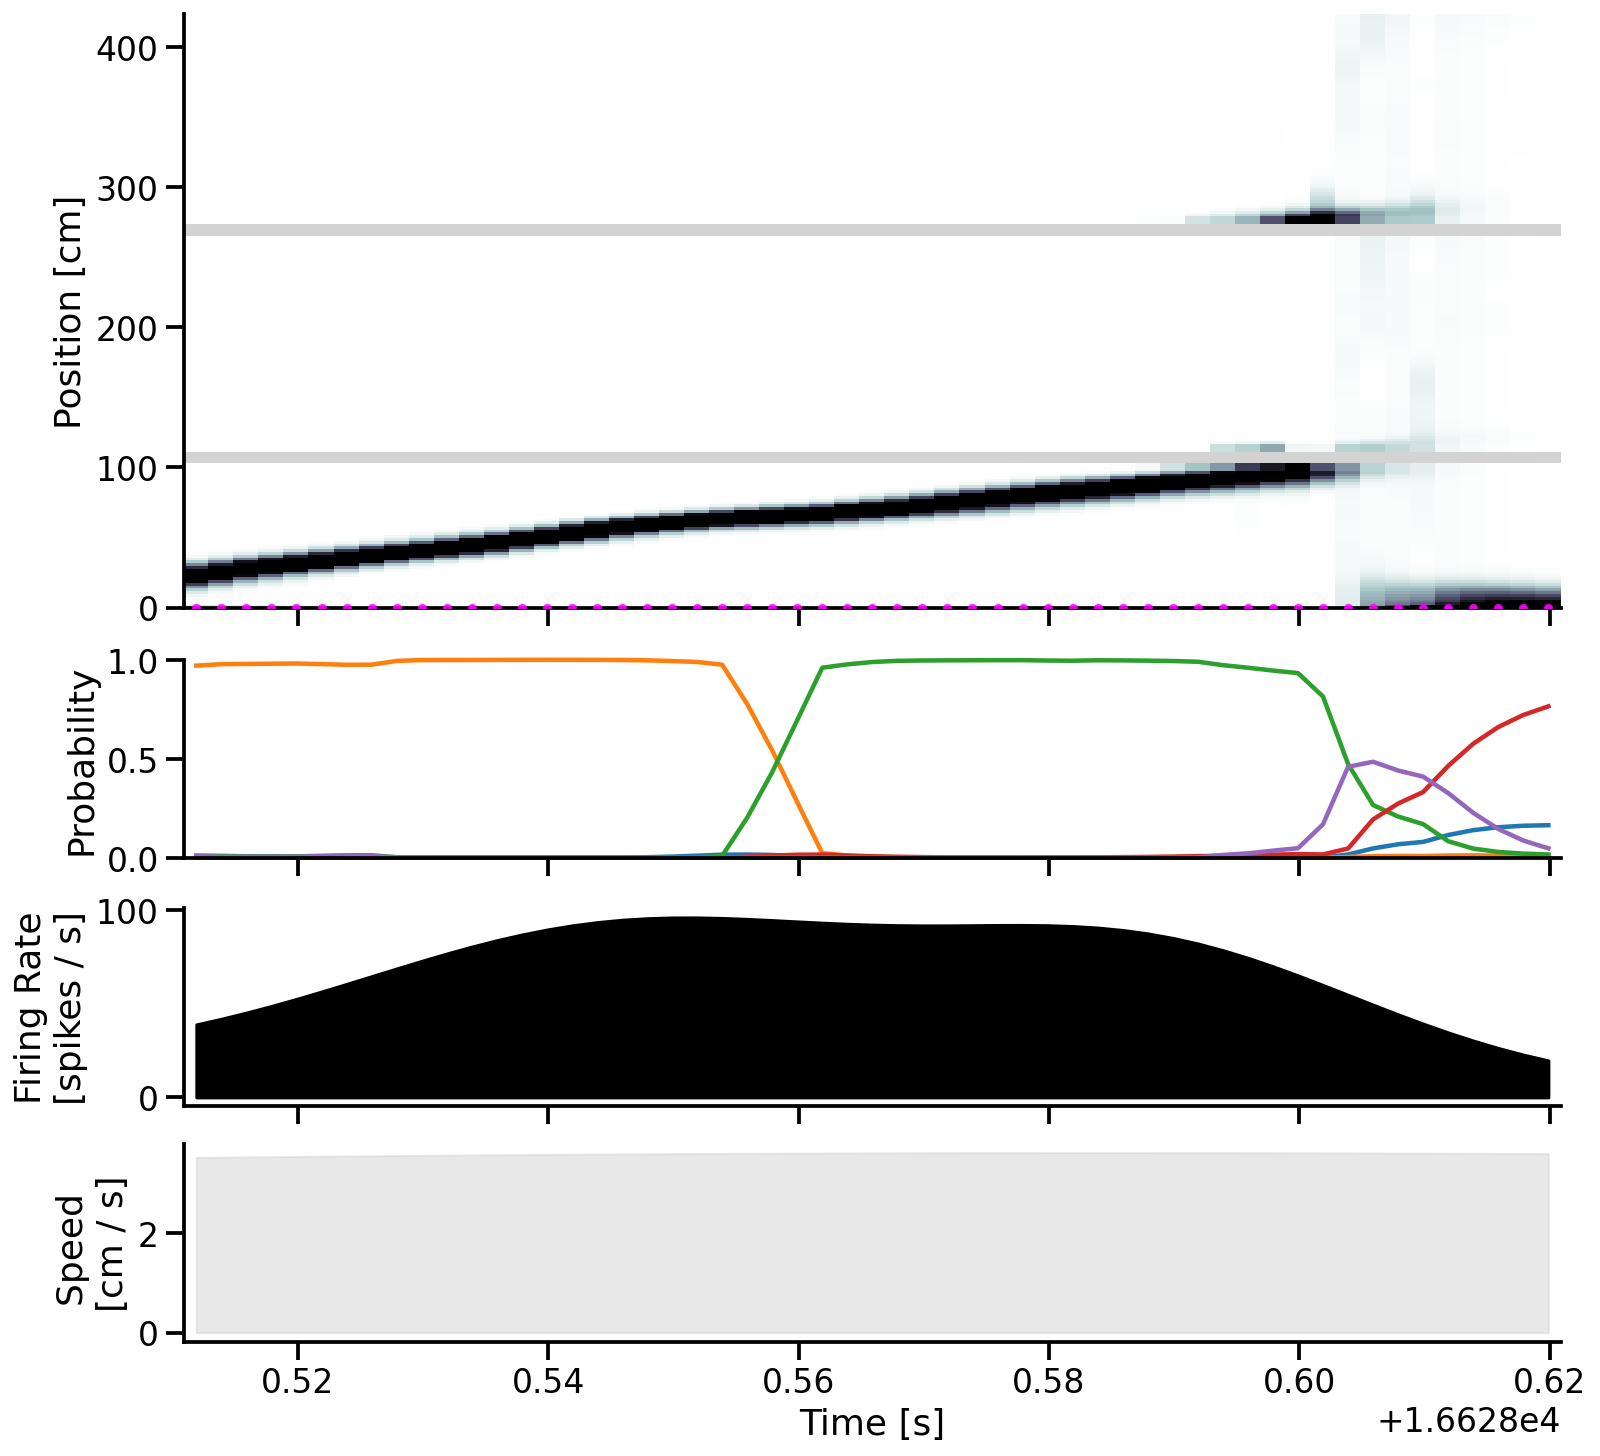

In [551]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 43
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

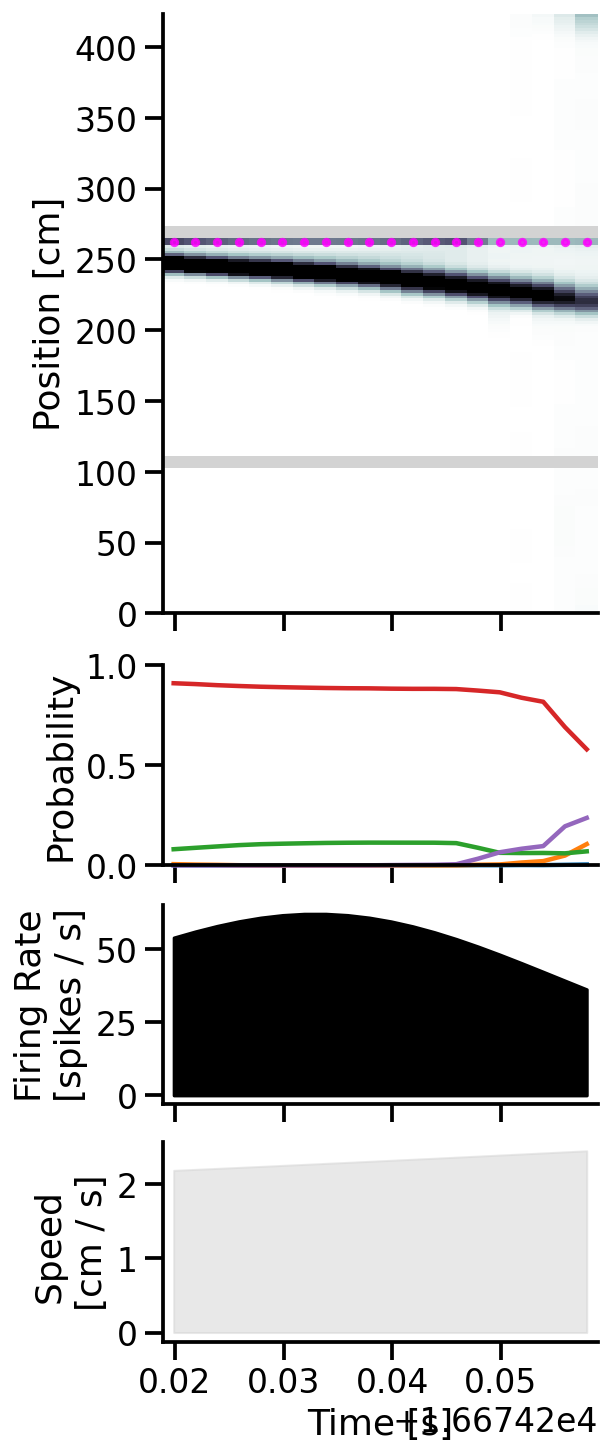

In [557]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 50
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

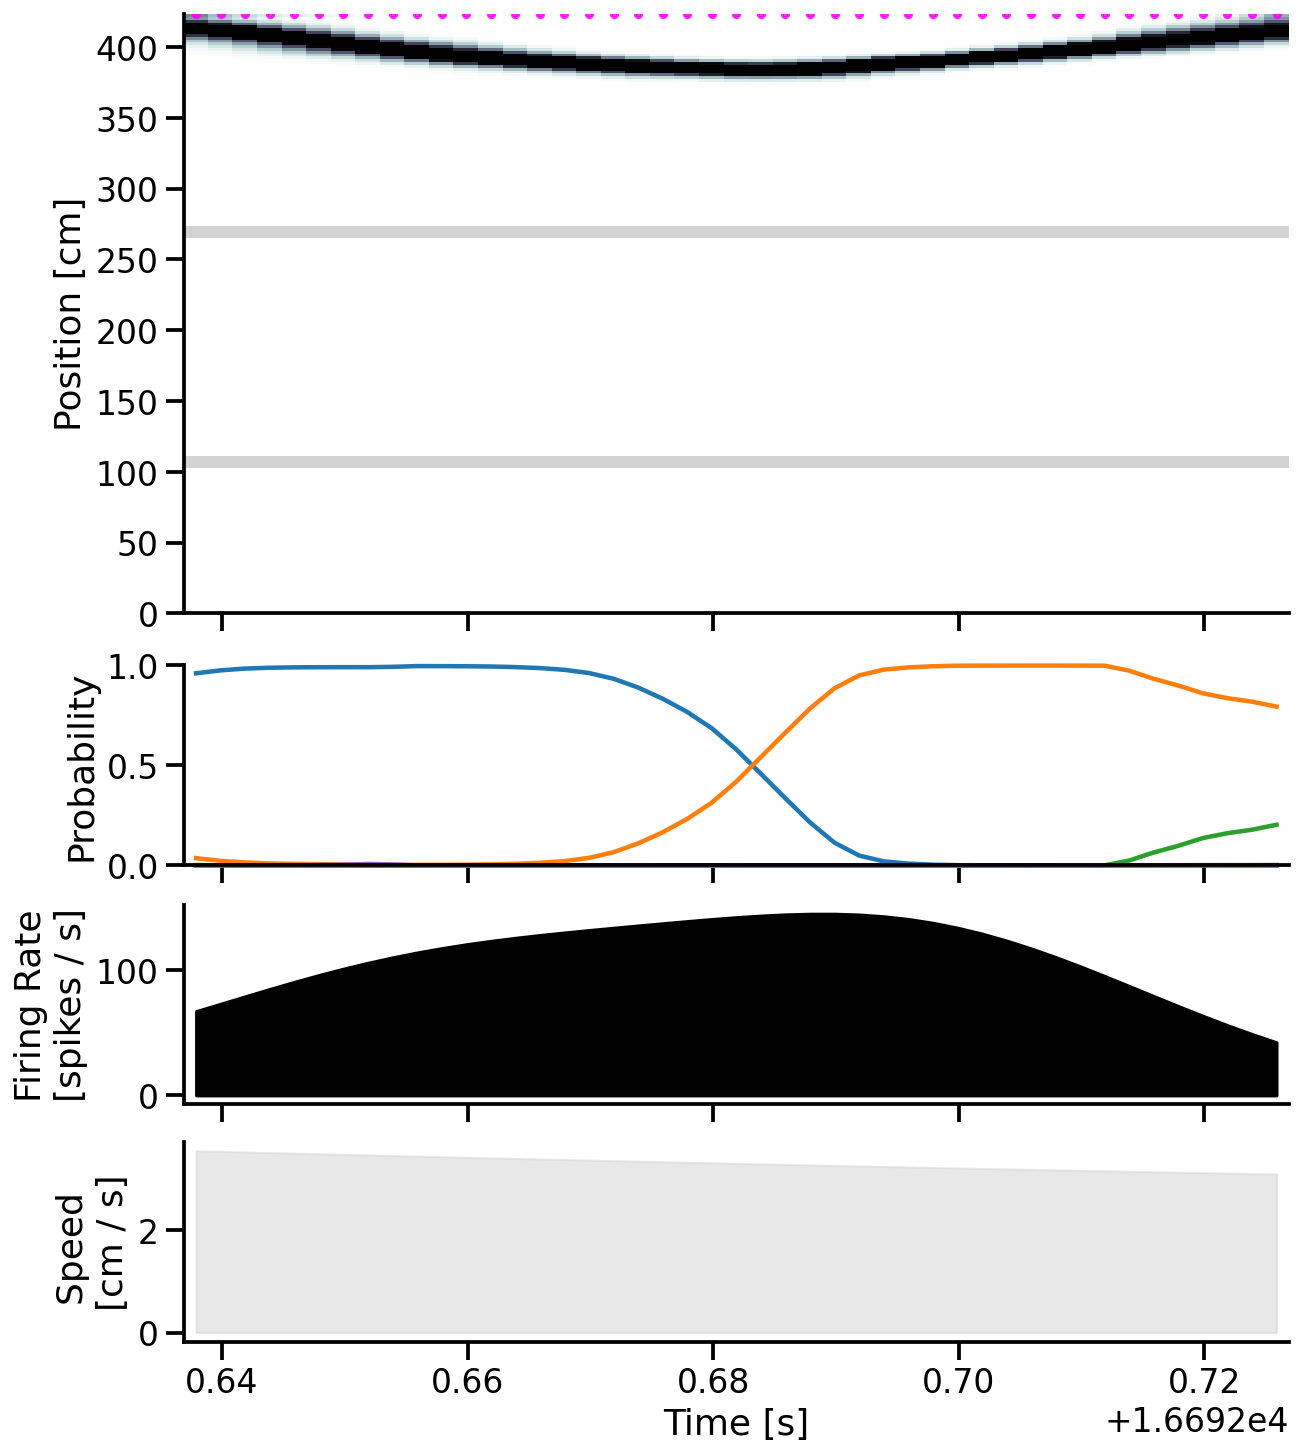

In [558]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 51
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

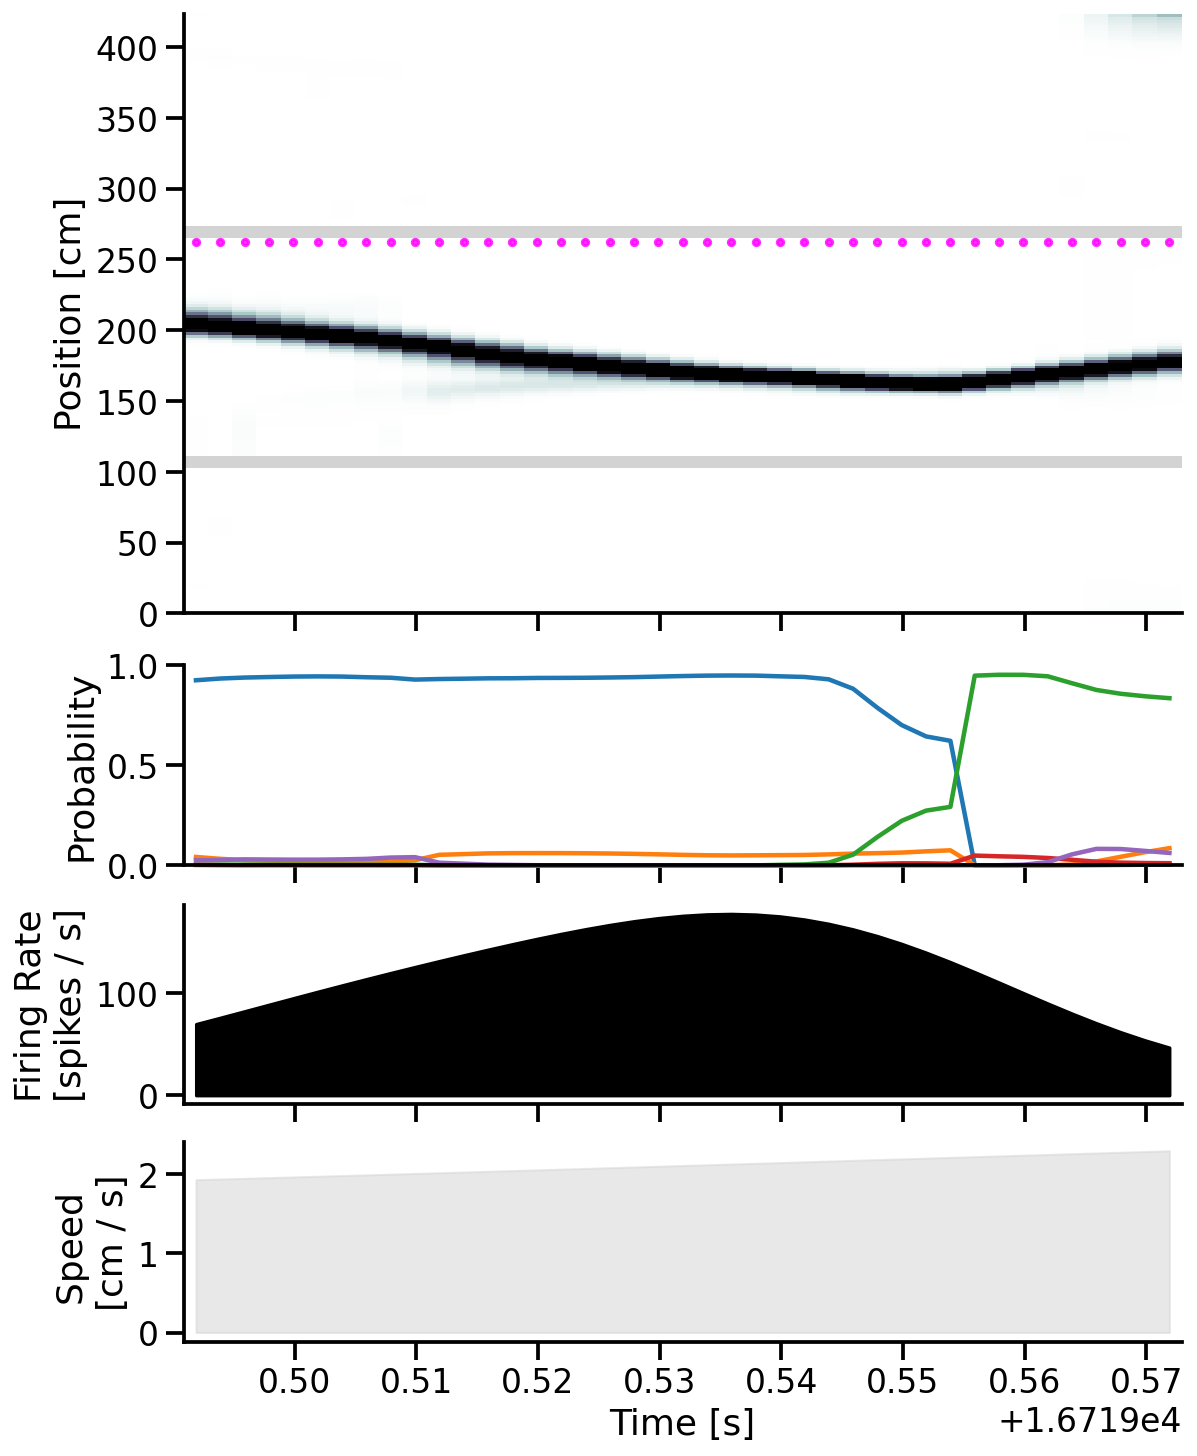

In [572]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 63
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

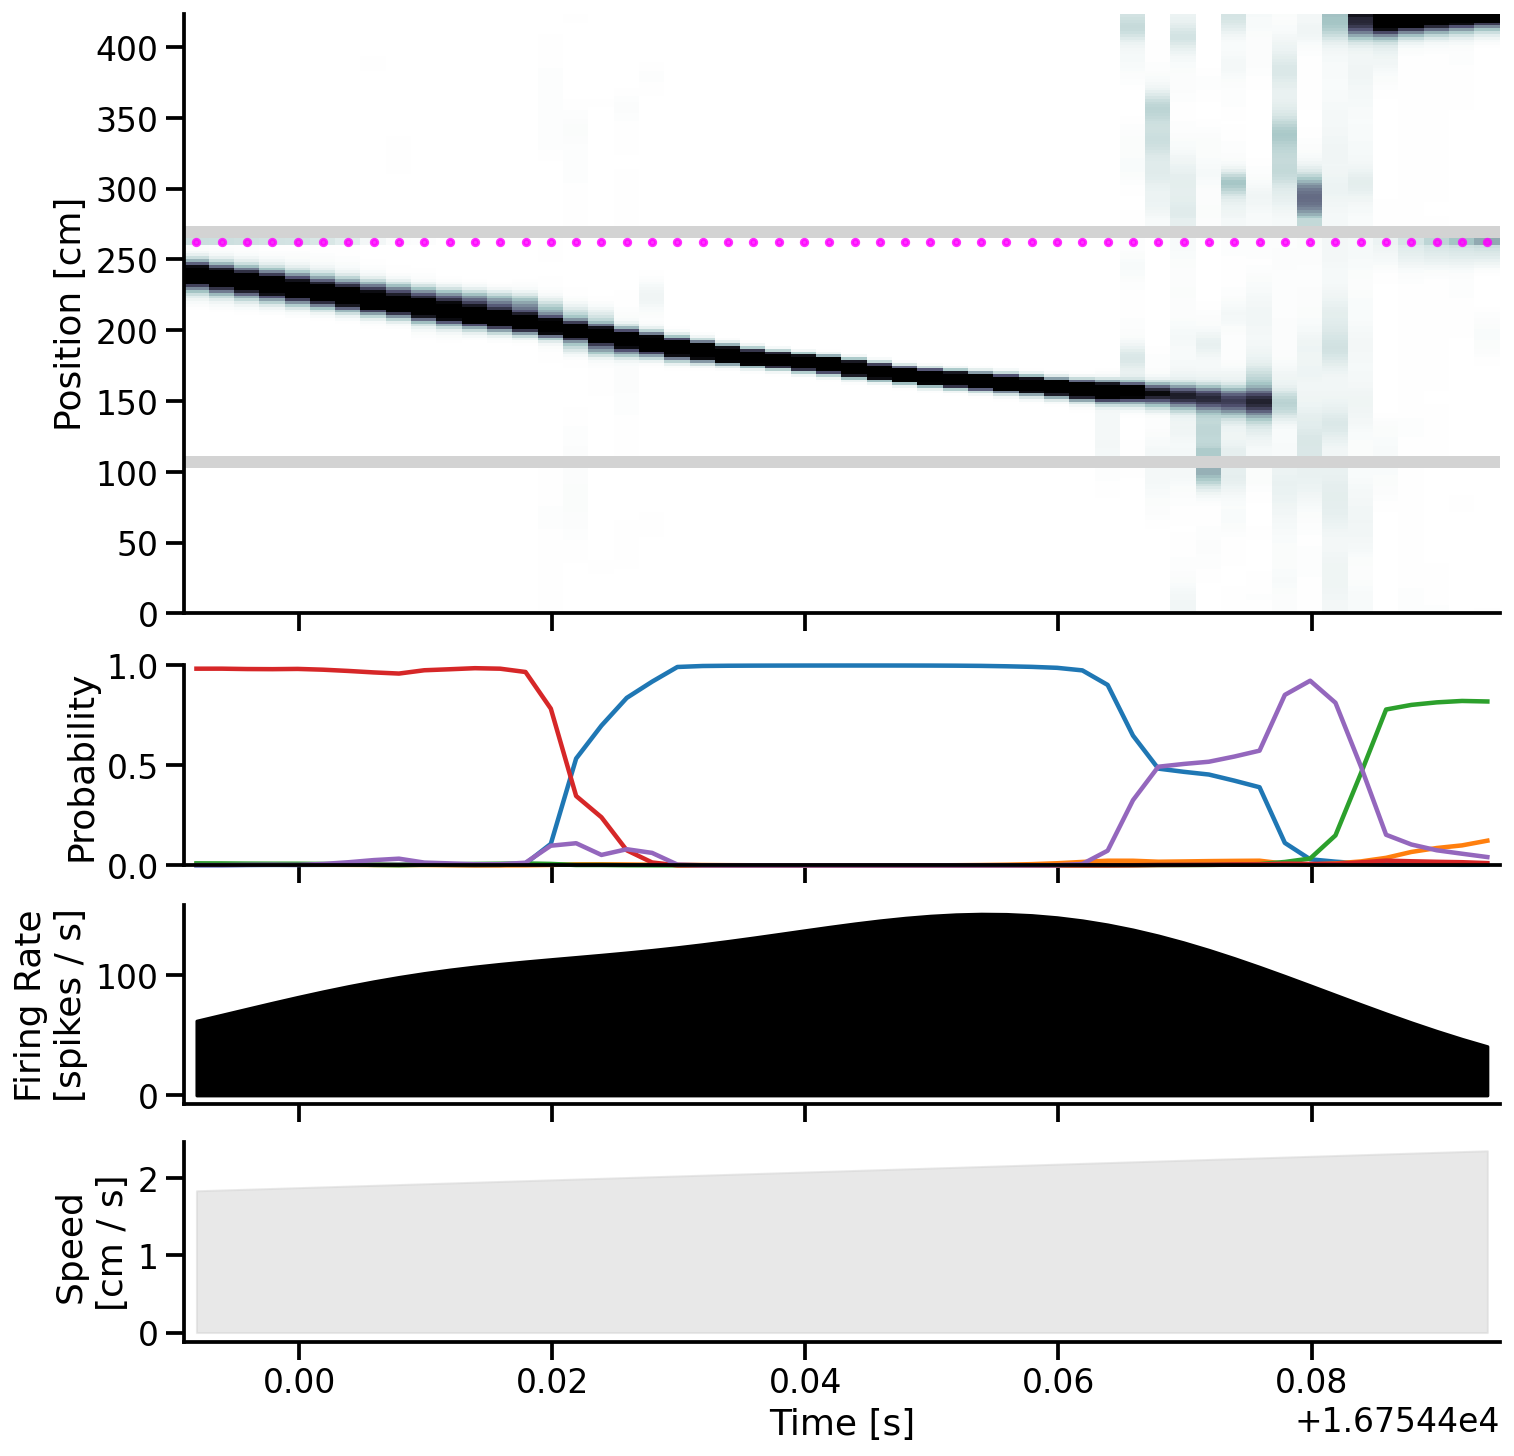

In [579]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 69
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

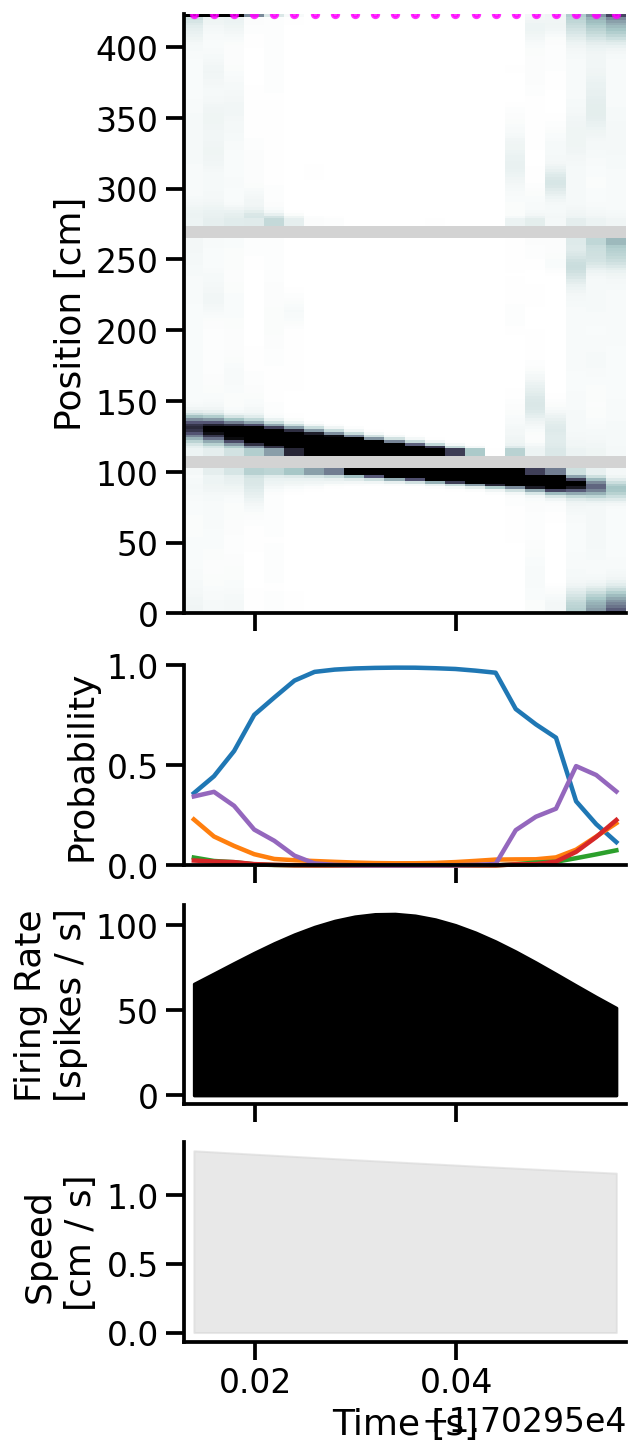

In [583]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 118
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

In [582]:
state_order.iloc[(state_order == 'Inbound-Forward').values]

state_order
replay_number                 
118            Inbound-Forward
120            Inbound-Forward
172            Inbound-Forward

In [584]:
state_order.iloc[(state_order == 'Inbound-Reverse').values]

state_order
replay_number                 
2              Inbound-Reverse
5              Inbound-Reverse
7              Inbound-Reverse
16             Inbound-Reverse
19             Inbound-Reverse
23             Inbound-Reverse
27             Inbound-Reverse
42             Inbound-Reverse
47             Inbound-Reverse
67             Inbound-Reverse
72             Inbound-Reverse
81             Inbound-Reverse
92             Inbound-Reverse
98             Inbound-Reverse
102            Inbound-Reverse
113            Inbound-Reverse
116            Inbound-Reverse
117            Inbound-Reverse
128            Inbound-Reverse
140            Inbound-Reverse
143            Inbound-Reverse
144            Inbound-Reverse
145            Inbound-Reverse
168            Inbound-Reverse
178            Inbound-Reverse

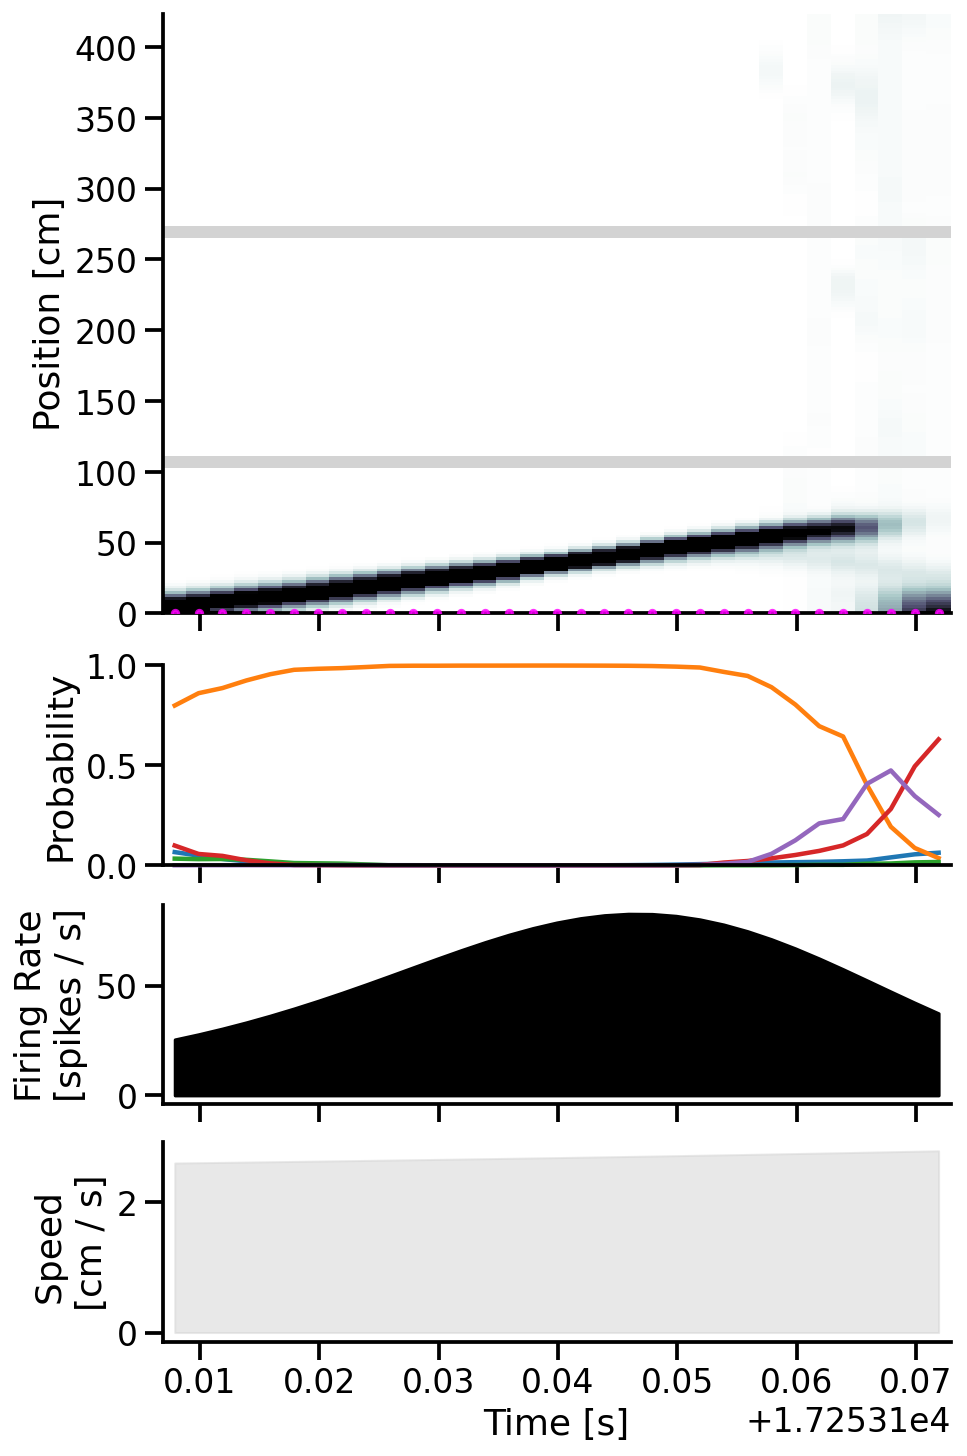

In [587]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 178
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

In [445]:
state_order.iloc[(state_order == 'Outbound-Reverse').values]

state_order
replay_number                  
9              Outbound-Reverse
31             Outbound-Reverse
32             Outbound-Reverse
45             Outbound-Reverse
50             Outbound-Reverse
58             Outbound-Reverse
76             Outbound-Reverse
77             Outbound-Reverse
83             Outbound-Reverse
86             Outbound-Reverse
132            Outbound-Reverse
134            Outbound-Reverse
138            Outbound-Reverse
152            Outbound-Reverse
159            Outbound-Reverse
164            Outbound-Reverse
173            Outbound-Reverse
175            Outbound-Reverse
177            Outbound-Reverse

In [588]:
state_order.iloc[(state_order == 'Outbound-Forward').values]

state_order
replay_number                  
55             Outbound-Forward
63             Outbound-Forward
97             Outbound-Forward
124            Outbound-Forward
125            Outbound-Forward
141            Outbound-Forward
169            Outbound-Forward
170            Outbound-Forward

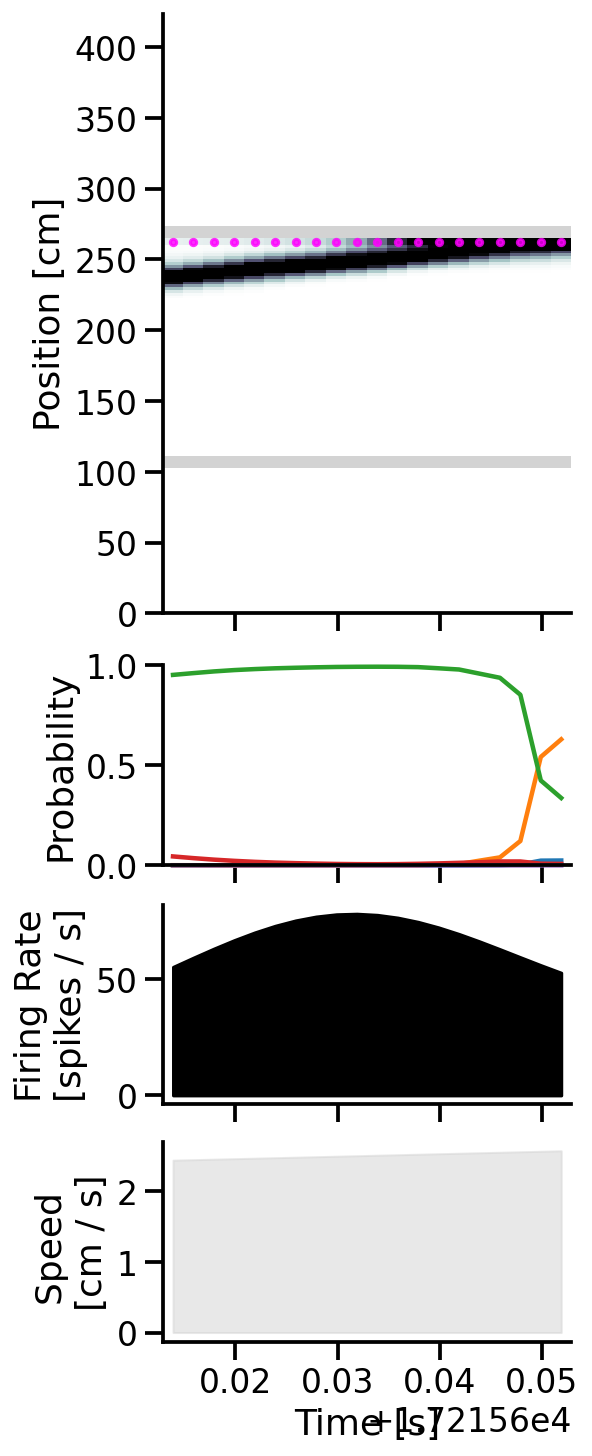

In [597]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 169
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

In [598]:
state_order.iloc[(state_order == 'Fragmented').values]

state_order
replay_number            
4              Fragmented
12             Fragmented
14             Fragmented
22             Fragmented
28             Fragmented
34             Fragmented
36             Fragmented
46             Fragmented
48             Fragmented
49             Fragmented
53             Fragmented
59             Fragmented
61             Fragmented
62             Fragmented
65             Fragmented
73             Fragmented
75             Fragmented
78             Fragmented
79             Fragmented
80             Fragmented
87             Fragmented
91             Fragmented
99             Fragmented
100            Fragmented
103            Fragmented
104            Fragmented
106            Fragmented
107            Fragmented
110            Fragmented
114            Fragmented
122            Fragmented
133            Fragmented
139            Fragmented
146            Fragmented
147            Fragmented
150            Fragmented
156            Fragmented
158            Fragmented
176            Fragmented

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

ripple_number = 147
ripple = data['ripple_times'].loc[ripple_number]

plot_classifier_inbound_outbound_time_slice(
    slice(ripple.start_time / np.timedelta64(1, 's'),
          ripple.end_time / np.timedelta64(1, 's')),
    cv_classifier,
    clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(ripple.duration * 100, 10),
    legend=False,
)

In [449]:
state_order.iloc[(state_order == 'Inbound-Reverse → Outbound-Forward').values]

state_order
replay_number                                    
8              Inbound-Reverse → Outbound-Forward
29             Inbound-Reverse → Outbound-Forward
40             Inbound-Reverse → Outbound-Forward
93             Inbound-Reverse → Outbound-Forward
142            Inbound-Reverse → Outbound-Forward
162            Inbound-Reverse → Outbound-Forward

In [450]:
state_order.iloc[(state_order == 'Outbound-Forward → Inbound-Reverse').values]

state_order
replay_number                                    
109            Outbound-Forward → Inbound-Reverse
112            Outbound-Forward → Inbound-Reverse
115            Outbound-Forward → Inbound-Reverse
119            Outbound-Forward → Inbound-Reverse
154            Outbound-Forward → Inbound-Reverse
161            Outbound-Forward → Inbound-Reverse

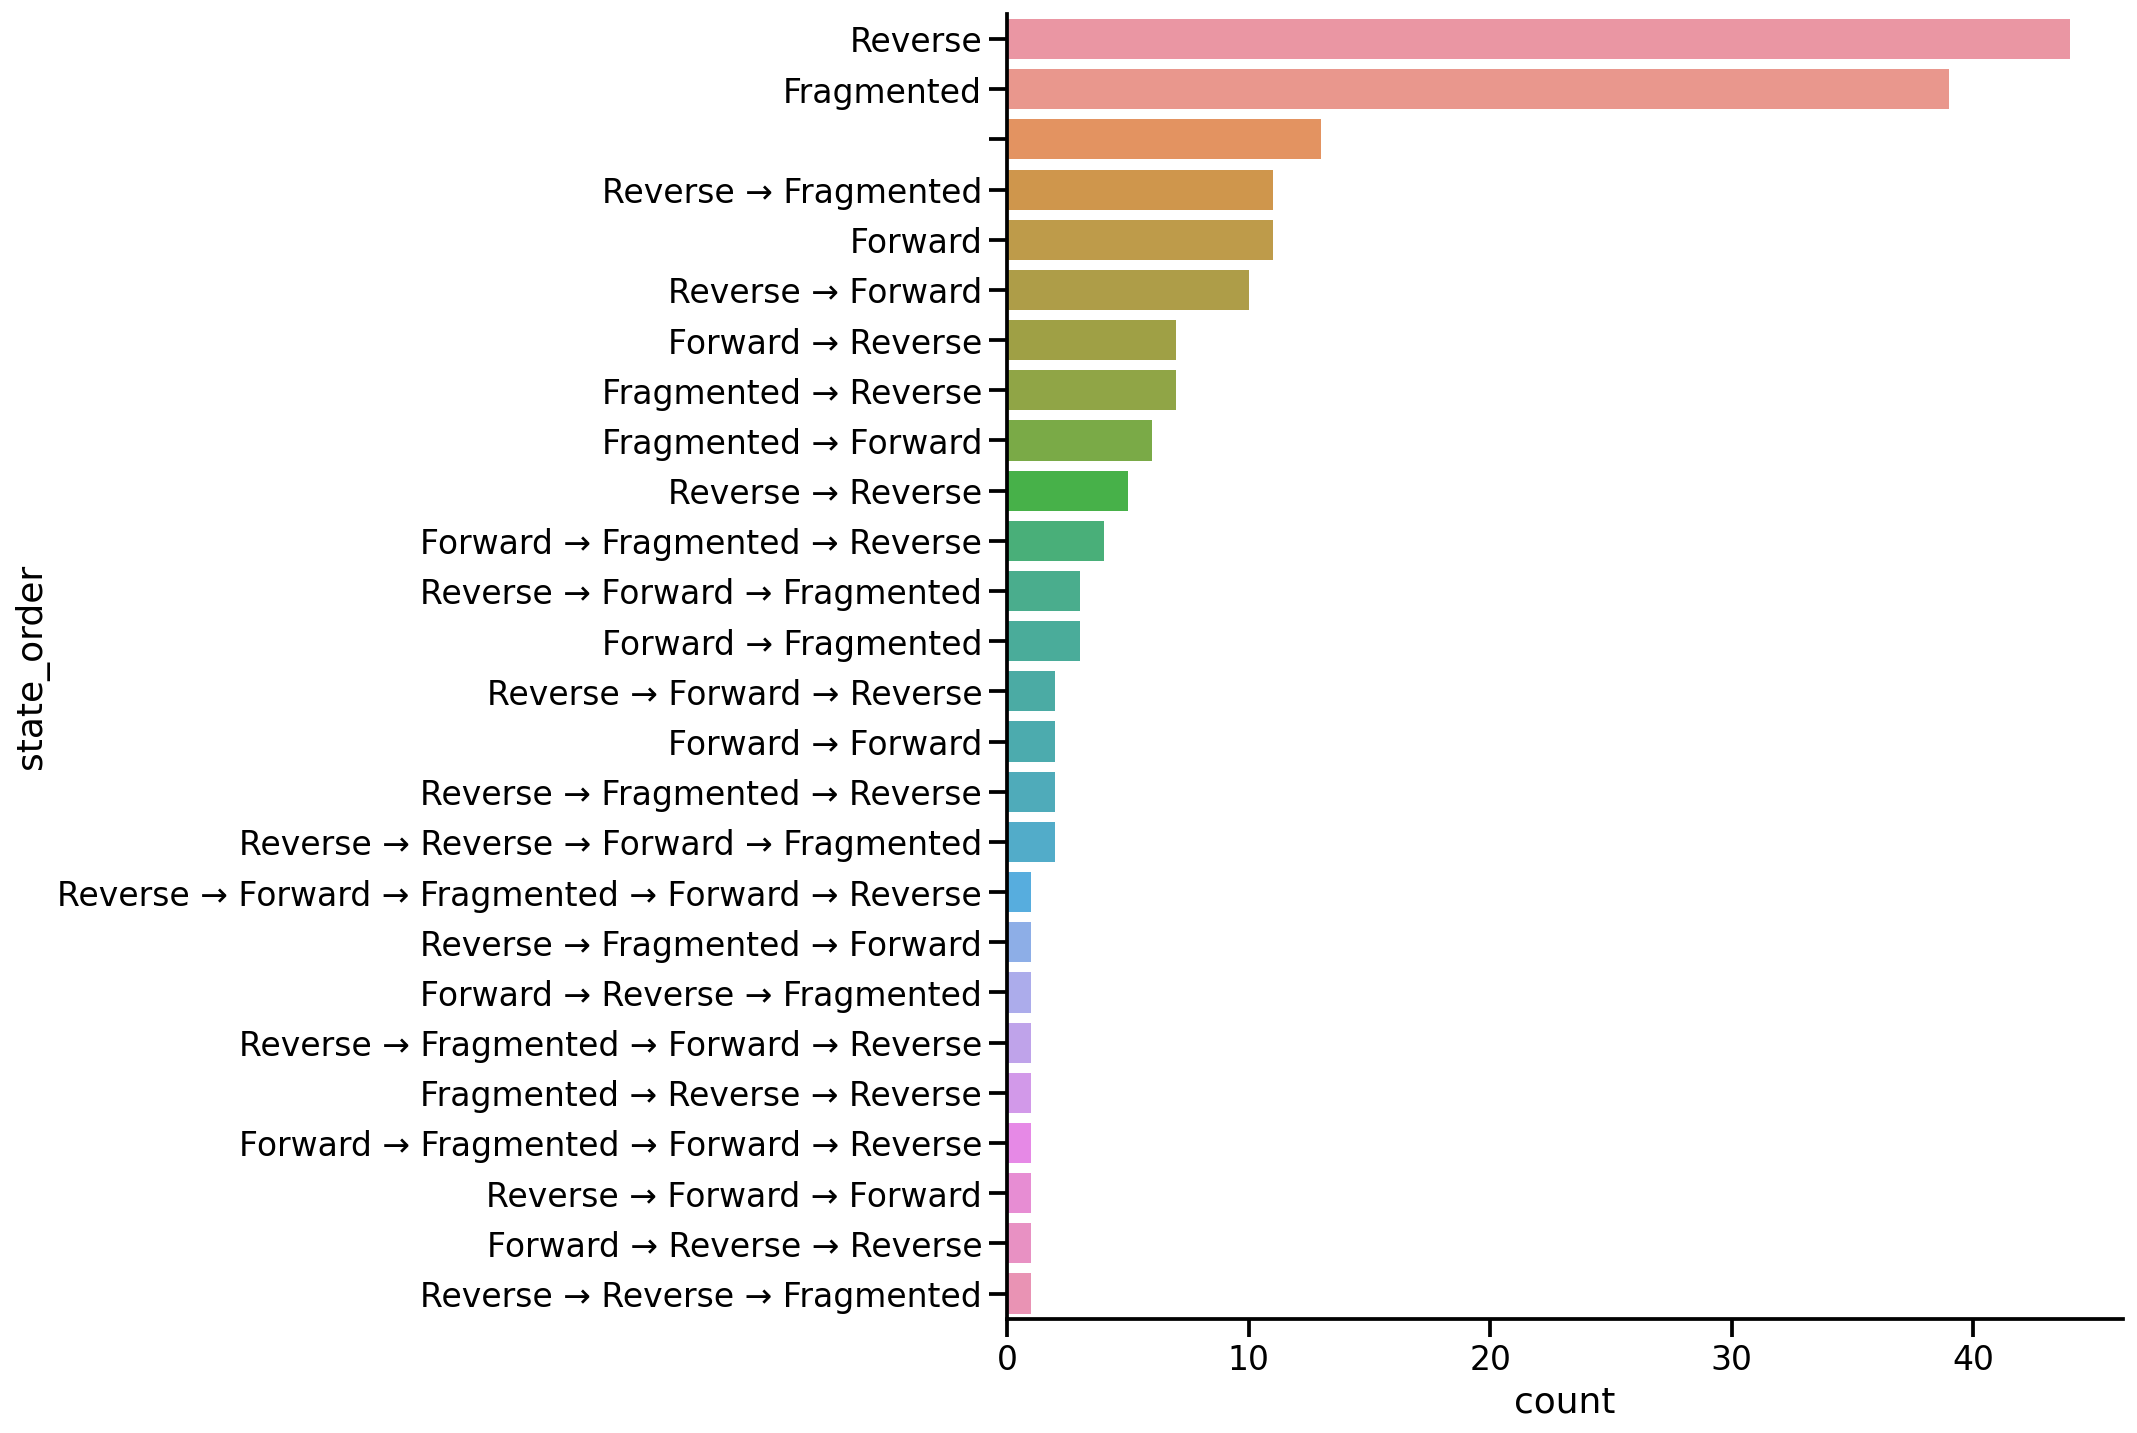

In [411]:
def get_forward_reverse(state):
    split = state.split('-')
    try:
        return split[1]
    except IndexError:
        return split[0]

state_order = [' → '.join([get_forward_reverse(state) for state in states]) for states in classified_states]
state_order = pd.DataFrame(state_order, columns=['state_order'])

fig, ax = plt.subplots(figsize=(10, 12))
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()

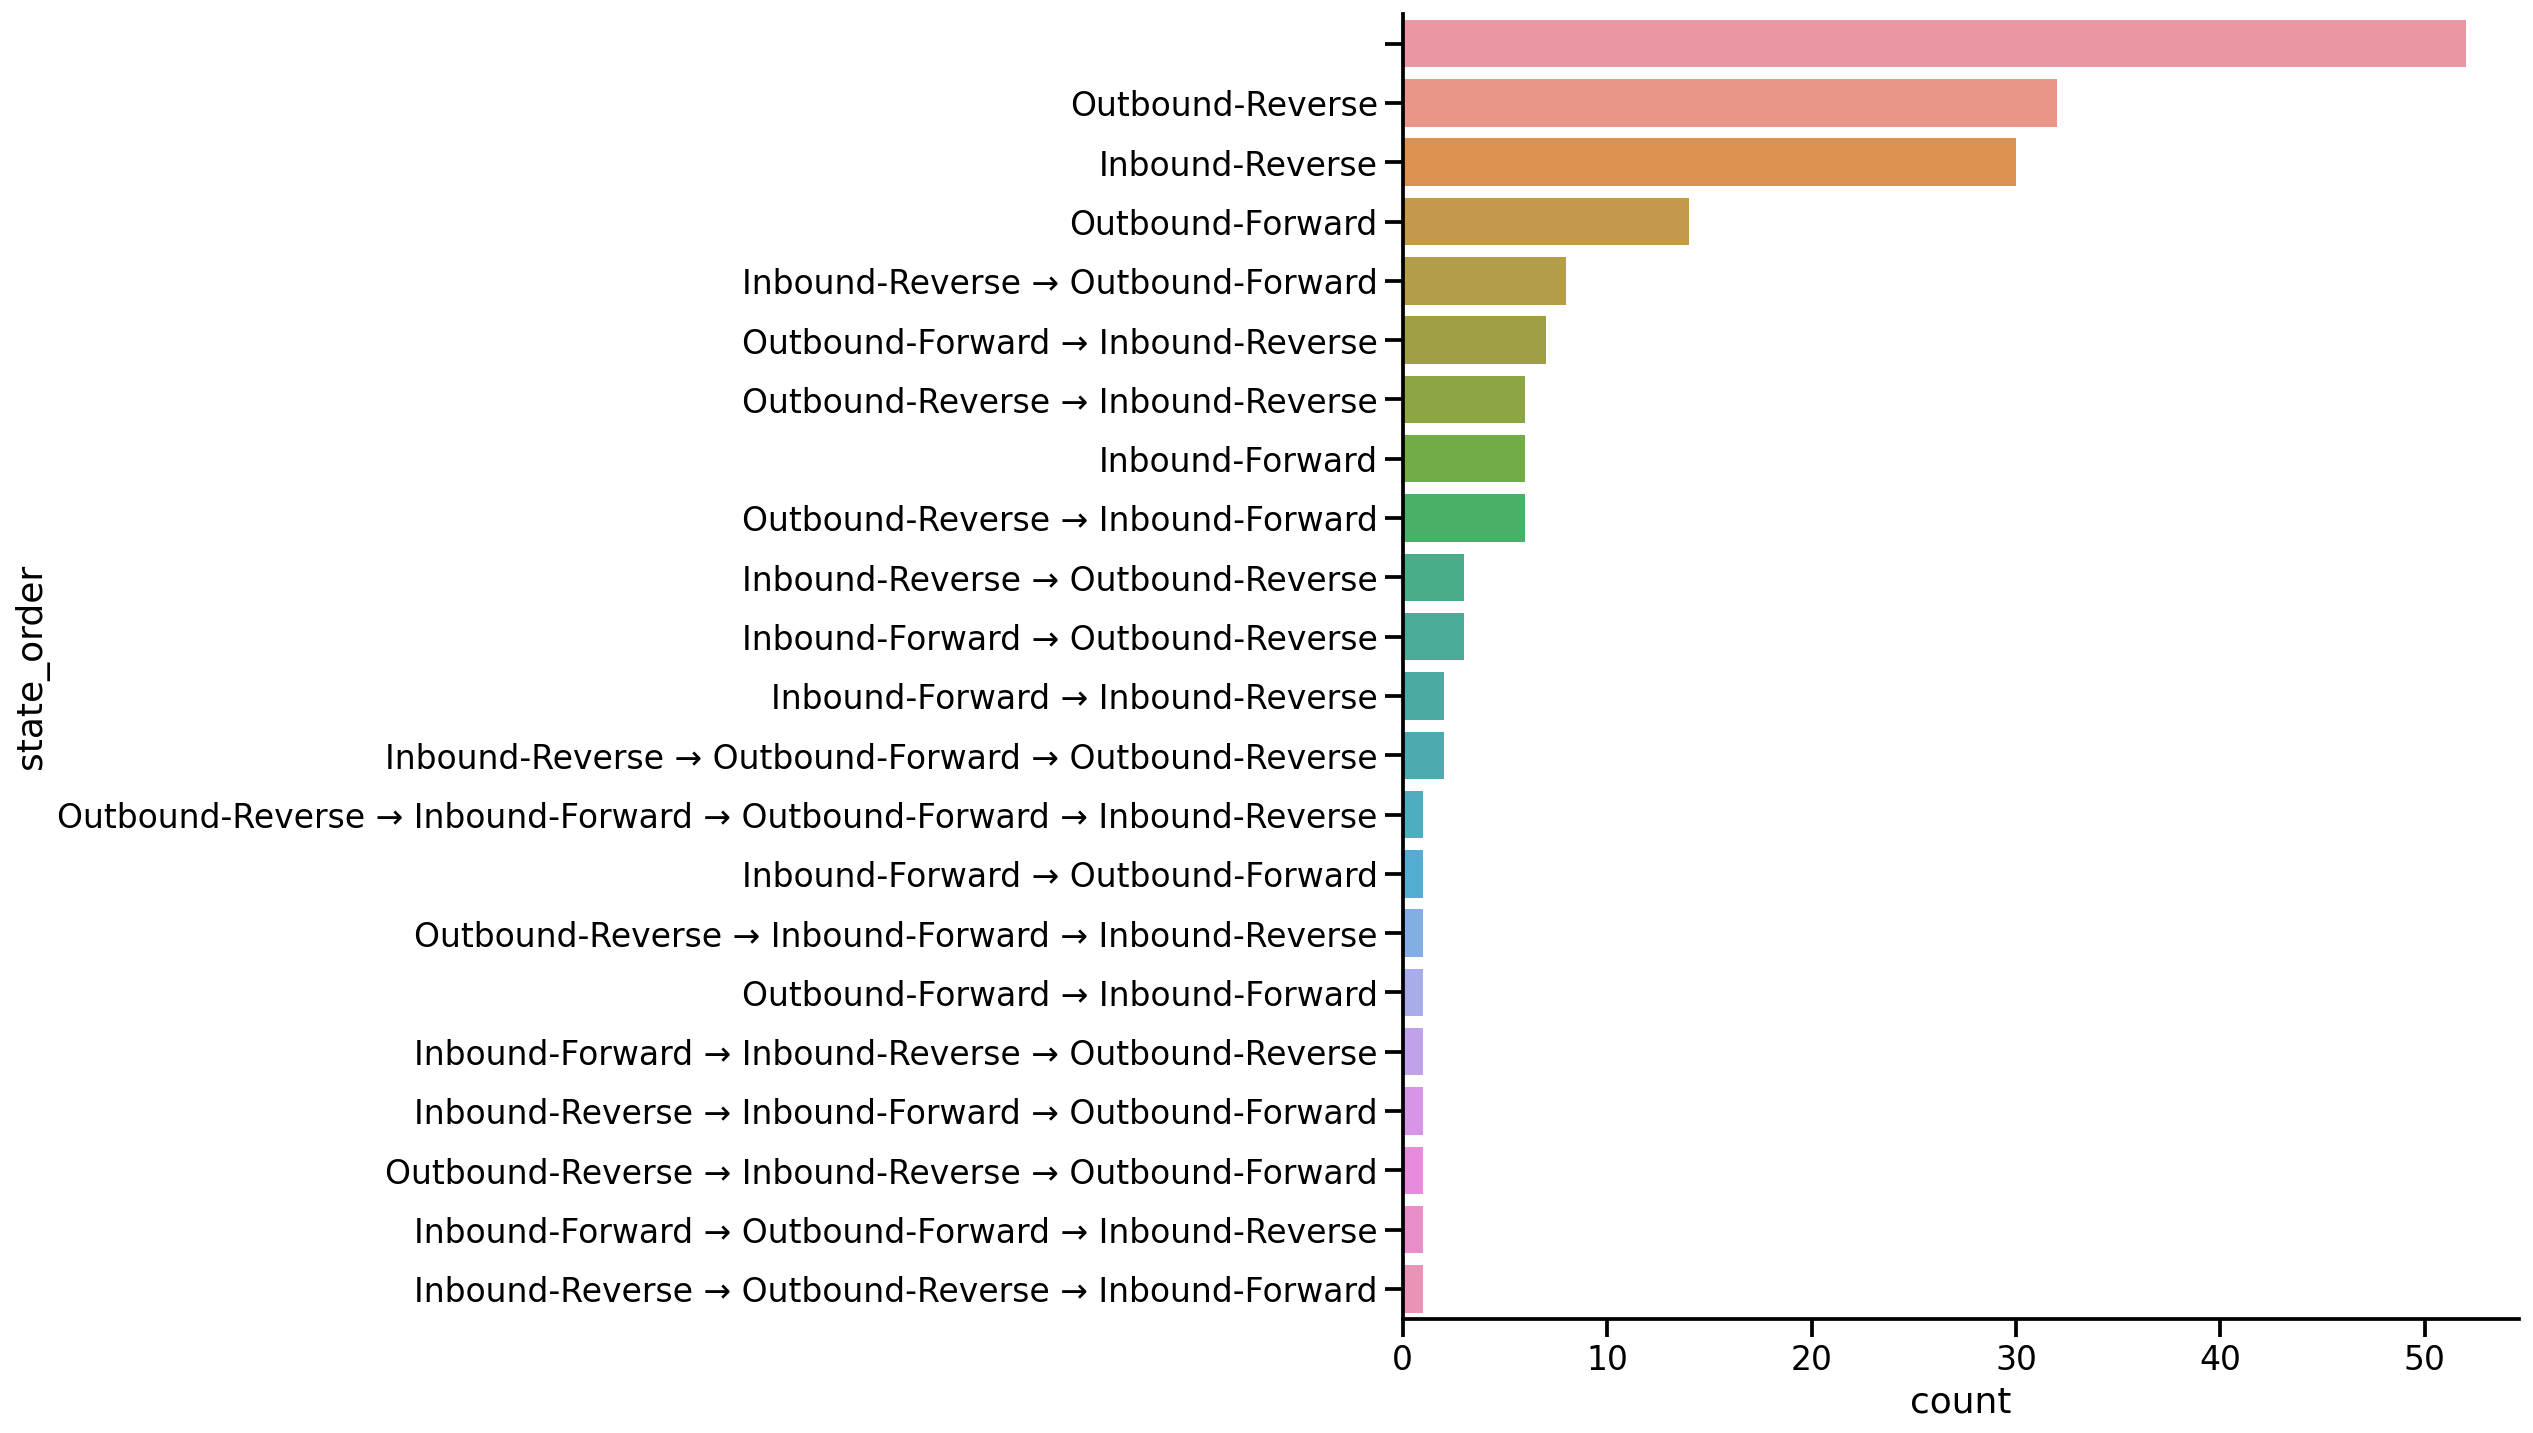

In [435]:
fig, ax = plt.subplots(figsize=(10, 12))
state_order = pd.DataFrame([' → '.join([s for s in states if (s is not None) and (s != 'Fragmented')]) for states in classified_states],
                           columns=['state_order'],
                           index=data['ripple_times'].index)
sns.countplot(y='state_order',
              data=state_order,
              ax=ax,
              order=state_order['state_order'].value_counts().index)
sns.despine()

In [434]:
[s for s in classified_states[0] if (s is not None) and (s != 'Fragmented')]

['Inbound-Reverse']

In [431]:
classified_states

[array(['Inbound-Reverse', 'Fragmented'], dtype=object),
 array(['Inbound-Reverse'], dtype=object),
 array(['Inbound-Forward', 'Fragmented', 'Outbound-Reverse'], dtype=object),
 array(['Fragmented'], dtype=object),
 array(['Inbound-Reverse'], dtype=object),
 array(['Inbound-Reverse', 'Fragmented'], dtype=object),
 array(['Inbound-Reverse'], dtype=object),
 array(['Inbound-Reverse', 'Outbound-Forward'], dtype=object),
 array(['Outbound-Reverse'], dtype=object),
 array(['Inbound-Reverse', 'Outbound-Reverse', 'Inbound-Forward',
        'Fragmented'], dtype=object),
 array(['Outbound-Reverse', 'Inbound-Reverse', 'Outbound-Forward',
        'Fragmented'], dtype=object),
 array(['Fragmented'], dtype=object),
 array(['Fragmented', 'Inbound-Reverse'], dtype=object),
 array(['Fragmented'], dtype=object),
 array([], dtype=object),
 array(['Inbound-Reverse'], dtype=object),
 array(['Outbound-Reverse', 'Inbound-Forward'], dtype=object),
 array(['Outbound-Reverse', 'Fragmented'], dtype=object),
 ar